<a href="https://colab.research.google.com/github/nina-mizrahi/rnn-human-learning-thesis/blob/main/Github_copy_of_Winners_Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0) Player Gameplay Data Preprocessing

##a) Retriever Player Data

In [ ]:
import numpy as np
import pandas as pd
import ast
import math
import os
import sys
import random
from gym import core, spaces
import matplotlib.pyplot as plt
from collections import Counter

#!pip install optuna #this is for parameter search
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from collections import Counter
from collections import defaultdict

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?id=1sesWIlEC2WPLa8hJQlmp-SwX7OwCpUPI' -O spawn.txt
!pip install gdown

import gdown

# File ID and destination path
file_id = "1VYdTS-tFCqcKiCn4rKIO1VMxJLe-9rLQ"
destination = "df.csv"

# Construct the full URL
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
gdown.download(url, destination, quiet=False)

# Load the file into pandas
df = pd.read_csv(destination)

# Display the first few rows
df.head()


--2025-04-25 19:46:20--  https://drive.google.com/uc?id=1sesWIlEC2WPLa8hJQlmp-SwX7OwCpUPI
Resolving drive.google.com (drive.google.com)... 173.194.174.102, 173.194.174.100, 173.194.174.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.174.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1sesWIlEC2WPLa8hJQlmp-SwX7OwCpUPI [following]
--2025-04-25 19:46:20--  https://drive.usercontent.google.com/download?id=1sesWIlEC2WPLa8hJQlmp-SwX7OwCpUPI
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.125.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9292 (9.1K) [application/octet-stream]
Saving to: ‘spawn.txt’

spawn.txt           100%[===================>]   9.07K  --.-KB/s    in 0s      

2025-04-25 19:46:23 (65.1 MB/s) -

/usr/local/lib/python3.11/dist-packages/gdown/download.py:39: DeprecationWarning: Call to deprecated method findChildren. (Replaced by find_all) -- Deprecated since version 3.0.0.
  for param in form.findChildren("input", attrs={"type": "hidden"}):
Downloading...
From (original): https://drive.google.com/uc?id=1VYdTS-tFCqcKiCn4rKIO1VMxJLe-9rLQ
From (redirected): https://drive.google.com/uc?id=1VYdTS-tFCqcKiCn4rKIO1VMxJLe-9rLQ&confirm=t&uuid=c0a2b039-2cd1-4413-8303-bcf8f4fca045
To: /content/df.csv
100%|██████████| 153M/153M [00:01<00:00, 92.0MB/s]


ID             datetime  session_start     time sw_flip  \
0  1593804544_938284352  2020-10-07 09:10:01          14553  16322.0    True   
1  1593804544_938284352  2020-10-07 09:10:01          14553  16729.0    True   
2  1593804544_938284352  2020-10-07 09:10:01          14553  17161.0    True   
3  1593804544_938284352  2020-10-07 09:10:01          14553  17677.0    True   
4  1593804544_938284352  2020-10-07 09:10:01          14553  18224.0    True   

   sw_offset  sw_subwave_num  sw_number    mo_y       mo_x  ...  prev_rank  \
0        0.0             3.0        1.0  198.75  -2.835144  ...        NaN   
1        0.0             3.0        1.0  192.50  15.919434  ...        NaN   
2        0.0             3.0        1.0  165.00  -1.584839  ...        NaN   
3        0.0             3.0        1.0  132.50  -5.335754  ...        NaN   
4        0.0             3.0        1.0  136.25  -9.086670  ...        NaN   

   top  top_prev  puzzle_attempt  cum_score trial_score cum_score_s6  \
0  2.0     first               1       36.0        36.0          NaN   
1  2.0     other               1       36.0        36.0          NaN   
2  2.0     other               1       36.0        36.0          NaN   
3  2.0     other               1       36.0        36.0          NaN   
4  2.0     other               1       36.0        36.0          NaN   

   cum_score_last_6  threshold_puzzle  first_threshold  
0               NaN             False              1.0  
1               NaN             False              1.0  
2               NaN             False              1.0  
3               NaN             False              1.0  
4               NaN             False              1.0  

[5 rows x 63 columns]

##b) Action Sequence Processing

In [ ]:
# Filter out rows where 'action_sequences' is NaN
df = df[~df['action_sequences'].isna()]

Normalize actions within action sequences so they can be taken by step function


In [ ]:
import ast
import math

# Convert string representations of lists to actual lists of floats
df['action_sequences'] = df['action_sequences'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Iterate through each value 'val' in 'seq':
# - If 'val' is -0.0 and its sign is negative, return 6.0.
# - If 'val' is less than 0.0 (negative), multiply 'val' by -1 and add 6.
# - Otherwise, return 'val' as is.
# - actions normalized from -5 to 5, to 0-11
def process_sequence(seq):
  return [6.0 if val == -0.0 and math.copysign(1, val) == -1  else (val*-1+6 if val < 0.0 else val) for val in seq]

df['action_sequences'] = df['action_sequences'].apply(process_sequence)


print(df['action_sequences'])


0         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
1         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
2         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
3         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
4         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
                         ...                 
319614    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
319615    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
319616    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
319617    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
319618    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
Name: action_sequences, Length: 319283, dtype: object


In [ ]:
#extracts the most recent sequence of actions (action_sequences) for each unique combination of player ID, timestamp, session, and subwave so we are working with the final state of each subwave or session
seqs = df.groupby(["ID","datetime","session_start","sw_number"]).last().reset_index()
seqs['action_sequences']

0        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
1        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
3        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
4        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
                        ...                 
63890    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
63891    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 6.0]
63892    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
63893    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
63894    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
Name: action_sequences, Length: 63895, dtype: object

In [ ]:
#transforms the action_sequences column from an allocentric (absolute reference) representation to an egocentric (relative reference) one
def allo_to_ego(action_seq):
    ego_seq = [action_seq[0]] + [
        ((action_seq[i] - action_seq[i - 1]) % 6) + (6 if action_seq[i] >= 6 else 0)
        for i in range(1, len(action_seq))
    ]
    return ego_seq

seqs['action_sequences'] = seqs['action_sequences'].apply(allo_to_ego)
seqs['action_sequences']

0        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
1        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
3        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
4        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
                        ...                 
63890    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
63891    [0.0, 0.0, 1.0, 5.0, 0.0, 0.0, 6.0]
63892    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
63893    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
63894    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]
Name: action_sequences, Length: 63895, dtype: object

##c) Create a gym environment specifying the rules of the game






This class defines the game as a gym environment. The most important functions are:


1.   `ready`, which specifies behaviors of the environtment (e.g., how many levels to play and whether to print out the game state).
2.   `step`, which takes as input the state of the game and the agent's action, and outputs the next state, the reward received in that step, and whether the episode has terminated.

In [ ]:
import random
from gym import core, spaces #core creates base class for creating custom gym enviroment, spaces provides classes to define action and observation spaces

class hexxed(core.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        """Initializes constants.
        """
        self.curr_wave = 1
        self.curr_act = 0
        self.num_attempts = 0
        self.wave_reward = 0
        self.max_reward = 0
        # ↓ which subwave in wave
        self.subwave_num = 0
        #self.states_in_time = []

    def ready(self, num_vertices=6, step_per_pattern=6, levels=6,
              shuffle_patterns=True, random_rolls = False,
              normalize_reward = False, perfect_bonus = False,render_mode=1): #only used initially to set enviroment up - only do once
        """Sets hyperparameters as
        1. complexity of the state space - will never change, number of steps will be the same as num lobes
        2. number of levels to be played
        3. data shuffling #shuffle_patterns controls whether the order of the puzzles is shuffled or stays the same each time you play
        4. randomization of initial states
        5. Whether to incentivize getting a perfect solution
        """

        # ↓ initalize x axis
        self.grid_x = num_vertices #num_vertices is how many sides the puzzle has - 6 for our hexagon
        # ↓ how many steps of target growth player can access - how long the target you need to build can grow (default is 6)
        self.cut_off = step_per_pattern
        # ↓ how many levels to attempt
        self.num_levels = levels
        # ↓ total steps of target growth [changes from 12 to 2*num_vertices] - initializes y axis
        self.grid_y = 2 * num_vertices
        # ↓ if true patterns (unshuffled) are shuffled after being loaded
        # IMPORTANT bc determines whether the order in which puzzles appear is randomized - shuffle_patterns controls whether the order of the puzzles is shuffled or stays the same
        self.shuffle_patterns = shuffle_patterns
        # ↓ if true patterns are rolled with random prob
        #IMPORTANT bc different players get different variations of the game (some get standard some get rotated so we see if rotations are on or off and we might need to know the position of the puzzle pieces so we can properly encode the state of the board
        self.random_rolls = random_rolls
        # ↓ if true rewards is non proportional to the level - default is false
        self.normalize_reward = normalize_reward
        # ↓ if 1, prints the state of the game
        self.render_mode = render_mode

        # add an incentive for the network to get maximum score - turned out not to matter that much
        if perfect_bonus: #sets a bonus value of 36 points for getting a perfect score
            self.perfect_bonus = 36
        else:
            self.perfect_bonus = 0 #no bonus if the score is not perfect

        #reads patterns for the current wave (level) from a file and stores them in a list
        self.pattern_list = self.read_patterns(range(self.curr_wave))
        # ↓ shift_by 0..5 vertices, collect
        self.action_space = spaces.Discrete(num_vertices + 1) #discrete space with num_vertices + 1 possible actions, representing different moves a player can make
        # ↓ contains all states
        grid_size = self.grid_x * self.grid_y
        self.observation_space = spaces.Box(np.zeros(grid_size, dtype=np.float32), #continuous space representing the state of the game grid, with values ranging from 0 to 1
                                            np.ones(grid_size, dtype=np.float32), dtype=np.float32)
        self.subwave_id = []
        self.reward_mean = []
        self.level_num = []
        self.attempt_num = []
        self.reward_hist = []
        self.level_hist = []
        self.action_hist = []

    #Iterate over the range of target numbers
    def read_patterns(self, num_targets):
        # Load all patterns from 'spawn.txt' into a NumPy array
        all_patterns = np.loadtxt('spawn.txt','int',delimiter=',')
        patterns = []
        for i in num_targets:
            # Select patterns that match the current level (i+1) from all_patterns
            level_patterns = all_patterns[all_patterns[...,1] == i+1,...]
            #Reshape the selected patterns and append some extra information to them
            level_patterns = np.append(level_patterns[...,0].reshape((-1,i+1)),level_patterns[::i+1,3].reshape((-1,1)),1)

            # If shuffle_patterns is True, shuffle the selected patterns
            if self.shuffle_patterns:
                np.random.shuffle(level_patterns)
            patterns.extend(level_patterns.tolist())
        return patterns

    def get_grid(self):
      return self.grid

    #input action and the game state --> game state is updated step based on inputted action
    def step(self, action):
      if self.render_mode:
        #self.render()
        #if self.curr_wave == 1:
        self.curr_act = action
        self.action_hist.append(action)
        self.subwave_id.append(self.subwave_num)
        #self.states_in_time[self.key].append(deepcopy(self.grid))
        reward = 0
        done = 0
        if action < 6:
            self.step_grid(action)
        else:
          action = action - 6
          if action > 0 or not self.ismoving:
            self.step_grid(action)

          age = np.where(self.grid[0,self.cut_off:])[0]
          if age.size > 0:
              reward = (age[0]+1)*2
              self.grid[0,:] = 0
              #reward = (np.where(self.grid[0,self.cut_off:])[0][0]+1)2
              #print(reward)
              #self.grid[0,:] = 0

        self.ismoving = True
        if self.normalize_reward:
            reward /= 36.0
        done = np.sum(self.grid) == 0
        self.subwave_reward += max(0,reward)
        if done:
            if self.subwave_reward == self.subwave_max:
                self.max_reward += self.perfect_bonus * self.curr_wave
                reward += self.perfect_bonus * self.curr_wave
            self.max_reward += self.pattern_list[self.subwave_num][-1]
            #self.subwave_num = (self.subwave_num  + 1)
        self.wave_reward += max(0,reward)
        self.reward_hist.append(self.subwave_reward)
        self.reward_mean.append(self.wave_reward)
        self.level_hist.append(self.curr_wave)
        self.attempt_num.append(self.num_attempts)
        if self.render_mode:
          print(self.curr_act,end=' ')
          print(self.curr_wave,end=' ')
          print(self.num_attempts,end=' ')
          print(self.subwave_reward)
        return self.grid.flatten(), reward, done, {}

    #updates the game grid based on the action taken by adjusting the position of elements in the grid
    def step_grid(self,vert): # vert is the action that is fed in
        #if self.ismoving is true (player not at inital state of board) calculates distance aka remaining steps needed to reach the target position
        if self.ismoving:
            dist = max(1,min(vert,6-vert)) # finding clockwise or counter clockwise distance is closest (similiar to what i did but just in one line)
        #If the player is not moving (self.ismoving is False), the distance is set to 1, indicating the initial move.
        else:
            dist = 1
        self.grid = np.roll(np.roll(self.grid,-vert,0),dist,1) # and then you're rolling the board accordingly - np.roll rotates the grid by -vert positions along the rows, and the second np.roll rotates by dist positions along the columns
        self.grid[:,:dist] = 0 #makes the game binary, moving things up and erasing the 1

    #initializes or resets the environment to its starting state, preparing it for a new episode.
    def reset(self):
        #if the accumulated reward for the current wave is below a threshold determined by subtracting a value based on the length of the pattern list multiplied by 15 from the maximum reward achieved so far.
        if (self.curr_wave < 6 and self.wave_reward < self.max_reward - len(self.pattern_list)*15) or \
            (self.curr_wave == 6 and self.wave_reward < self.max_reward - len(self.pattern_list)*6):
            self.reset_helper()

        elif self.subwave_num == len(self.pattern_list):
            self.reset_helper()

            if self.curr_wave == self.num_levels:
                self.curr_wave = 1
            else:
                self.curr_wave = min(self.curr_wave+1, self.num_levels)

        #Subwave Initialization
        if self.subwave_num == 0: #if new subwave
            self.pattern_list = self.read_patterns(range(self.curr_wave-1, self.curr_wave)) #load the patterns for the current wave range
            self.wave_reward = 0
            self.max_reward = 0
            self.num_attempts += 1

        #Grid and Pattern Initialization
        self.ismoving = False
        self.subwave_max = self.pattern_list[self.subwave_num][-1]
        self.subwave_reward = 0

        #initializes the game grid (self.grid) as a matrix of zeros with dimensions (self.grid_x, self.grid_y)
        self.grid = np.zeros(shape=(self.grid_x,self.grid_y))
        #populates the grid based on the patterns for the current subwave, setting certain elements to 1 based on the pattern
        for i in range(len(self.pattern_list[self.subwave_num])-1):
            self.grid[self.pattern_list[self.subwave_num][i]][self.cut_off-i-1] = 1

        #If random rolls are enabled (self.random_rolls is True), this part of the code performs random rotations on the grid
        if self.random_rolls:
            self.grid = np.roll(self.grid,random.randint(0, self.grid_x),0)
            if random.randint(0,2):
                self.grid = np.roll(np.flip(self.grid, 0), 1, 0)
        return self.grid.flatten()

    def reset_helper(self):
        #print('num_attempts {}, subwave_num {}, curr_wave {}'.format(self.num_attempts,self.subwave_num,self.curr_wave))
        #self.reward_mean.append(self.wave_reward/self.subwave_num)
        #self.level_num.append(self.curr_wave)
        #self.attempt_num.append(self.num_attempts)
        self.subwave_num = 0

        # Subwave Initialization
        if self.subwave_num == 0:  # If new subwave
            self.pattern_list = self.read_patterns(range(self.curr_wave-1, self.curr_wave))  # Load the patterns for the current wave range
            self.wave_reward = 0
            self.max_reward = 0
            self.num_attempts += 1

        # Grid and Pattern Initialization
        self.ismoving = False
        self.subwave_max = self.pattern_list[self.subwave_num][-1]
        self.subwave_reward = 0

        # Initializes the game grid (self.grid) as a matrix of zeros with dimensions (self.grid_x, self.grid_y)
        self.grid = np.zeros(shape=(self.grid_x, self.grid_y))
        # Populates the grid based on the patterns for the current subwave, setting certain elements to 1 based on the pattern
        for i in range(len(self.pattern_list[self.subwave_num]) - 1):
            self.grid[self.pattern_list[self.subwave_num][i]][self.cut_off-i-1] = 1

        # If random rolls are enabled (self.random_rolls is True), this part of the code performs random rotations on the grid
        if self.random_rolls:
            self.grid = np.roll(self.grid, random.randint(0, self.grid_x), 0)
            if random.randint(0, 2):
                self.grid = np.roll(np.flip(self.grid, 0), 1, 0)

        # Ensure subwave_num is set to 0
        self.subwave_num = 0

        return self.grid.flatten()


    #display the current state of the game environment, particularly the game grid, in a human-readable format
    def render(self, mode='human', close=False):
        if close:
            return
        hexagon = np.zeros(self.grid_x)
        print(' ',end='')
        for x in range(self.grid_x):
            y = np.where(self.grid[x,:])[0]
            if np.size(y):
                hexagon[x] = y[0]
        for x in range(self.grid_x):
            out_val = int(hexagon[x]-5)
            if out_val == -5:
              print('.',end='  ')
            elif out_val < 0:
              print(out_val,end=' ')
            else:
              print(out_val,end='  ')


##d) Generate Gamestate sequences From Action Sequences

85 element vectors represent gamestate (previous action + resulting board state) where the first 72 elements are the OHE board state and the last 13 elements are the players previous action. Below, we generate boardstate for each action within players action sequence, OHE previous position within sequence

this function might take a few minutes to run!

In [ ]:
import os
import sys

# Function to get one-hot encoding with reset after 13, this will encode players most current action
def get_one_hot_encoding(position, size=13):
    one_hot = np.zeros(size)
    one_hot[position] = 1
    return one_hot

# Function to process the action sequence and get the board states and positions
def get_board_states_and_positions(actions):
    env = hexxed() #for each action sequence, reset the enviroment so we have a new unmodified board
    env.ready()
    env.reset()
    board_states = []
    board_states.append(np.concatenate((env.get_grid().flatten(), get_one_hot_encoding(0)))) #add the initial board, without any actions taken
    for i, action in enumerate(actions[:-1]): #if our target (players next action) is i, we want board state i-1. 1st action doesnt have a boardstate, so add the inital state and remove last action
        #for each action take a step --> modify board acccordingly
        state,_,_,_ = env.step(int(action))
        one_hot_position = get_one_hot_encoding(int(action+1)) #encode what this action is as a OHE vector
        combined_state = np.concatenate((state, one_hot_position)) #combine board state and action
        board_states.append(combined_state) #add to list for that row
    return board_states


# Suppressing print statements
class SuppressPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Iterate over each row in the 'action_sequences' column and process the sequences
all_board_states = []

#with SuppressPrints():
with SuppressPrints():
    for idx, action_sequence in seqs['action_sequences'].items():
        # This block will suppress any prints within the function calls
        board_states = get_board_states_and_positions(action_sequence)
        all_board_states.append(board_states)
print("Processing done!")


# Add the list of board states and positions as new columns to the DataFrame
seqs['board_states'] = all_board_states

Processing done!


make sure that every action sequence has a cooresponding board state sequence of the same length

In [ ]:
# new columns with length of the action sequences and board states
seqs['action_sequence_length'] = seqs['action_sequences'].apply(len)
seqs['board_state_length'] = seqs['board_states'].apply(len)

# Check if lengths match
lengths_match = (seqs['action_sequence_length'] == seqs['board_state_length'])

# show any rows where lengths do not match
mismatch_rows = seqs[~lengths_match]

if not mismatch_rows.empty:
    print("Rows with mismatched lengths:")
    print(mismatch_rows[['action_sequence_length', 'board_state_length']])
else:
    print("All lengths match :p")

All lengths match :p


make sure that all players/attempts have the same inital board state

In [ ]:
# Extract the first element of each list in 'board_states' and store it in a new column
seqs['first_board_state'] = seqs['board_states'].apply(lambda x: x[0])

# Calculate the average of the first_board_state
average_first_board_state = seqs['first_board_state'].mean()

print(average_first_board_state)

#check if any states dont have this value
seqs['is_different'] = seqs['first_board_state'].apply(lambda x: not np.array_equal(x,average_first_board_state))

different_states = seqs[seqs['is_different']]

print(different_states[['first_board_state']])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Empty DataFrame
Columns: [first_board_state]
Index: []


In [ ]:
# this is a better visualization of what the first board state looks like
first_72_values = average_first_board_state[:72]
reshaped_matrix = first_72_values.reshape(6, 12)
print("Average first 72 values of inital board states:")
print(reshaped_matrix)

Average first 72 values of inital board states:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
#Make sure we have the correct inital board states
#we have 12 actions, but there is this one hot encoding to represent that no actions have been taken yet
last_13_values = average_first_board_state[-13:]
print("Average last 13 values of inital board states:")
print(last_13_values)

Average last 13 values of inital board states:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


##e) Define Final Dataframe for Model Input

right now the df contains individual session attempts. we want to make sure that the history of a given ID is grouped together chronologically so our network can train on their entire history.

In [ ]:
#run this to make sure we group correcly later

# Counting number of rows for each ID
id_counts = seqs['ID'].value_counts()

# Filtering for IDs that have multiple rows
multiple_row_counts = id_counts[id_counts > 1]
#print(multiple_row_counts)

#total expected rows after combining
expected_rows = len(id_counts)  # each unique ID should have one row in the final DataFrame

# Filtering for IDs that have a single row
single_row_counts = id_counts[id_counts == 1]

# Calculating the number of rows that will remain unchanged
rows_left_same = len(single_row_counts)

print(f"Total rows in 'seqs': {len(seqs)}")
print(f"Unique IDs with multiple rows: {len(multiple_row_counts)}")
print(f"Number of rows that will be left the same (single-row IDs): {rows_left_same}")
print(f"Number of rows that will be combined: {sum(multiple_row_counts) - len(multiple_row_counts)}")
print(f"Total unique IDs (should match final row count in new DataFrame): {expected_rows}")

Total rows in 'seqs': 63895
Unique IDs with multiple rows: 3925
Number of rows that will be left the same (single-row IDs): 91
Number of rows that will be combined: 59879
Total unique IDs (should match final row count in new DataFrame): 4016


combine rows for the same player (ID) in chronological order

In [ ]:
#Sort the DataFrame by 'datetime' to ensure chronological order
newseqs = seqs.sort_values(by='datetime')

#Identify unique and duplicate IDs
grouped = newseqs.groupby('ID')
unique_ids_df = grouped.filter(lambda x: len(x) == 1)  # IDs without duplicates
duplicate_ids_df = grouped.filter(lambda x: len(x) > 1)  # IDs with multiple rows

# Create a new DataFrame for IDs without duplicates with only selected columns
unique_df = unique_ids_df[['ID', 'action_sequences', 'board_states', 'learning', 'learned']].copy()

#For IDs with duplicates, combine the columns, make sure they are being added in chronological order
# Aggregate using 'sum' for lists and 'max' for binary/categorical indicators
combined_df = (
    duplicate_ids_df.groupby('ID')
    .agg({
        'action_sequences': 'sum',  # Concatenate lists
        'board_states': 'sum',      # Concatenate lists
        'learning': list,          # Take the max value (e.g., if any row has learning, it's true)
        'learned': list            # Take the max value (e.g., if any row has learned, it's true)
    })
    .reset_index()
)

#Concatenate the unique and combined DataFrames to get the final result
final_df = pd.concat([unique_df, combined_df], ignore_index=True)

In [ ]:
#because we concatonated, we want to shuffle the rows so single atttempt ids are mixed in to the rest

# Shuffle rows of final_df randomly
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
#double checking that player action sequences were added correctly

# Display 'action_sequence' values for '1593804544_938284352' in 'seqs'
original_sequences = seqs.loc[seqs['ID'] == '1593804544_938284352', 'action_sequences']
print("Original action_sequences in seqs:")
print(original_sequences.tolist())

# Display the combined 'action_sequence' value for '1593804544_938284352' in 'final_df'
combined_sequence = final_df.loc[final_df['ID'] == '1593804544_938284352', 'action_sequences'].values[0]
print("\nCombined action_sequence in final_df:")
print(combined_sequence)

Original action_sequences in seqs:
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]]

Combined action_sequence in final_df:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0]


In [ ]:
# Check that the length of action_sequences matches the length of board_states for each ID
mismatches = []

for idx, row in final_df.iterrows():
    if len(row['action_sequences']) != len(row['board_states']):
        mismatches.append((row['ID'], len(row['action_sequences']), len(row['board_states'])))

# Print the results
if mismatches:
    print("IDs with mismatched lengths between action_sequences and board_states:")
    for mismatch in mismatches:
        print(f"ID: {mismatch[0]}, action_sequences length: {mismatch[1]}, board_states length: {mismatch[2]}")
else:
    print("All IDs have matching lengths for action_sequences and board_states.")


All IDs have matching lengths for action_sequences and board_states.


filter dataframe so that we only have rows from players who have learning (aka demonstrated a leap of insight at some point in their sequence)

In [ ]:
# Find IDs where the 'learned' column contains both True and False - there should be none of these
mixed_learned_ids = final_df[
    final_df['learned'].apply(lambda x: isinstance(x, list) and len(set(x)) > 1)  # makeing sure x is a list before using set()
]

print("IDs with both True and False in 'learned':")
print(mixed_learned_ids[['ID', 'learned']])


IDs with both True and False in 'learned':
Empty DataFrame
Columns: [ID, learned]
Index: []


In [ ]:
# making sure all entries in 'learned' are lists for consistent processing
final_df['learned'] = final_df['learned'].apply(lambda x: x if isinstance(x, list) else [x])

# Group by 'ID' and combine the 'learned' values into a single list for each ID
grouped_learned = final_df.groupby('ID')['learned'].sum()

# Counting IDs based on whether they learned or not
ids_learned = sum(1 for learned_list in grouped_learned if True in learned_list)
ids_not_learned = sum(1 for learned_list in grouped_learned if True not in learned_list)

print(f"Number of IDs who have learned: {ids_learned}")
print(f"Number of IDs who have not learned: {ids_not_learned}")


Number of IDs who have learned: 1649
Number of IDs who have not learned: 2367


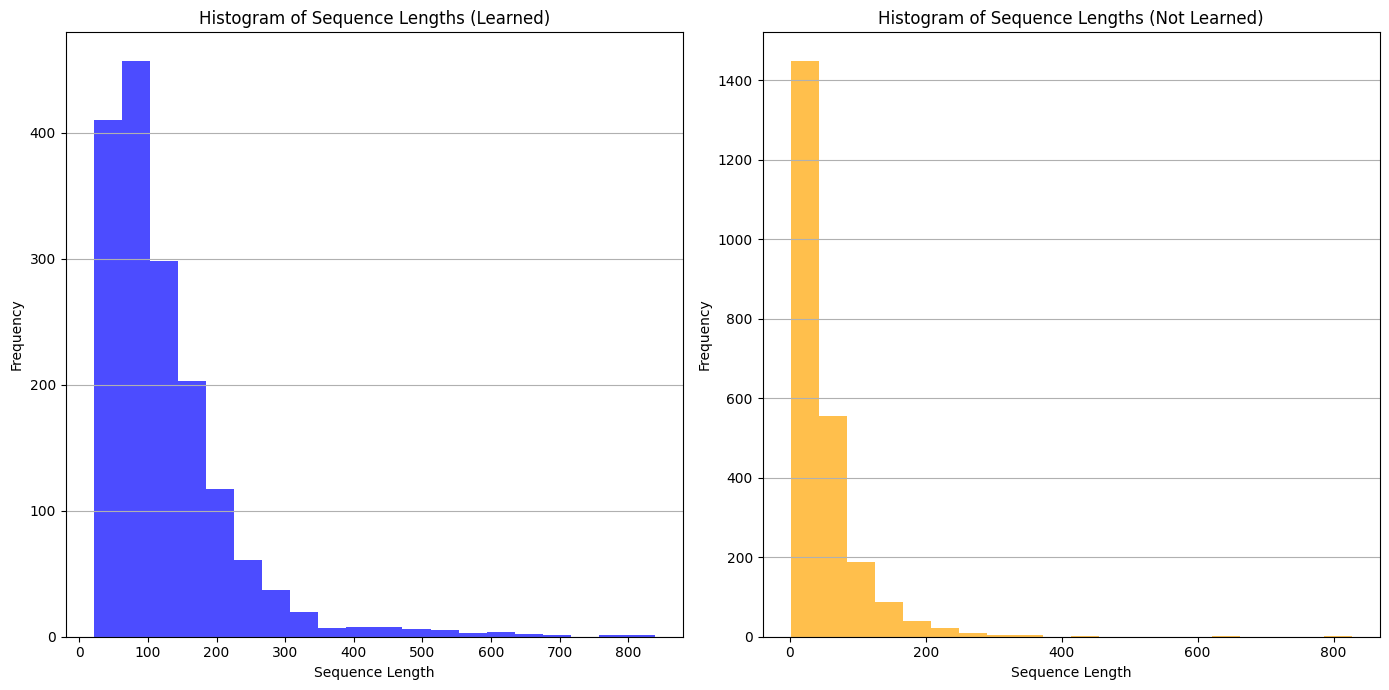

Average sequence length for IDs who have learned: 123.38
Average sequence length for IDs who have not learned: 48.94


In [ ]:
#looking to see if there is a difference between lengths of players who have learned and players who have not

# Add a column for the length of each action sequence
final_df['sequence_length'] = final_df['action_sequences'].apply(len)

# Group by 'ID' to determine learning status
grouped_learned = final_df.groupby('ID')['learned'].sum()

# Identify IDs who have learned and not learned
ids_learned = grouped_learned[grouped_learned.apply(lambda x: True in x)].index
ids_not_learned = grouped_learned[grouped_learned.apply(lambda x: True not in x)].index

# Separate sequence lengths for those who have learned and those who have not
learned_sequence_lengths = final_df[final_df['ID'].isin(ids_learned)]['sequence_length']
not_learned_sequence_lengths = final_df[final_df['ID'].isin(ids_not_learned)]['sequence_length']

# Plot histograms
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))

# Histogram for IDs who have learned
plt.subplot(1, 2, 1)
plt.hist(learned_sequence_lengths, bins=20, alpha=0.7, color='blue')
plt.title('Histogram of Sequence Lengths (Learned)')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Histogram for IDs who have not learned
plt.subplot(1, 2, 2)
plt.hist(not_learned_sequence_lengths, bins=20, alpha=0.7, color='orange')
plt.title('Histogram of Sequence Lengths (Not Learned)')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Calculate and print the average sequence lengths
average_learned_length = learned_sequence_lengths.mean()
average_not_learned_length = not_learned_sequence_lengths.mean()

print(f"Average sequence length for IDs who have learned: {average_learned_length:.2f}")
print(f"Average sequence length for IDs who have not learned: {average_not_learned_length:.2f}")


In [ ]:
# Filter final_df to include only rows where 'learned' contains True
final_df = final_df[final_df['learned'].apply(lambda x: True in x)]

# Display the updated DataFrame structure
print(final_df.head())
print(f"New final_df contains {len(final_df)} rows of players who learned.")


                       ID                                   action_sequences  \
0   1608216576_2052538496  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4   1619047090_3469840963  [0.0, 6.0, 0.0, 11.0, 6.0, 7.0, 0.0, 6.0, 0.0,...   
5   1608128640_3448771584  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, ...   
8   1608160256_4225833472  [0.0, 3.0, 1.0, 3.0, 0.0, 5.0, 5.0, 5.0, 5.0, ...   
10   1612362752_677223360  [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                         board_states  \
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
5   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
8   [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   
10  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   

                                             learning  \
0   [True, True, True, True, True, True, True, Tru...   
4   [True, True, True, True, True, True, True, Tru...   
5   [

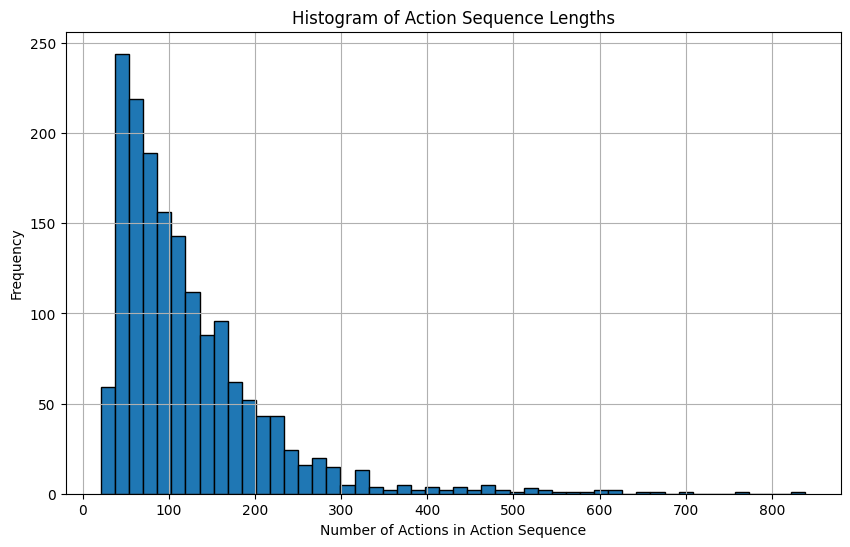

In [ ]:
#histogram of action sequence lengths for players who have learned

# Calculate the length of each action_sequence for every ID in final_df
action_lengths = final_df['action_sequences'].apply(len)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(action_lengths, bins=50, edgecolor='black')
plt.title('Histogram of Action Sequence Lengths')
plt.xlabel('Number of Actions in Action Sequence')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Now i want to look at lengths of action sequences to see where i should trundicate

In [ ]:
# Get the length of each action sequence in final_df
action_sequence_lengths = final_df['action_sequences'].apply(len)

# Find the length of the action sequence at the 90th percentile
length_90th_percentile = action_sequence_lengths.quantile(0.99) #quantile is a function that finds the value below which 99% of the data falls
length_95th_percentile = action_sequence_lengths.quantile(0.95)
# Find the percentile of 704 within the dataset, this is the highest value I can process without RAM crashing
percentile_704 = (action_sequence_lengths <= 704).mean()


print(f"The length of the action sequence at the 99th percentile is {length_90th_percentile}.")
print(f"The length of the action sequence at the 95th percentile is {length_95th_percentile}.")
print(f"The action sequence of 704 falls into: {percentile_704}th percentile.")


The length of the action sequence at the 99th percentile is 512.04.
The length of the action sequence at the 95th percentile is 282.5999999999999.
The action sequence of 704 falls into: 0.9987871437234688th percentile.


In [ ]:
# Count the number of sequences with lengths greater than 512
sequences_above_512 = (action_sequence_lengths > 512).sum()
sequences_above_283 = (action_sequence_lengths > 282).sum()
sequences_above_704 = (action_sequence_lengths > 704).sum()


print(f"The number of sequences with lengths greater than 512 (99th percentile) is {sequences_above_512}.")
print(f"The number of sequences with lengths greater than 283 (95th percentile) is {sequences_above_283}.")
print(f"The number of sequences with lengths greater than 704 (highest value) is {sequences_above_704}.")



The number of sequences with lengths greater than 512 (99th percentile) is 17.
The number of sequences with lengths greater than 283 (95th percentile) is 83.
The number of sequences with lengths greater than 704 (highest value) is 2.


truncating at 704 since it perserves the most data

In [ ]:
# Filter final_df to exclude rows with action_sequences longer than 704. only 2 action sequences will be removed
filtered_final_df = final_df[final_df['action_sequences'].apply(len) <= 704]

# Check the new shape of the DataFrame
print(f"Filtered DataFrame has {filtered_final_df.shape[0]} rows and {filtered_final_df.shape[1]} columns.")


Filtered DataFrame has 1647 rows and 6 columns.


#1) GLM and Control Models

In [ ]:
#!pip install optuna #this is for parameter search
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

##a) Prepare Features and Targets for GLM
Flatten the 'action_sequences' and 'board_states' columns so that each row corresponds to a single action and its corresponding board state. split rows *before* flattening so that we dont split in the middle of someones sequence

In [ ]:
# Define the function to add steps-from-start and steps-from-end, this will be used during sequence processing later
def add_positions_and_reversed(df):
    df = df.copy()
    df['positions'] = df['action_sequences'].apply(lambda x: list(range(len(x))))
    df['reversed_positions'] = df['action_sequences'].apply(lambda x: list(range(len(x) - 1, -1, -1))) #(starting point of range, stopping point, step of range)
    return df

# Add positions and reversed positions to our DataFrame
final_df = add_positions_and_reversed(final_df)

# Separate the four columns for features, targets, positions, and reversed positions
Cont_X = final_df['board_states']
Cont_y = final_df['action_sequences']
Cont_positions = final_df['positions'] #will be used in sequence tracking later
Cont_reversed_positions = final_df['reversed_positions'] #will be used in sequence tracking later

# Split the data into training and validation sets (80/20 split)
Cont_X_train, Cont_X_val, Cont_y_train, Cont_y_val, positions_train, positions_val, reversed_positions_train, reversed_positions_val = train_test_split(
    Cont_X, Cont_y, Cont_positions, Cont_reversed_positions, test_size=0.2, random_state=42
)

# Flatten the training and validation data
flattened_board_states_train = np.concatenate(Cont_X_train.values)
flattened_action_sequences_train = np.concatenate(Cont_y_train.values)
flattened_positions_train = np.concatenate(positions_train.values)
flattened_reversed_positions_train = np.concatenate(reversed_positions_train.values)

flattened_board_states_val = np.concatenate(Cont_X_val.values)
flattened_action_sequences_val = np.concatenate(Cont_y_val.values)
flattened_positions_val = np.concatenate(positions_val.values)
flattened_reversed_positions_val = np.concatenate(reversed_positions_val.values)

# Convert flattened data to NumPy arrays
Cont_X_train = np.array(flattened_board_states_train, dtype=np.float32)
Cont_y_train = np.array(flattened_action_sequences_train, dtype=np.int32)
positions_train = np.array(flattened_positions_train, dtype=np.int32)
reversed_positions_train = np.array(flattened_reversed_positions_train, dtype=np.int32)

Cont_X_val = np.array(flattened_board_states_val, dtype=np.float32)
Cont_y_val = np.array(flattened_action_sequences_val, dtype=np.int32)
positions_val = np.array(flattened_positions_val, dtype=np.int32)
reversed_positions_val = np.array(flattened_reversed_positions_val, dtype=np.int32)

# Verify shapes
print("Shape of training board_states:", Cont_X_train.shape)
print("Shape of training action_sequences:", Cont_y_train.shape)
print("Shape of training positions:", positions_train.shape)
print("Shape of training reversed positions:", reversed_positions_train.shape)
print("Shape of validation board_states:", Cont_X_val.shape)
print("Shape of validation action_sequences:", Cont_y_val.shape)
print("Shape of validation positions:", positions_val.shape)
print("Shape of validation reversed positions:", reversed_positions_val.shape)


Shape of training board_states: (164038, 85)
Shape of training action_sequences: (164038,)
Shape of training positions: (164038,)
Shape of training reversed positions: (164038,)
Shape of validation board_states: (39411, 85)
Shape of validation action_sequences: (39411,)
Shape of validation positions: (39411,)
Shape of validation reversed positions: (39411,)


##b) GLM - Dense network with no hidden layers and softmax output

###i) Define and Fit Model

In [ ]:
# Determine the number of unique actions for the output layer size
num_actions = 12 #same as len(np.unique(Cont_y))

glm_model = Sequential([
    Dense(num_actions, input_shape=(85,), activation='softmax')
])

# Define the optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile model
glm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Fit the model with early stopping
glm_history = glm_model.fit(
    Cont_X_train, Cont_y_train,
    epochs=50,
    validation_data=(Cont_X_val, Cont_y_val),
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4028 - loss: 2.1936 - val_accuracy: 0.5643 - val_loss: 1.6517
Epoch 2/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5778 - loss: 1.5354 - val_accuracy: 0.5776 - val_loss: 1.4095
Epoch 3/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.5902 - loss: 1.3518 - val_accuracy: 0.6184 - val_loss: 1.3292
Epoch 4/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.6286 - loss: 1.2906 - val_accuracy: 0.6261 - val_loss: 1.2918
Epoch 5/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6378 - loss: 1.2579 - val_accuracy: 0.6415 - val_loss: 1.2708
Epoch 6/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.6469 - loss: 1.2361 - val_accuracy: 0.6423 - val_loss: 1.2574
Epoch 7/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.6469 - loss: 1.2248 - val_accuracy: 0.6427 - val_loss: 1.2482
Epoch 8/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6459 - loss: 1

###ii) Evaluate the model

####Training and Validation Loss and Accruacy

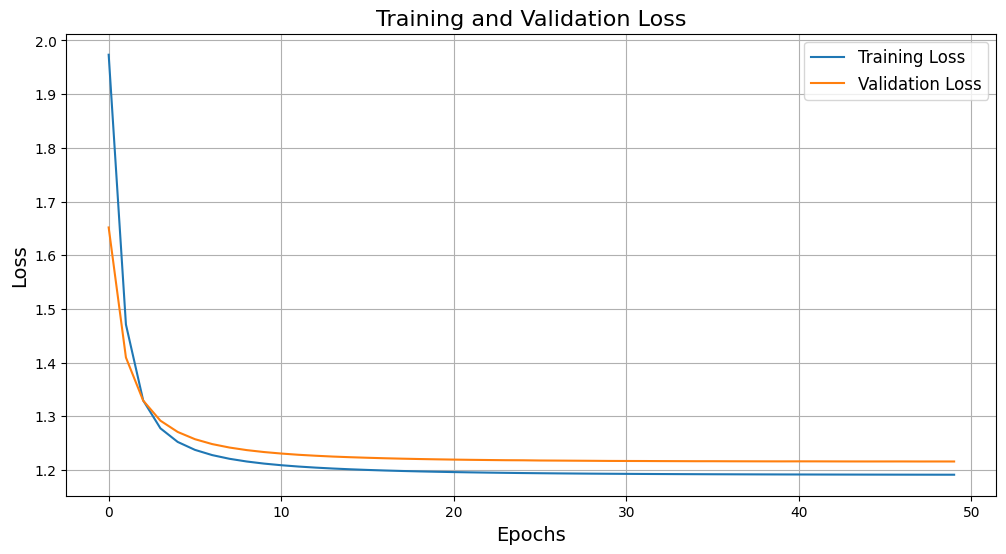

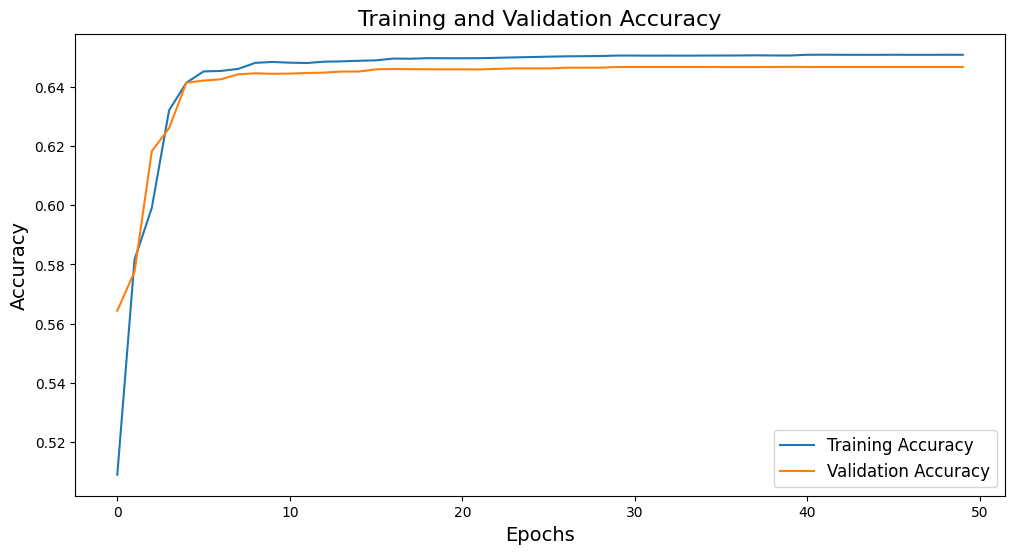

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(glm_history.history['loss'], label='Training Loss')
plt.plot(glm_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(glm_history.history['accuracy'], label='Training Accuracy')
plt.plot(glm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.show()


In [ ]:
Cont_val_loss, Cont_val_acc = glm_model.evaluate(Cont_X_val, Cont_y_val)
print(f'Validation Loss: {Cont_val_loss}')
print(f'Validation Accuracy: {Cont_val_acc}')

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6616 - loss: 1.1715
Validation Loss: 1.2160104513168335
Validation Accuracy: 0.646875262260437


####Visualize Weights

In [ ]:
# Extract the weights of the dense layer
Cont_weights, Cont_biases = glm_model.layers[0].get_weights()

Weights for all actions (Last 13 weights)

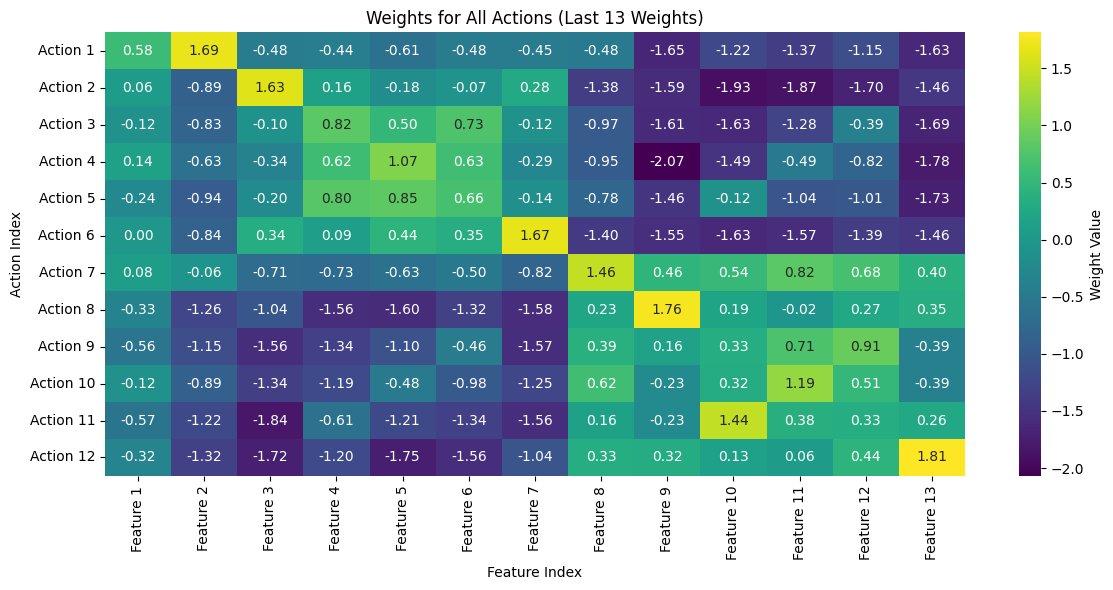

In [ ]:
import seaborn as sns

num_actions = 12
# Number of features to use (last 13)
num_features = 13

# Prepare an array to hold the last 13 weights for each action
weights_matrix = np.zeros((num_actions, num_features))

# Extract the last 13 weights for each action
for i in range(num_actions):
    weights_for_action = Cont_weights[-num_features:, i]  # Use negative indexing to get the last 13 weights
    weights_matrix[i] = weights_for_action

plt.figure(figsize=(12, 6))
sns.heatmap(weights_matrix, cmap='viridis', annot=True, fmt='.2f', cbar=True,
            cbar_kws={'label': 'Weight Value'},
            xticklabels=[f'Feature {j + 1}' for j in range(num_features)],
            yticklabels=[f'Action {i + 1}' for i in range(num_actions)])
plt.title('Weights for All Actions (Last 13 Weights)')
plt.xlabel('Feature Index')
plt.ylabel('Action Index')
plt.tight_layout()
plt.show()

Weights for boardstates (first 72 weights)

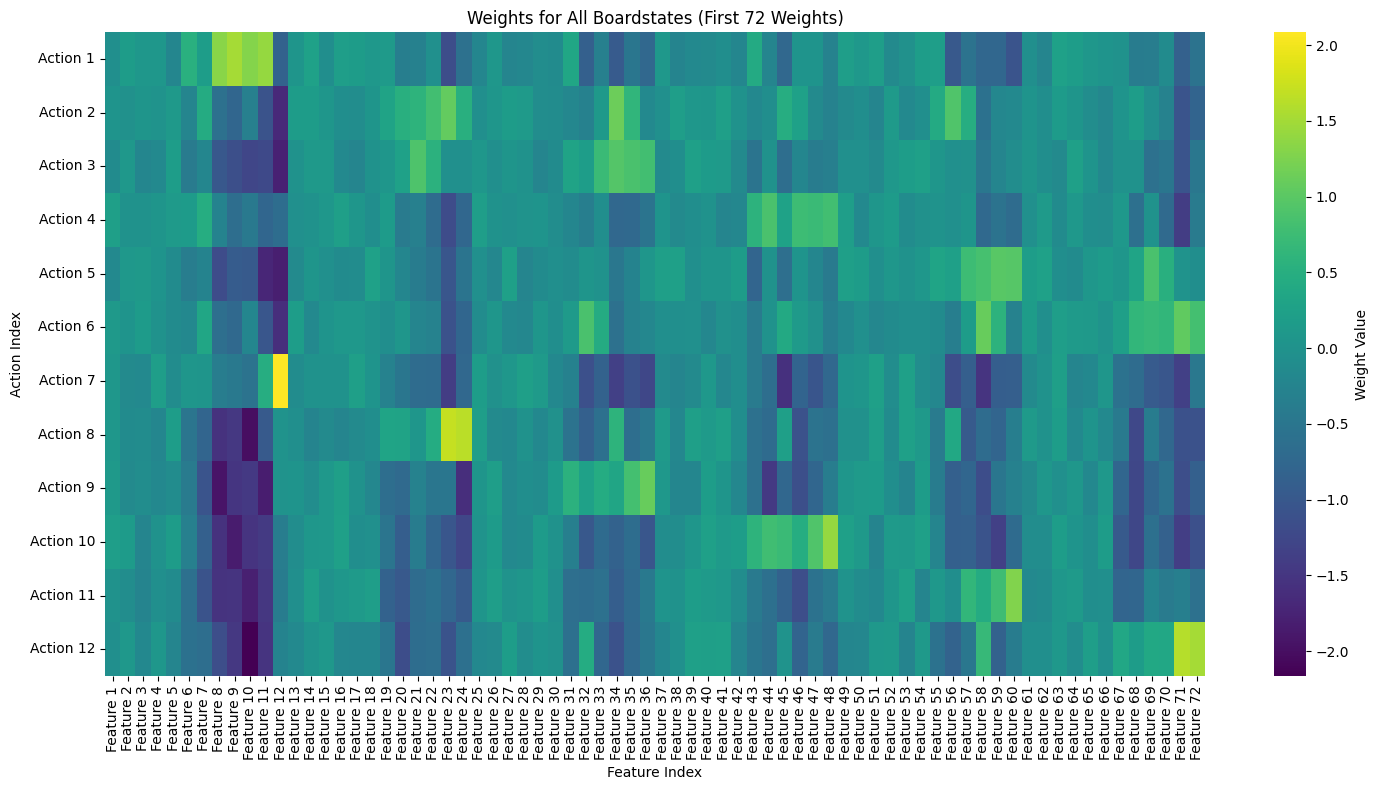

In [ ]:
# Number of features to use (first 72)
num_features = 72

# Prepare an array to hold the first 72 weights for each Boardstate
weights_matrix = np.zeros((num_actions, num_features))

# Extract the first 72 weights for each action
for i in range(num_actions):
    weights_for_action = Cont_weights[:num_features, i]  # Using slicing to get the first 72 weights
    weights_matrix[i] = weights_for_action

plt.figure(figsize=(15, 8))
sns.heatmap(weights_matrix, cmap='viridis', cbar=True,
            cbar_kws={'label': 'Weight Value'},
            xticklabels=[f'Feature {j + 1}' for j in range(num_features)],
            yticklabels=[f'Action {i + 1}' for i in range(num_actions)])
plt.title('Weights for All Boardstates (First 72 Weights)')
plt.xlabel('Feature Index')
plt.ylabel('Action Index')
plt.tight_layout()
plt.show()

visualize the weights for each of the 12 actions individually


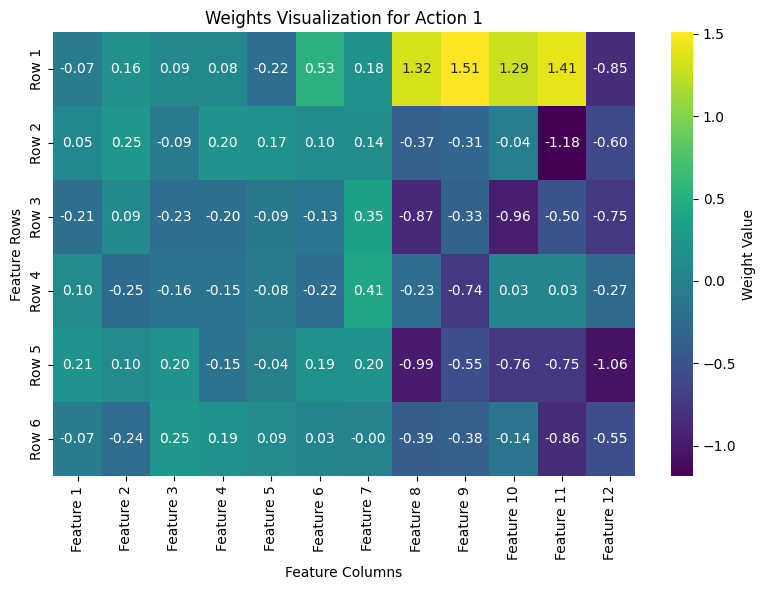

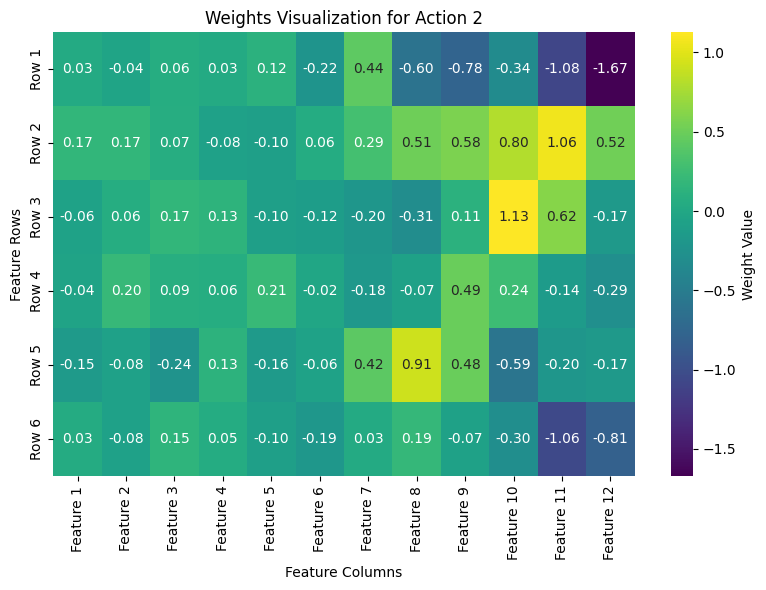

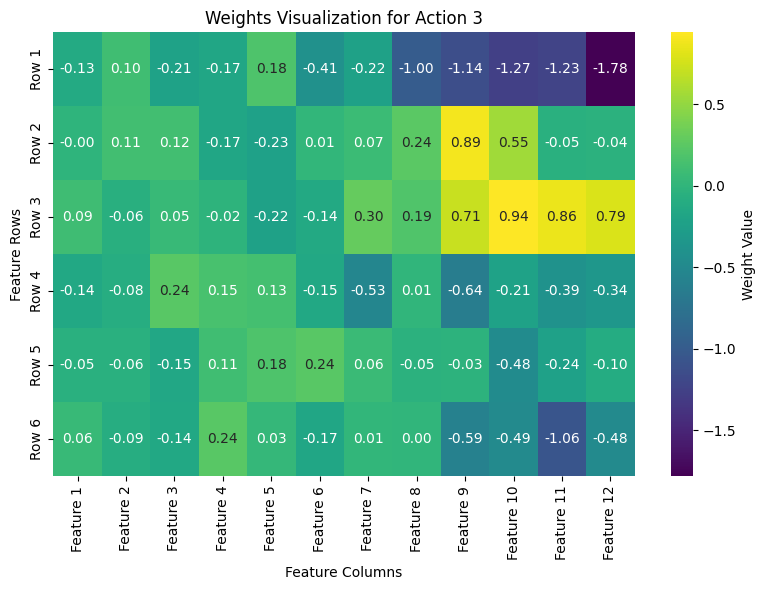

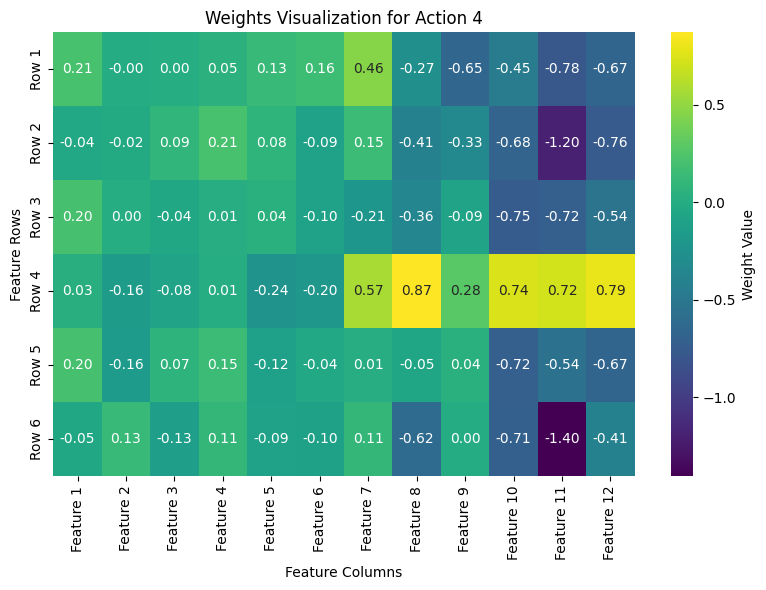

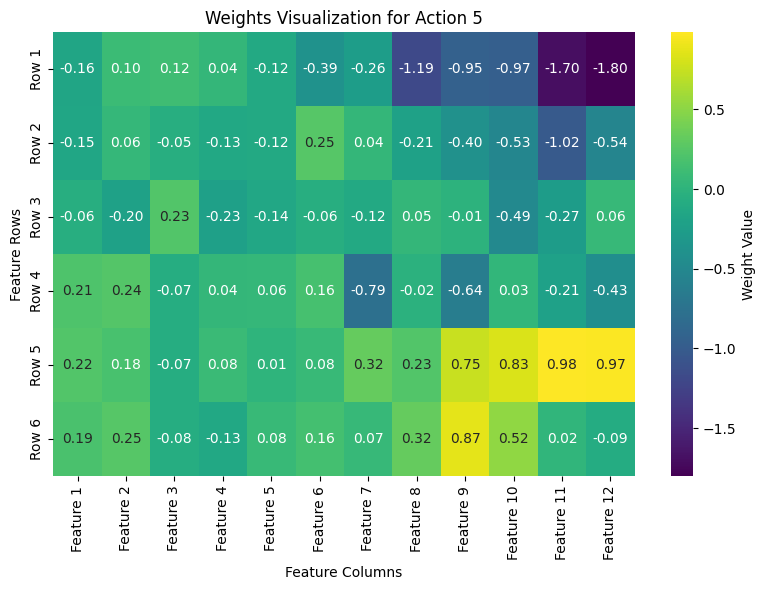

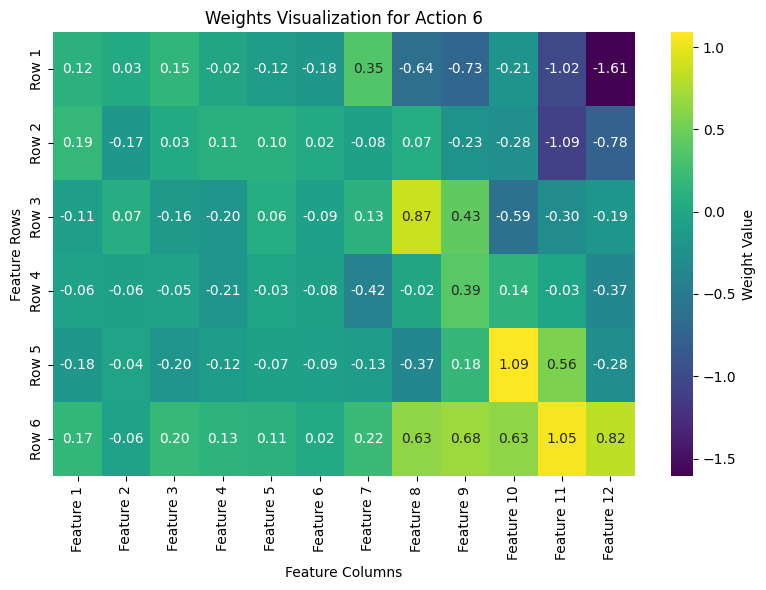

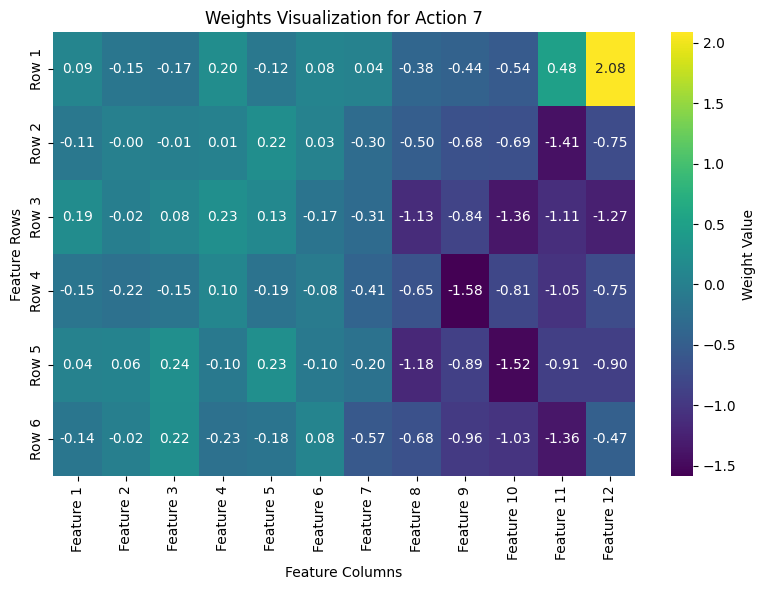

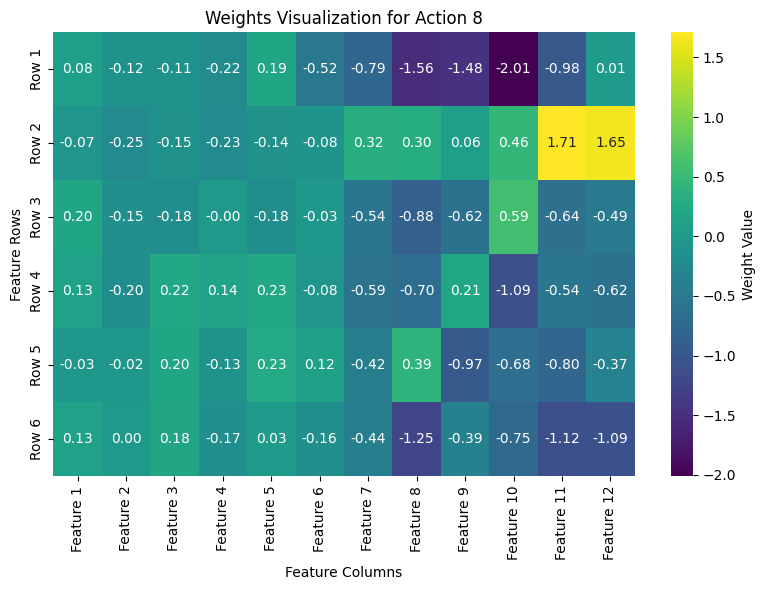

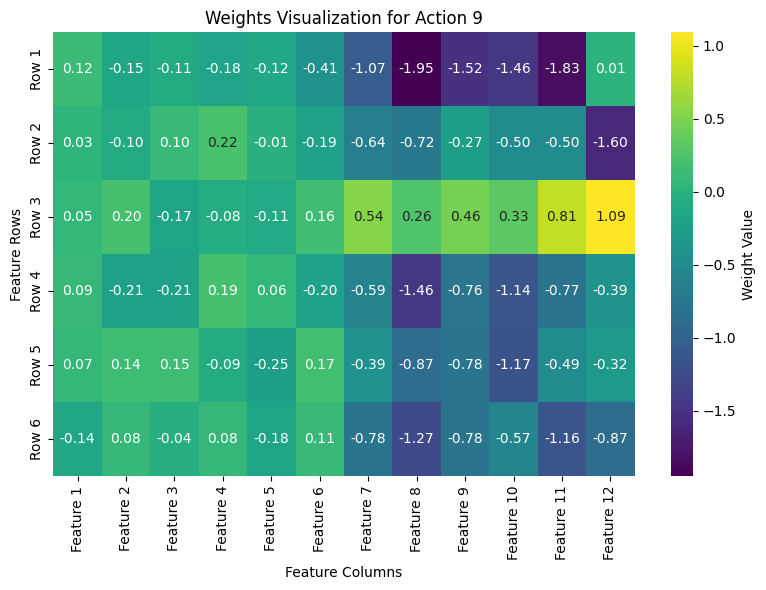

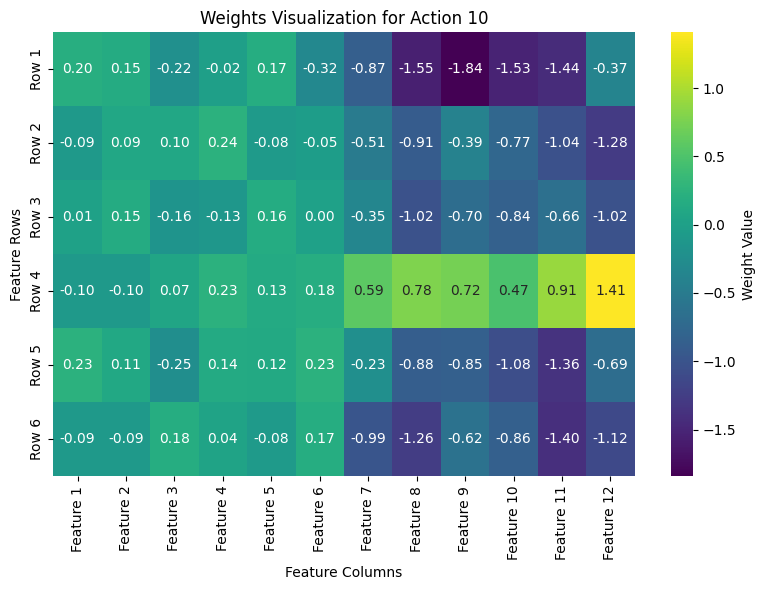

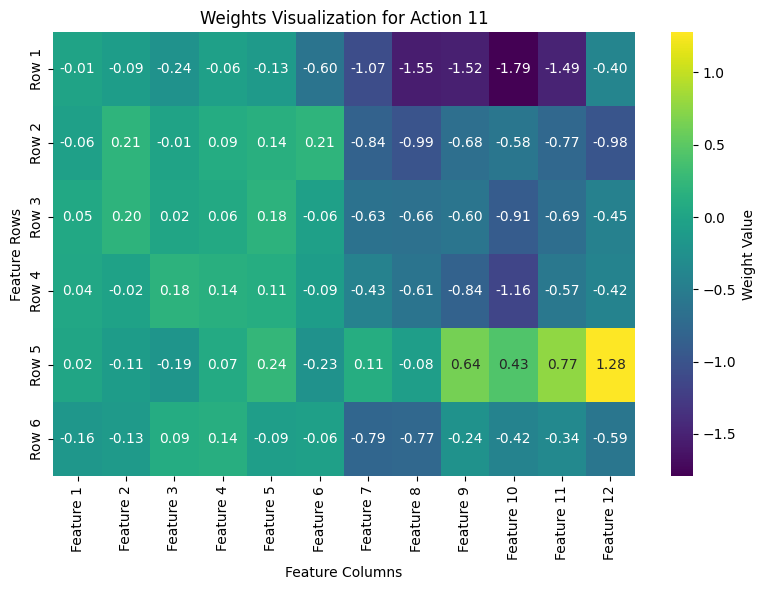

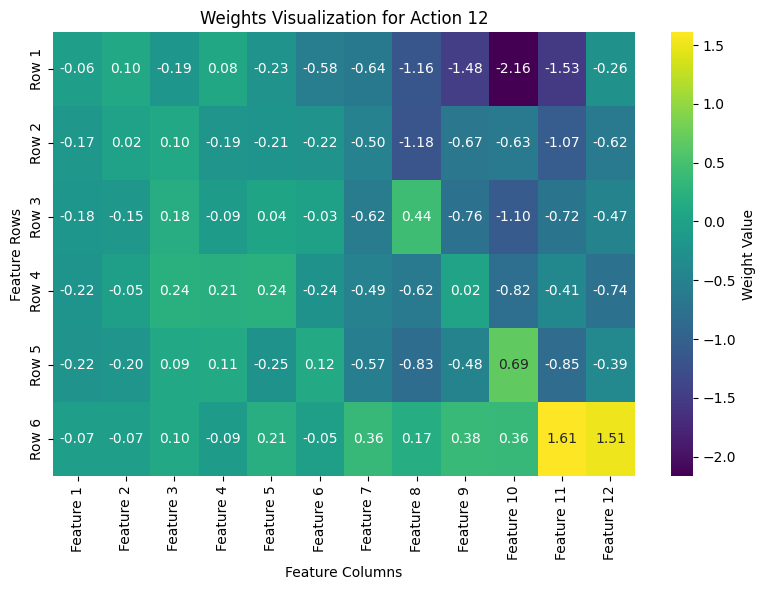

In [ ]:
#visualize the weights for each of the 12 actions individually

# Parameters for visualization
num_actions = 12  # Number of actions
num_features = 72  # First 72 weights
rows, cols = 6, 12  # Reshaping parameters

# Extract and reshape weights
reshaped_weights = []
for i in range(num_actions):
    # Extract the first 72 weights for each action and reshape to 6x12
    weights_for_action = Cont_weights[:num_features, i]
    reshaped_weights.append(weights_for_action.reshape(rows, cols))

# Plotting with sns.heatmap and annot=True
for i, weights in enumerate(reshaped_weights):
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights, cmap='viridis', annot=True, fmt='.2f', cbar=True,
                cbar_kws={'label': 'Weight Value'},
                xticklabels=[f'Feature {j + 1}' for j in range(cols)],
                yticklabels=[f'Row {j + 1}' for j in range(rows)])
    plt.title(f'Weights Visualization for Action {i + 1}')
    plt.xlabel('Feature Columns')
    plt.ylabel('Feature Rows')
    plt.tight_layout()
    plt.show()

####Visualize Bias

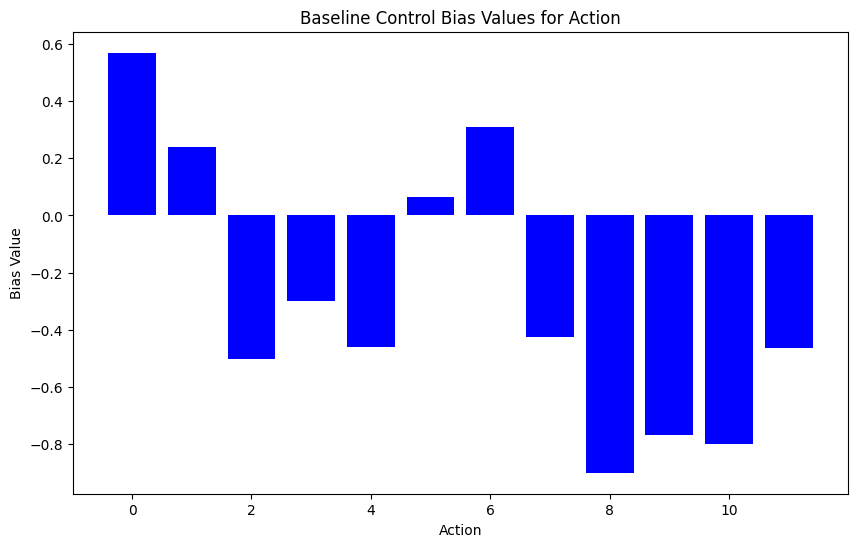

In [ ]:
#Plot biases for each action
plt.figure(figsize=(10, 6))
plt.bar(range(len(Cont_biases)), Cont_biases, color='blue')
plt.xlabel('Action')
plt.ylabel('Bias Value')
plt.title('Baseline Control Bias Values for Action')
plt.show()

####Precision and Recall

In [ ]:
#Get predictions
glm_predictions = glm_model.predict(Cont_X_val)
glm_pred_classes = np.argmax(glm_predictions, axis=1)  # Get class with highest probability

#Flatten true labels (they should already be 1D for sparse categorical)
true_labels = Cont_y_val.flatten()

#Calculate precision and recall for each class
precision = precision_score(true_labels, glm_pred_classes, average=None)
recall = recall_score(true_labels, glm_pred_classes, average=None)

print("Precision for each class (action):", precision)
print("Recall for each class (action):", recall)

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Precision for each class (action): [0.71165749 0.61041667 0.27016129 0.29978587 0.29064039 0.59152162
 0.58198404 0.60449859 0.25       0.29109589 0.2195122  0.45564516]
Recall for each class (action): [0.91922589 0.58560959 0.06627102 0.155902   0.05750487 0.53887468
 0.51817259 0.45454545 0.01197605 0.1150203  0.09698276 0.34591837]


####Confusion Matrix

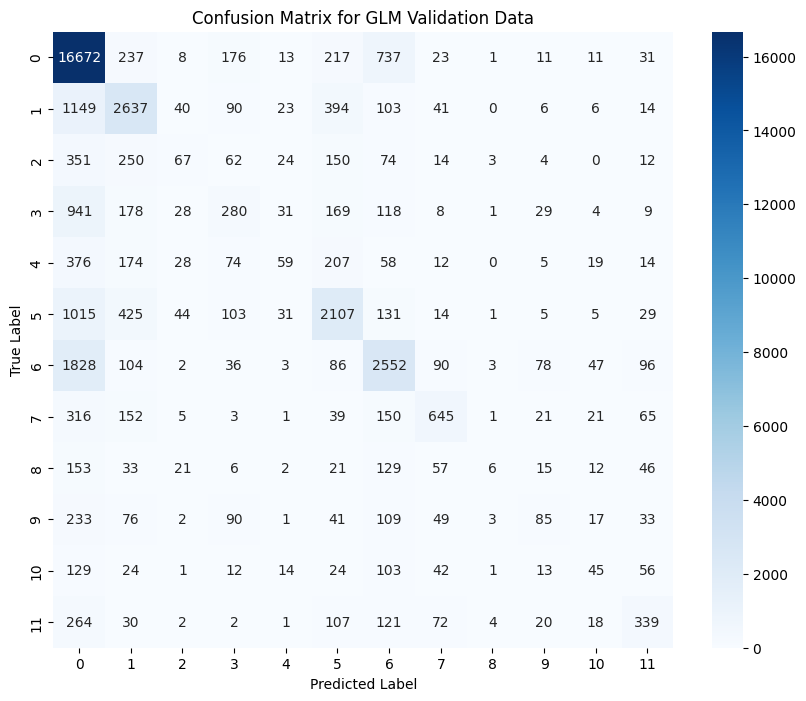

In [ ]:
#Create confusion matrix
conf_matrix = confusion_matrix(true_labels, glm_pred_classes)

#Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_actions), yticklabels=range(num_actions))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for GLM Validation Data')
plt.show()

###iii) Parameter Search

parameter seearch for unit sizes and learning rate using Optuna

In [ ]:
# import optuna

# # Define the number of unique actions for the output layer size
# num_actions = len(np.unique(Cont_y))

# # Define the objective function for Optuna
# def objective(trial):
#     # Suggest values for the number of units in the Dense layer and learning rate
#     units = trial.suggest_int("units", 12, 128, step=4)  # From 8 to 128 with steps of 4
#     learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-1)

#     # Build the model with the suggested hyperparameters
#     model = Sequential([
#         Dense(units, input_shape=(85,), activation='softmax')
#     ])

#     # Define the optimizer with the suggested learning rate
#     optimizer = Adam(learning_rate=learning_rate)

#     # Compile the model
#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     # Early stopping to avoid overfitting
#     early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

#     # Fit the model on the training data
#     history = model.fit(
#         Cont_X_train, Cont_y_train,
#         epochs=50,
#         validation_data=(Cont_X_val, Cont_y_val),
#         batch_size=32,
#         callbacks=[early_stopping],
#         verbose=0  # Suppress training output for faster Optuna search
#     )

#     # Retrieve the best validation accuracy from training
#     val_accuracy = max(history.history['val_accuracy'])

#     # Return the validation accuracy as the objective value
#     return val_accuracy

# # Create the Optuna study and optimize the objective function
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=60)  # Run 50 trials

# # Print the best hyperparameters and the best accuracy
# print("Best hyperparameters:", study.best_params)
# print("Best validation accuracy:", study.best_value)


##c) Additional Negative Control Models


2) Generate Predictions: Use this function to create predictions for all entries in the validation set.

3) Calculate Accuracy: Compare these constant predictions with the actual targets from the validation set (y_val) to get the accuracy.

4) add one dense hidden layer and compare to dense with no hidden layers

###i) random prediction model

Function to Create Constant Predictions: create_constant_predictions(size, constant_value) generates an array where each value is a constant (e.g., 6).

Randomly assign one of the 370 unique board states for each action as a control. This would test whether model does better than random guessing of board states.

In [ ]:
# Possible actions
unique_actions = np.unique(Cont_y_train)

# Generate random predictions for the training set
random_predictions_train = np.random.choice(unique_actions, size=len(Cont_y_train))

# Generate random predictions for the validation set
random_predictions_val = np.random.choice(unique_actions, size=len(Cont_y_val))

# Evaluate the random prediction model's accuracy
train_accuracy = (random_predictions_train == Cont_y_train).mean()
val_accuracy = (random_predictions_val == Cont_y_val).mean()
print(f"Random Prediction Model Training Accuracy: {train_accuracy:.4f}")
print(f"Random Prediction Model Validation Accuracy: {val_accuracy:.4f}")


Random Prediction Model Training Accuracy: 0.0830
Random Prediction Model Validation Accuracy: 0.0838


###ii) predicting static action

Generate Static Predictions: This function to creates results of static predictions for all entries in the validation set. This will ensure model isnt just guessing most common action.

Combined Accuracies for Static Predictions:
Accuracy if always predicting action 0: 0.4746
Accuracy if always predicting action 1: 0.1162
Accuracy if always predicting action 2: 0.0263
Accuracy if always predicting action 3: 0.0478
Accuracy if always predicting action 4: 0.0272
Accuracy if always predicting action 5: 0.0963
Accuracy if always predicting action 6: 0.1249
Accuracy if always predicting action 7: 0.0270
Accuracy if always predicting action 8: 0.0103
Accuracy if always predicting action 9: 0.0165
Accuracy if always predicting action 10: 0.0102
Accuracy if always predicting action 11: 0.0227


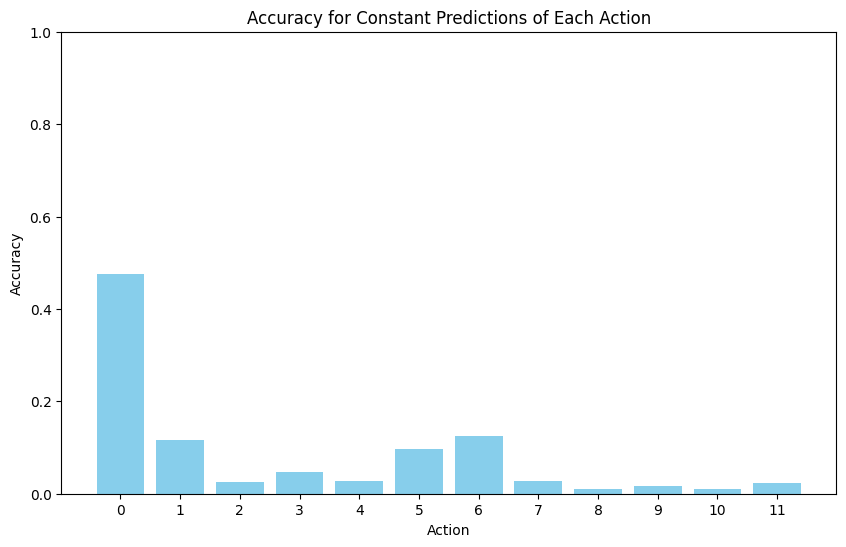

In [ ]:
# Combining training and validation labels
Cont_y_combined = np.concatenate((Cont_y_train, Cont_y_val))

#number of unique actions
num_actions = 12

# Initialize a dictionary to store accuracy for each action
action_accuracy_combined = {}

# Loop over each action (0 to num_actions-1)
for action in range(num_actions):
    # Create a constant array of predictions, all set to the current action
    constant_prediction_combined = np.full_like(Cont_y_combined, action)

    # Calculate accuracy for this constant prediction
    acc_combined = accuracy_score(Cont_y_combined, constant_prediction_combined)

    # Store the result
    action_accuracy_combined[action] = acc_combined

# Printing the accuracies for each action
print("Combined Accuracies for Static Predictions:")
for action, acc in action_accuracy_combined.items():
    print(f'Accuracy if always predicting action {action}: {acc:.4f}')

# plot the accuracies for combined dataset
plt.figure(figsize=(10, 6))
plt.bar(action_accuracy_combined.keys(), action_accuracy_combined.values(), color='skyblue')
plt.xlabel('Action')
plt.ylabel('Accuracy')
plt.title('Accuracy for Constant Predictions of Each Action')
plt.xticks(range(num_actions))
plt.ylim(0, 1)
plt.show()


###iii) GLM which predicts using only the previous action (last 13 values of gamestate)

Shape of Cont_X_train_last13: (164038, 13)
Shape of Cont_X_val_last13: (39411, 13)
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.2600 - loss: 2.2593 - val_accuracy: 0.5649 - val_loss: 1.8117
Epoch 2/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5747 - loss: 1.7008 - val_accuracy: 0.5641 - val_loss: 1.5486
Epoch 3/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.5763 - loss: 1.4870 - val_accuracy: 0.5788 - val_loss: 1.4743
Epoch 4/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.5841 - loss: 1.4352 - val_accuracy: 0.5868 - val_loss: 1.4453
Epoch 5/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.5903 - loss: 1.4058 - val_accuracy: 0.5868 - val_loss: 1.4304
Epoch 6/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.5896 - loss: 1.3990 - val_accuracy: 0.5885 - val_loss: 1.4214
Epoch 7/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.5916 - loss: 1.3912 - val_accuracy: 0.5917 - val_loss: 1.4155
Epoch 8/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.5956 - loss: 1.3871 - val

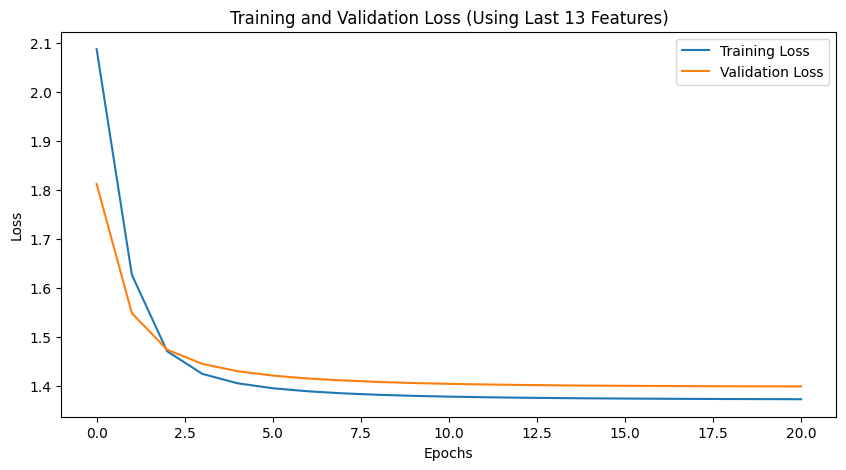

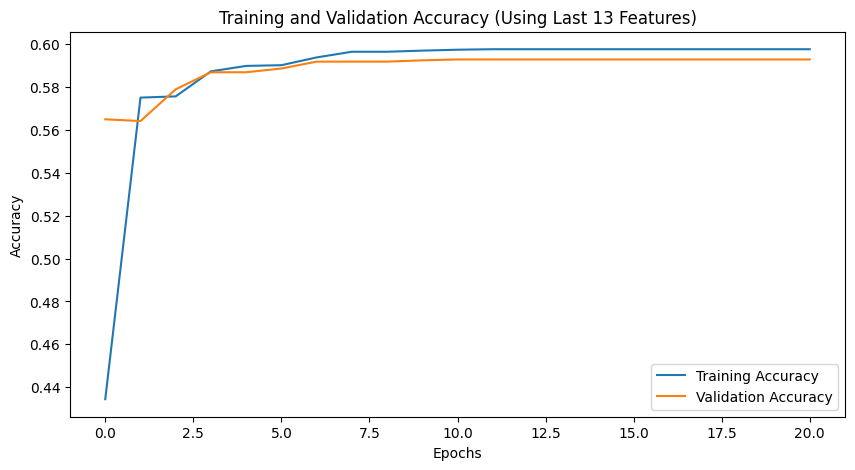

In [ ]:
# Slice dataset to use only the last 13 elements of board states for training
Cont_X_train_last13 = Cont_X_train[:, -13:]
Cont_X_val_last13 = Cont_X_val[:, -13:]

# Check the shapes
print("Shape of Cont_X_train_last13:", Cont_X_train_last13.shape)
print("Shape of Cont_X_val_last13:", Cont_X_val_last13.shape)

# Build the GLM model
control_model = Sequential([
    Dense(num_actions, input_shape=(13,), activation='softmax')  #Same number of actions as before (12)
])

# Defining the optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compiling the model
control_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fitting the model with early stopping
control1_history = control_model.fit(
    Cont_X_train_last13, Cont_y_train,
    epochs=50,
    validation_data=(Cont_X_val_last13, Cont_y_val),
    batch_size=32,
    callbacks=[early_stopping]
)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(control1_history.history['loss'], label='Training Loss')
plt.plot(control1_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Using Last 13 Features)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(control1_history.history['accuracy'], label='Training Accuracy')
plt.plot(control1_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Using Last 13 Features)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
Cont_val_loss, Cont_val_acc = control_model.evaluate(Cont_X_val_last13, Cont_y_val)
print(f'Validation Loss: {Cont_val_loss}')
print(f'Validation Accuracy: {Cont_val_acc}')

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6073 - loss: 1.3582
Validation Loss: 1.4046040773391724
Validation Accuracy: 0.5927532911300659


###iv) GLM which predicts using only the board state (first 72 values of gamestate)

Epoch 1/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.3370 - loss: 2.3085 - val_accuracy: 0.4701 - val_loss: 1.8960
Epoch 2/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.4870 - loss: 1.7837 - val_accuracy: 0.4762 - val_loss: 1.6226
Epoch 3/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.5021 - loss: 1.5554 - val_accuracy: 0.5413 - val_loss: 1.5251
Epoch 4/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5596 - loss: 1.4693 - val_accuracy: 0.5610 - val_loss: 1.4802
Epoch 5/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5788 - loss: 1.4272 - val_accuracy: 0.5745 - val_loss: 1.4555
Epoch 6/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.5866 - loss: 1.4079 - val_accuracy: 0.5761 - val_loss: 1.4406
Epoch 7/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.5852 - loss: 1.4022 - val_accuracy: 0.5784 - val_loss: 1.4310
Epoch 8/50
5127/5127 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.5918 - loss: 1

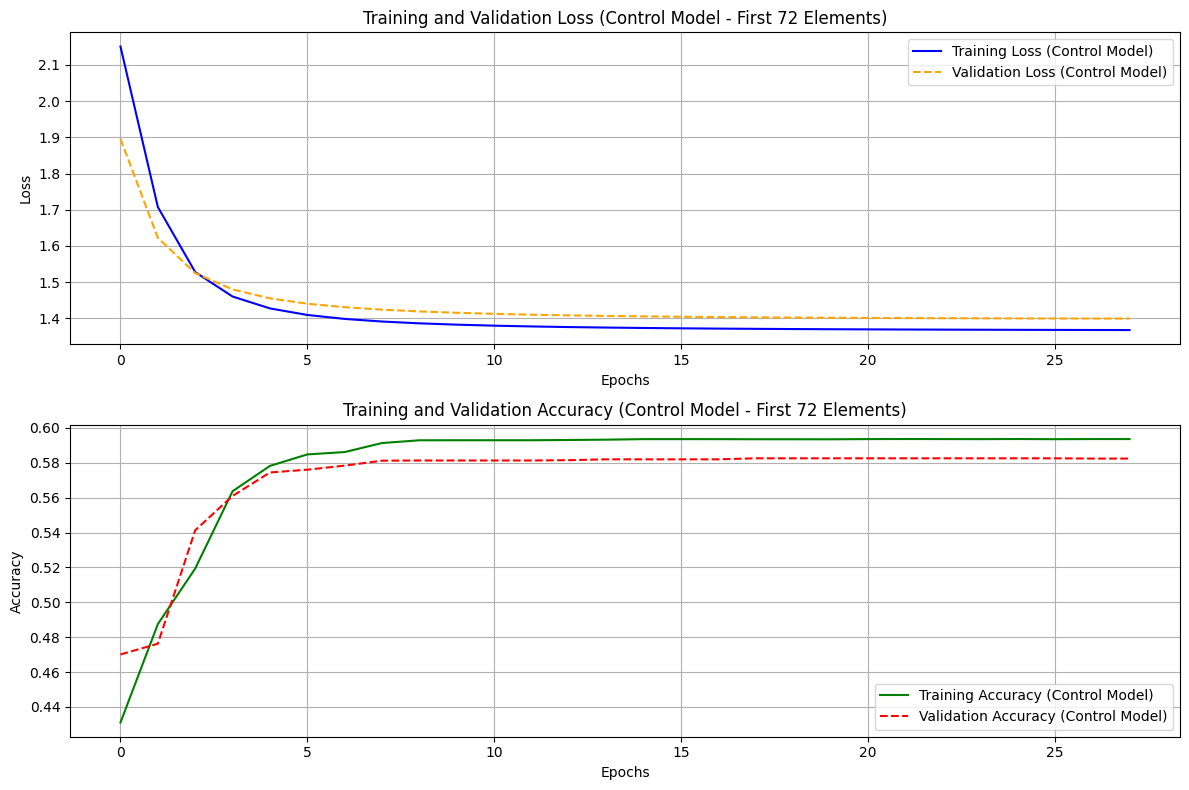

In [ ]:
# Slice to use only the last 13 elements of board states for training
Cont_X_train_first72 = Cont_X_train[:, :72]
Cont_X_val_first72 = Cont_X_val[:, :72]

# Build the control model with adjusted input shape
control_model2 = Sequential([
    Dense(num_actions, input_shape=(72,), activation='softmax')
])

# Defining the optimizer with a custom learning rate
optimizer_control = tf.keras.optimizers.Adam(learning_rate=0.0001)

# compliling control model
control_model2.compile(optimizer=optimizer_control, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping callback
early_stopping_control = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fit the control model with early stopping
history_control2 = control_model2.fit(
    Cont_X_train_first72, Cont_y_train,
    epochs=50,
    validation_data=(Cont_X_val_first72, Cont_y_val),
    batch_size=32,
    callbacks=[early_stopping_control]
)
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(history_control2.history['loss'], label='Training Loss (Control Model)', color='blue')
plt.plot(history_control2.history['val_loss'], label='Validation Loss (Control Model)', color='orange', linestyle='--')
plt.title('Training and Validation Loss (Control Model - First 72 Elements)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot training and validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(history_control2.history['accuracy'], label='Training Accuracy (Control Model)', color='green')
plt.plot(history_control2.history['val_accuracy'], label='Validation Accuracy (Control Model)', color='red', linestyle='--')
plt.title('Training and Validation Accuracy (Control Model - First 72 Elements)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
Cont_val_loss, Cont_val_acc = control_model2.evaluate(Cont_X_val_first72, Cont_y_val)
print(f'Validation Loss: {Cont_val_loss}')
print(f'Validation Accuracy: {Cont_val_acc}')

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6113 - loss: 1.3266
Validation Loss: 1.4030174016952515
Validation Accuracy: 0.5826038122177124


###v) Isolating role of Non-linearity: Dense network with one hidden dense layer

In [ ]:
# Determine the number of unique actions for the output layer size
num_actions = 12#len(np.unique(Cont_y))

# Build the model with an additional hidden layer
control_model3 = Sequential([
    Dense(64, input_shape=(85,), activation='relu'),  # Hidden layer with ReLU activation
    Dense(num_actions, activation='softmax')          # Output layer for classification
])

# Defining the optimizer with our custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compiling model
control_model3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Adding early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fitting the model with early stopping
history_control3 = control_model3.fit(
    Cont_X_train, Cont_y_train,
    epochs=50,
    validation_data=(Cont_X_val, Cont_y_val),
    batch_size=32,
    callbacks=[early_stopping]
)


In [ ]:
val_loss, val_accuracy = control_model3.evaluate(Cont_X_val, Cont_y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 8))

# Plot for Loss
plt.subplot(2, 1, 1)
plt.plot(history_control3.history['loss'], label='Training Loss (Control Model)', color='blue')
plt.plot(history_control3.history['val_loss'], label='Validation Loss (Control Model)', color='orange', linestyle='--')
plt.title('Training and Validation Loss (Control Model with hidden dense layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot for Accuracy
plt.subplot(2, 1, 2)
plt.plot(history_control3.history['accuracy'], label='Training Accuracy (Control Model)', color='green')
plt.plot(history_control3.history['val_accuracy'], label='Validation Accuracy (Control Model)', color='red', linestyle='--')
plt.title('Training and Validation Accuracy (Control Model with hidden dense layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


####Precision and Recall

In [ ]:
#Get model predictions
y_pred_proba = control_model3.predict(Cont_X_val)  # Predictions in probability format
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert to class labels

#Calculate precision and recall for each class
precision = precision_score(Cont_y_val, y_pred, average=None)  # Precision per class
recall = recall_score(Cont_y_val, y_pred, average=None)        # Recall per class

print("Precision for each class (action):", precision)
print("Recall for each class (action):", recall)

####Confusion matrix

In [ ]:
#Generate confusion matrix
cm = confusion_matrix(Cont_y_val, y_pred)

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Action {i}' for i in range(num_actions)],
            yticklabels=[f'Action {i}' for i in range(num_actions)])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

####Visualize Biases

In [ ]:
# Access the Dense layer (output layer)
output_layer = control_model3.layers[-1]  # Last layer in the model

# Extract the biases (second element of the weights list)
biases = output_layer.get_weights()[1]

# Visualize the biases
plt.figure(figsize=(10, 6))
plt.bar(range(len(biases)), biases, color='blue')
plt.xlabel('Action Index', fontsize=14)
plt.ylabel('Bias Value', fontsize=14)
plt.title('Control with hidden layer Biases of the Output Layer', fontsize=16)
plt.xticks(range(len(biases)), labels=np.arange(len(biases)))
plt.show()

####Previous Action only (last 13 values)

In [ ]:
# Determine the number of unique actions for the output layer size
num_actions = 12#len(np.unique(Cont_y))

# Build the model with an additional hidden layer
control_model3_13 = Sequential([
    Dense(64, input_shape=(13,), activation='relu'),  # Hidden layer with ReLU activation
    Dense(num_actions, activation='softmax')          # Output layer for classification
])

# Define the optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
control_model3_13.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history_control3_13 = control_model3_13.fit(
    Cont_X_train_last13, Cont_y_train,
    epochs=50,
    validation_data=(Cont_X_val_last13, Cont_y_val),
    batch_size=32,
    callbacks=[early_stopping]
)

In [ ]:
val_loss, val_accuracy = control_model3_13.evaluate(Cont_X_val_last13, Cont_y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 8))

# Plot for Loss
plt.subplot(2, 1, 1)
plt.plot(history_control3_13.history['loss'], label='Training Loss (Control Model)', color='blue')
plt.plot(history_control3_13.history['val_loss'], label='Validation Loss (Control Model)', color='orange', linestyle='--')
plt.title('Training and Validation Loss (Control Model with hidden dense layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot for Accuracy
plt.subplot(2, 1, 2)
plt.plot(history_control3_13.history['accuracy'], label='Training Accuracy (Control Model)', color='green')
plt.plot(history_control3_13.history['val_accuracy'], label='Validation Accuracy (Control Model)', color='red', linestyle='--')
plt.title('Training and Validation Accuracy (Control Model with hidden dense layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


####Board state only (First 72 values)

In [ ]:
# Determine the number of unique actions for the output layer size
num_actions = 12#len(np.unique(Cont_y))

control_model3_72 = Sequential([
    Dense(64, input_shape=(72,), activation='relu'),
    Dense(num_actions, activation='softmax')
])

# Define the optimizer with our custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compiling the model
control_model3_72.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Adding early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Fitting the model with early stopping
history_control3_72 = control_model3_72.fit(
    Cont_X_train_first72, Cont_y_train,
    epochs=50,
    validation_data=(Cont_X_val_first72, Cont_y_val),
    batch_size=32,
    callbacks=[early_stopping]
)

In [ ]:
val_loss, val_accuracy = control_model3_72.evaluate(Cont_X_val_first72, Cont_y_val, verbose=1)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 8))

# Plot for Loss
plt.subplot(2, 1, 1)
plt.plot(history_control3_72.history['loss'], label='Training Loss (Control Model)', color='blue')
plt.plot(history_control3_72.history['val_loss'], label='Validation Loss (Control Model)', color='orange', linestyle='--')
plt.title('Training and Validation Loss (Control Model with hidden dense layer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot for Accuracy
plt.subplot(2, 1, 2)
plt.plot(history_control3_72.history['accuracy'], label='Training Accuracy (Control Model)', color='green')
plt.plot(history_control3_72.history['val_accuracy'], label='Validation Accuracy (Control Model)', color='red', linestyle='--')
plt.title('Training and Validation Accuracy (Control Model with hidden dense layer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Adjust layout and display
plt.tight_layout()
plt.show()


##d) Comparing controls

Additional comparison ahead in section 3) model comparison

In [ ]:
# Step 1: Retrieve histories for all models
histories = {
    "Control Model (gamestate)": glm_history.history,
    "Control Model (action only)": control1_history.history,
    "Control Model (board state only)": history_control2.history,
    "Control Model (Additional Hidden Layer)": history_control3.history,
}

# Step 2: Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
for model_name, history in histories.items():
    plt.plot(history['loss'], label=f'Training Loss ({model_name})')
    plt.plot(history['val_loss'], linestyle='--', label=f'Validation Loss ({model_name})')
plt.title('Training and Validation Loss Across Control Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=8)  # Make the legend smaller
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
for model_name, history in histories.items():
    plt.plot(history['accuracy'], label=f'Training Accuracy ({model_name})')
    plt.plot(history['val_accuracy'], linestyle='--', label=f'Validation Accuracy ({model_name})')
plt.title('Training and Validation Accuracy Across Control Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=8)  # Make the legend smaller
plt.grid(True)
plt.tight_layout()
plt.show()


#2) RNNs

##a) Transforming features/targets from 2D vectors to 3D tensors

In [ ]:
#!pip install optuna #this is for parameter search
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


convert 2D gamestate vectors into 3D gamestate tensors using padding

In [ ]:
max_len = 704  #Trundicating to 704

def pad_sequences(seq, max_len, pad_value=-1):
    # If the sequence is longer than max_len, truncate it
    if len(seq) > max_len:
        seq = seq[:max_len]
    # If the sequence is shorter than max_len, pad with vectors of pad_value
    padded_seq = seq + [np.full(85, pad_value)] * (max_len - len(seq))
    return np.array(padded_seq)

final_df['padded_sequences'] = final_df['board_states'].apply(lambda seq: pad_sequences(seq, max_len))

sequence_tensor = np.stack(final_df['padded_sequences'].values)

print(sequence_tensor.shape)  # (number of rows, max_len, 85)

# For action sequences, apply the same logic
def pad_action_sequences(seq, max_len, pad_value=12):
    # If the sequence is longer than max_len, truncate it
    if len(seq) > max_len:
        seq = seq[:max_len]
    # If the sequence is shorter than max_len, pad with the pad_value
    padded_seq = seq + [pad_value] * (max_len - len(seq))
    return np.array(padded_seq)

# Apply padding to each row
final_df['padded_action_sequences'] = final_df['action_sequences'].apply(lambda seq: pad_action_sequences(seq, max_len))

# Convert the padded action sequences into a tensor-like structure (NumPy array)
target_tensor = np.stack(final_df['padded_action_sequences'].values)

# Now target_tensor is a NumPy array suitable for feeding into an RNN
print(target_tensor.shape)
from sklearn.model_selection import train_test_split

(1649, 704, 85)
(1649, 704)


In [ ]:
# Perform train-test split (e.g., 80% training, 20% validation)
RNN_sequence_train, RNN_sequence_val, RNN_target_train, RNN_target_val = train_test_split(
    sequence_tensor,  # The input tensor (padded sequences)
    target_tensor,  # The target tensor (padded action sequences)
    test_size=0.2,  # 20% of the data will be used for validation
    random_state=42  # Set a random seed for reproducibility
)

# Check the shapes of the resulting splits
print("Training set shape (sequences):", RNN_sequence_train.shape)
print("Validation set shape (sequences):", RNN_sequence_val.shape)
print("Training set shape (targets):", RNN_target_train.shape)
print("Validation set shape (targets):", RNN_target_val.shape)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training set shape (sequences): (1319, 704, 85)
Validation set shape (sequences): (330, 704, 85)
Training set shape (targets): (1319, 704)
Validation set shape (targets): (330, 704)


##b) Defining Masked Loss and Accuracy

We need to define our loss and accuracy so that they are able to distinguish padding  

In [ ]:
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    # Create a mask to ignore the padding elements (12)
    mask = tf.not_equal(y_true, 12)

    # Replace 12s in y_true with 0s
    y_true_replaced = tf.where(tf.equal(y_true, 12), tf.zeros_like(y_true), y_true)

    # Compute the sparse categorical cross-entropy loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_replaced, y_pred, from_logits=False)

    # Debugging prints using tf.print
    #tf.print("Mask:", mask)  # Print the mask
    #tf.print("Loss before masking:", loss)  # Print the loss before applying the mask
    #tf.print("Masked Loss:", loss * tf.cast(mask, dtype=loss.dtype))  # Print the masked loss

    # Apply the mask to the loss
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    # To avoid division by zero, adding a small epsilon to the denominator
    return tf.reduce_sum(loss) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())

In [ ]:
def masked_accuracy(y_true, y_pred):
    # Create a mask to ignore the padding elements
    mask = tf.not_equal(y_true, 12)
    # Replace padding values (12) in y_true with 0, which doesn't affect accuracy as masked out
    y_true_replaced = tf.where(tf.equal(y_true, 12), tf.zeros_like(y_true), y_true)

    # Cast y_true_replaced to int32 to match y_pred_classes
    y_true_replaced = tf.cast(y_true_replaced, tf.int32)

    # Get predicted class by taking the argmax
    y_pred_classes = tf.argmax(y_pred, axis=-1, output_type=tf.int32)

    # Compare predictions to true values and apply the mask
    correct_predictions = tf.equal(y_true_replaced, y_pred_classes)
    correct_predictions = tf.cast(correct_predictions, tf.float32)
    mask = tf.cast(mask, tf.float32)

    # Mask out padding values
    masked_correct_predictions = correct_predictions * mask

    # Compute accuracy by dividing by the number of non-padded elements
    accuracy = tf.reduce_sum(masked_correct_predictions) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())
    return accuracy


##c) RNNs 1-3: Gamestate

###i) RNN1: 1 hidden LSTM layer

In [ ]:
num_actions = 12
max_len = 704

# Build the LSTM model
RNN1 = Sequential([
    # Masking layer to ignore the padding (-1) in sequences
    Masking(mask_value=-1, input_shape=(None, 85)),
    LSTM(64, return_sequences=True, activation='tanh'),
    Dense(num_actions, activation='softmax')
])

# Define the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model with the custom optimizer and loss function
RNN1.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
RNN_history = RNN1.fit(
    RNN_sequence_train,  # padded input tensor
    RNN_target_train,    # padded target tensor
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    # shuffle=True
)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 654ms/step - loss: 1.0381 - masked_accuracy: 0.6729 - val_loss: 1.0420 - val_masked_accuracy: 0.6817
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 604ms/step - loss: 1.0236 - masked_accuracy: 0.6800 - val_loss: 1.0366 - val_masked_accuracy: 0.6819
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 810ms/step - loss: 1.0196 - masked_accuracy: 0.6789 - val_loss: 1.0272 - val_masked_accuracy: 0.6837
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 586ms/step - loss: 1.0157 - masked_accuracy: 0.6819 - val_loss: 1.0247 - val_masked_accuracy: 0.6869
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 602ms/step - loss: 1.0180 - masked_accuracy: 0.6809 - val_loss: 1.0199 - val_masked_accuracy: 0.6876
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 606ms/step - loss: 0.9941 - masked_accuracy: 0.6887 - val_loss: 1.0210 - val_masked_accuracy: 0.6871
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 641ms/step - loss: 1.0216 - masked_accuracy: 0.6776 - val_loss: 1.0158 - val_masked_accuracy:

In [ ]:
# Evaluate the model on the validation set
RNN_val_loss, RNN_val_acc = RNN1.evaluate(RNN_sequence_val, RNN_target_val, verbose=1)

print(f'Validation Loss: {RNN_val_loss}')
print(f'Validation Accuracy: {RNN_val_acc}')


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - loss: 1.1041 - masked_accuracy: 0.6528
Validation Loss: 1.0495879650115967
Validation Accuracy: 0.6777684092521667


In [ ]:
# Retrieve the history dictionary
RNN1_history = RNN_history.history

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(RNN1_history['loss'], label='Training Loss')
plt.plot(RNN1_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(RNN1_history['masked_accuracy'], label='Training Accuracy')
plt.plot(RNN1_history['val_masked_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

####Visualize Bias

In [ ]:
# Access the Dense layer (output layer)
output_layer = RNN1.layers[-1]

# Get the biases (second element of weights)
biases = output_layer.get_weights()[1]

# Visualize biases
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(biases)), biases, color='blue')
plt.xlabel('Action Index', fontsize=14)
plt.ylabel('Bias Value', fontsize=14)
plt.title('Biases of RNN Output Layer', fontsize=16)
plt.xticks(np.arange(len(biases)), labels=np.arange(len(biases)))
plt.show()


####precision and recall

In [ ]:
RNN1.predict(RNN_sequence_val).shape

In [ ]:
np.argmax(RNN1.predict(RNN_sequence_val), axis=-1).shape


In [ ]:
# Get predicted actions - the class with the highest probability for each timestep
 y_pred_classes = np.argmax(RNN1.predict(RNN_sequence_val), axis=-1)  # Shape: (12779, 13)

# Flatten the arrays to calculate for each class across all timesteps
y_true_flat = RNN_target_val.flatten()  # Shape: (12779 * 13,)
y_pred_flat = y_pred_classes.flatten()  # Shape: (12779 * 13,)

precision = precision_score(y_true_flat, y_pred_flat, average=None, labels=np.arange(12))
recall = recall_score(y_true_flat, y_pred_flat, average=None, labels=np.arange(12))

print("Precision for each class (action):")
print(precision)
print("Recall for each class (action):")
print(recall)

####confusion matrix

track how often each predicted action matches the true action for each timestep in the sequence

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step


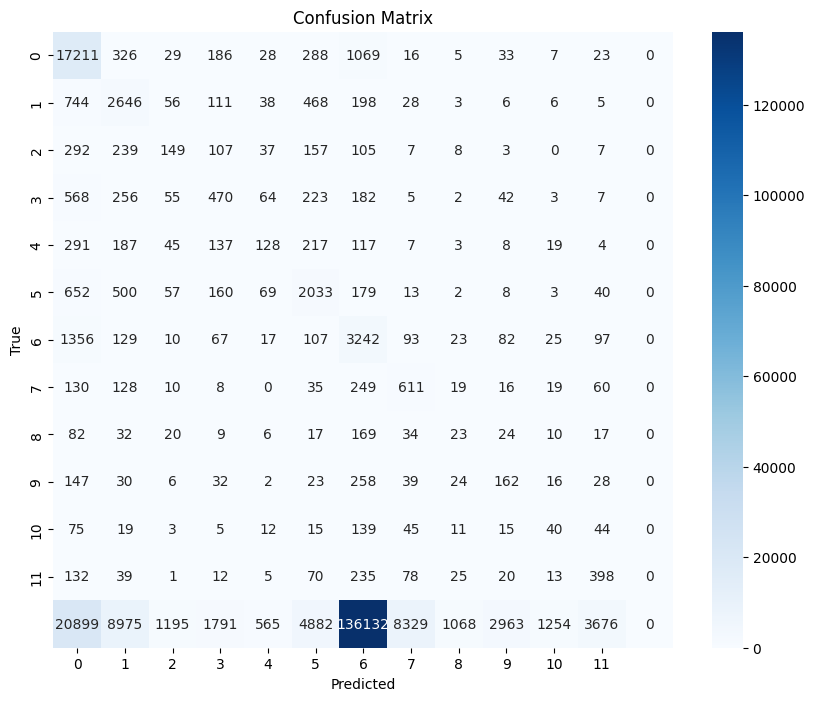

In [ ]:
#Get the predicted class (argmax along the last axis for each sequence)
predicted_classes = np.argmax(RNN1.predict(RNN_sequence_val), axis=-1)  # Shape: (12779, 13)

#Flatten the arrays to 1D
predicted_classes_flat = predicted_classes.flatten()  # Flatten to (12779 * 13)
true_classes_flat = RNN_target_val.flatten()  # Flatten to (12779 * 13)

#Compute confusion matrix
cm = confusion_matrix(true_classes_flat, predicted_classes_flat)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=np.arange(12), yticklabels=np.arange(12))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

####parameter search

manually trains multiple RNN models with different LSTM unit sizes to compare their validation accuracy

In [ ]:
# # Number of actions and max sequence length
# num_actions = 12
# max_len = 13

# # Learning rate
# learning_rate = 0.00025933707332929695

# # Hidden layer sizes (LSTM units in this case)
# hidden_layer_sizes = [2**i for i in range(3, 9)]

# # Store the results for each model configuration
# results = []



# for size in hidden_layer_sizes:
#     print(f"Training model with {size} LSTM units...")

#     # Build the RNN model with LSTM layer
#     model = Sequential([
#         Masking(mask_value=-1, input_shape=(None, 85)),  # Masking layer for padded sequences
#         LSTM(size, return_sequences=True, activation='tanh'),  # LSTM layer with variable units
#         Dense(num_actions, activation='softmax')  # Output layer for action classification
#     ])

#     # Define the optimizer
#     optimizer = Adam(learning_rate=learning_rate)

#     # Compile the model with custom loss and accuracy functions
#     model.compile(optimizer=optimizer, loss=masked_sparse_categorical_crossentropy, metrics=[masked_accuracy])

#     # Updated EarlyStopping callback to monitor val_masked_accuracy
#     # Set up early stopping with mode='max'
#     early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=5, restore_best_weights=True)

# # Train the model with early stopping
#     RNN_history = model.fit(
#         RNN_sequence_train, RNN_target_train,
#         epochs=50,
#         batch_size=32,
#         validation_data=(RNN_sequence_val, RNN_target_val),
#         callbacks=[early_stopping],
#         verbose=0
#     )

#     # Evaluate the model on the validation set
#     val_accuracy = model.evaluate(RNN_sequence_val, RNN_target_val, verbose=0)[1]
#     print(f"Validation accuracy for {size} LSTM units: {val_accuracy}")

#     # Store the result
#     results.append({'lstm_units': size, 'val_accuracy': val_accuracy})

# # Display the results
# for result in results:
#     print(f"LSTM units: {result['lstm_units']}, Validation Accuracy: {result['val_accuracy']}")


best combination of LSTM units and learning rate that maximizes validation accuracy.

In [ ]:
# import optuna


# # Define the Optuna objective function
# def objective(trial):
#     # Suggest a learning rate between 0.0001 and 0.01
#     learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.01)

#     # Suggest the number of LSTM units (e.g., between 32 and 256)
#     lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128, 256])

#     # Build the model
#     model = Sequential([
#         Masking(mask_value=-1, input_shape=(None, 85)),  # Input shape (None, 85 features)
#         LSTM(lstm_units, return_sequences=True, activation='tanh'),  # Use the number of LSTM units suggested by Optuna
#         Dense(num_actions, activation='softmax')  # Output layer for classification
#     ])

#     # Compile the model using the suggested learning rate
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss=masked_sparse_categorical_crossentropy, metrics=['accuracy'])

#     # Train the model
#     history = model.fit(
#         RNN_sequence_train,  # Training sequences
#         RNN_target_train,    # Training targets
#         epochs=19,           # Fixed number of epochs
#         batch_size=32,       # Fixed batch size
#         validation_split=0.2,  # 20% of data used for validation
#         verbose=0            # Suppress verbose output
#     )

#     # Get the validation accuracy of the model
#     val_accuracy = history.history['val_accuracy'][-1]  # Get the last epoch's validation accuracy

#     # Return the validation accuracy as the objective value
#     return val_accuracy

# # Create an Optuna study to maximize the validation accuracy
# study = optuna.create_study(direction='maximize')

# # Optimize the study for a given number of trials (e.g., 50 trials)
# study.optimize(objective, n_trials=50)

# # Print the best trial's parameters
# print("Best trial:")
# trial = study.best_trial
# print(f"  Value: {trial.value}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")


###ii) RNN2: 2 Hidden LSTM layers

In [ ]:
num_actions = 12
max_len = 704

# Build the LSTM model
RNN2 = Sequential([
    # Masking layer to ignore the padding (-1) in sequences
    Masking(mask_value=-1, input_shape=(None, 85)),

    # First LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Second LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification
    Dense(num_actions, activation='softmax')  # Output layer for predicting the next action
])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
# Compile the model with adam optimizer and sparse categorical crossentropy
#model2.compile(optimizer='adam', loss=masked_sparse_categorical_crossentropy, metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

RNN2.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
RNN2_history = RNN2.fit(
    RNN_sequence_train,  # Padded input tensor
    RNN_target_train,    # Padded target tensor
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],  # Include the EarlyStopping callback here
    # shuffle=True  # Uncomment if you want to shuffle the training data
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 1.8087 - masked_accuracy: 0.4658 - val_loss: 1.4096 - val_masked_accuracy: 0.5628
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 1.3635 - masked_accuracy: 0.5764 - val_loss: 1.2365 - val_masked_accuracy: 0.5964
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 1.1637 - masked_accuracy: 0.6449 - val_loss: 1.1383 - val_masked_accuracy: 0.6481
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - loss: 1.1221 - masked_accuracy: 0.6545 - val_loss: 1.0922 - val_masked_accuracy: 0.6695
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 1.0632 - masked_accuracy: 0.6740 - val_loss: 1.0697 - val_masked_accuracy: 0.6747
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 1.0504 - masked_accuracy: 0.6735 - val_loss: 1.0576 - val_masked_accuracy: 0.6785
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 1.0486 - masked_accuracy: 0.6713 - val_loss: 1.0462 - val_masked_accuracy: 0.6798
Epoch 8/50
33/33 ━━━

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = RNN2.evaluate(
    RNN_sequence_val,
    RNN_target_val,
    batch_size=32
)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - loss: 1.1038 - masked_accuracy: 0.6544
Validation Loss: 1.0492393970489502
Validation Accuracy: 0.6793577671051025


####Confusion Marix

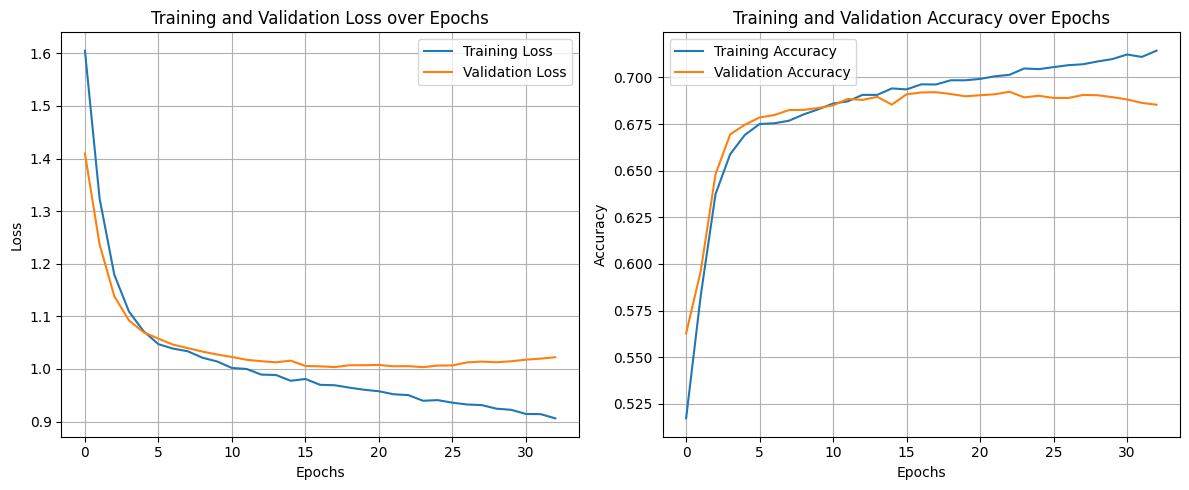

In [ ]:
# Retrieve the history dictionary
RNN2_history_dict = RNN2_history.history  # Access the history attribute

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(RNN2_history_dict['loss'], label='Training Loss')
plt.plot(RNN2_history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(RNN2_history_dict['masked_accuracy'], label='Training Accuracy')
plt.plot(RNN2_history_dict['val_masked_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


confusion matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision for each class (action): [0.41341835 0.23846501 0.09101942 0.14278705 0.12825651 0.256917
 0.02273574 0.05295871 0.02597403 0.0489762  0.02101486 0.09534417
 0.        ]
Recall for each class (action): [0.89058842 0.61290323 0.1350135  0.31006926 0.11006019 0.54224973
 0.61623476 0.48404669 0.07223476 0.23076923 0.09692671 0.41634241
 0.        ]


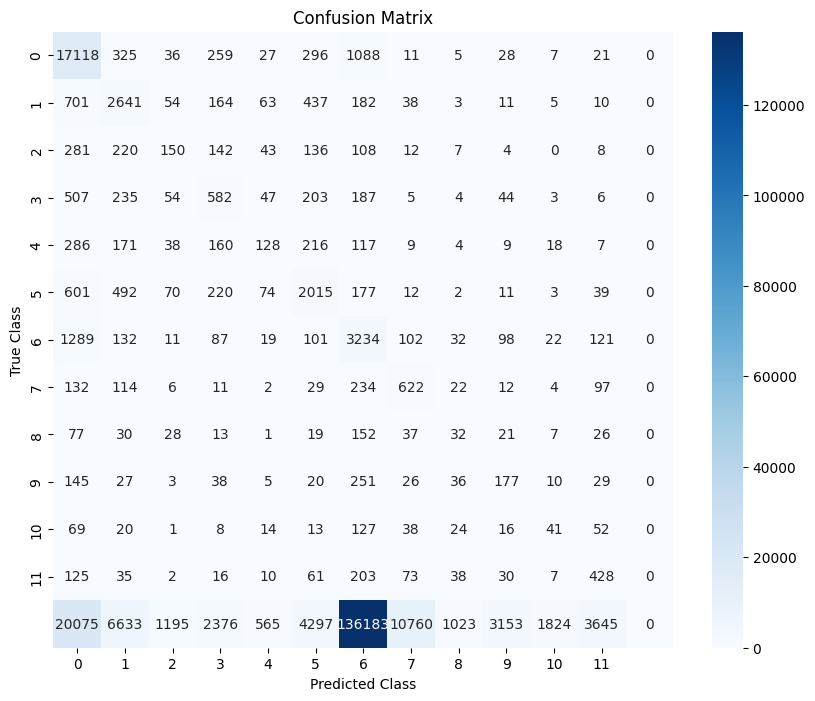

In [ ]:
# Step 1: Make predictions on the validation set
y_pred_proba = RNN2.predict(RNN_sequence_val)  # shape (num_sequences, max_len, num_actions)
y_pred = np.argmax(y_pred_proba, axis=-1)  # shape (num_sequences, max_len)

# Step 2: Flatten predictions and true labels
y_pred_flat = y_pred.flatten()
y_true_flat = RNN_target_val.flatten()

# Mask out padding values (-1) from both y_pred_flat and y_true_flat
mask = (y_true_flat != -1)
y_pred_flat = y_pred_flat[mask]
y_true_flat = y_true_flat[mask]

# Step 3: Calculate precision and recall for each class
precision = precision_score(y_true_flat, y_pred_flat, average=None)
recall = recall_score(y_true_flat, y_pred_flat, average=None)

print("Precision for each class (action):", precision)
print("Recall for each class (action):", recall)

# Step 4: Generate and display confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_actions), yticklabels=np.arange(num_actions))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


### RNN3: 3 hidden LSTM layers

In [ ]:
num_actions = 12
#max_len = 704

# Build the LSTM model
RNN3 = Sequential([
    # Masking layer to ignore the padding (-1) in sequences
    Masking(mask_value=-1, input_shape=(None, 85)),

    # First LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Second LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Third LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification
    Dense(num_actions, activation='softmax')  # Output layer for predicting the next action
])

# Compile the model with adam optimizer and sparse categorical crossentropy
#model3.compile(optimizer='adam', loss=masked_sparse_categorical_crossentropy, metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

RNN3.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
RNN3_history = RNN3.fit(
    RNN_sequence_train,  #padded input tensor
    RNN_target_train,    #padded target tensor
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    #shuffle=True
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - loss: 1.8723 - masked_accuracy: 0.4285 - val_loss: 1.5048 - val_masked_accuracy: 0.5380
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 1.4433 - masked_accuracy: 0.5503 - val_loss: 1.3404 - val_masked_accuracy: 0.5759
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 1.3441 - masked_accuracy: 0.5698 - val_loss: 1.2123 - val_masked_accuracy: 0.6290
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - loss: 1.1767 - masked_accuracy: 0.6346 - val_loss: 1.1552 - val_masked_accuracy: 0.6445
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 1.1042 - masked_accuracy: 0.6587 - val_loss: 1.1031 - val_masked_accuracy: 0.6668
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - loss: 1.0964 - masked_accuracy: 0.6637 - val_loss: 1.0757 - val_masked_accuracy: 0.6742
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - loss: 1.0653 - masked_accuracy: 0.6692 - val_loss: 1.0668 - val_masked_accuracy: 0.6771
Epoch 8/50
33/33 ━━━

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = RNN3.evaluate(
    RNN_sequence_val,
    RNN_target_val,
    batch_size=32
)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 364ms/step - loss: 1.1133 - masked_accuracy: 0.6520
Validation Loss: 1.0588709115982056
Validation Accuracy: 0.6760014891624451


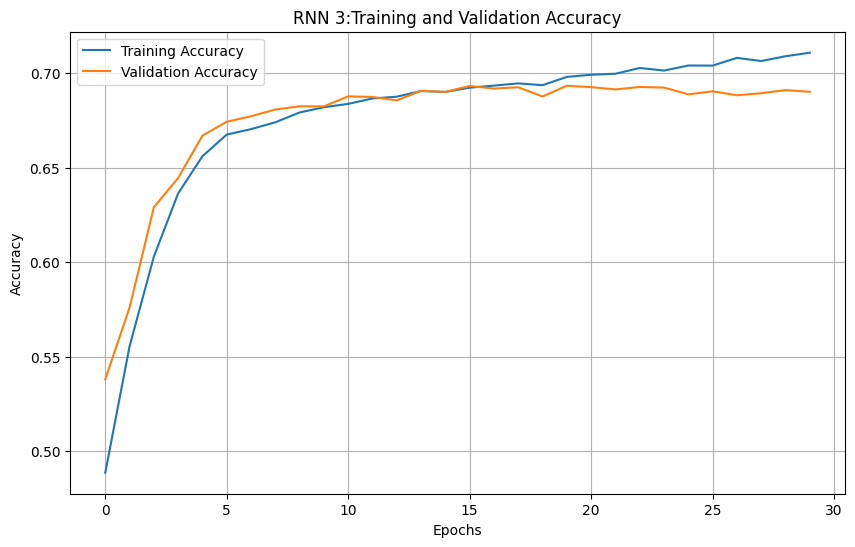

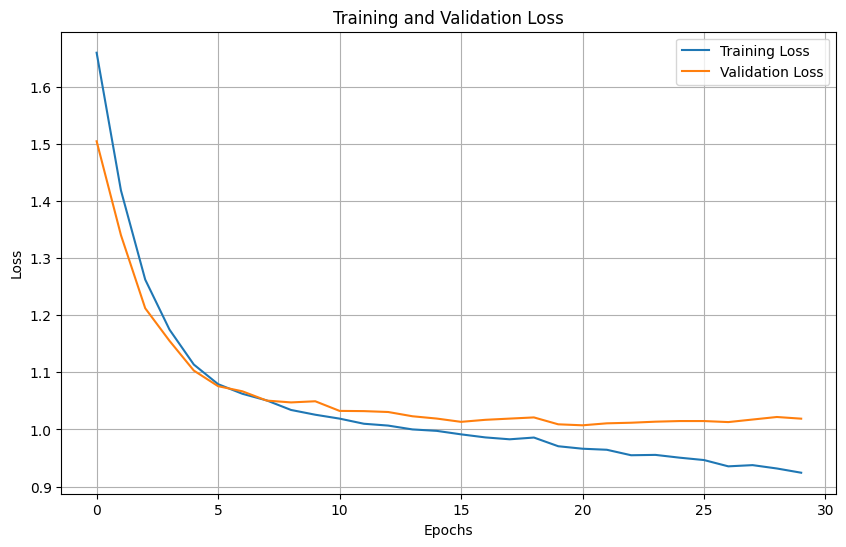

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(RNN3_history.history['masked_accuracy'], label='Training Accuracy')
plt.plot(RNN3_history.history['val_masked_accuracy'], label='Validation Accuracy')
plt.title('RNN 3:Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(RNN3_history.history['loss'], label='Training Loss')
plt.plot(RNN3_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### confusion matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 475ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision for each class (action): [0.40943896 0.26511675 0.06245408 0.15577104 0.06491003 0.25104232
 0.02270089 0.04795073 0.02692308 0.06678461 0.01649337 0.07841098
 0.        ]
Recall for each class (action): [0.90135789 0.60338826 0.07650765 0.265317   0.08684437 0.53471475
 0.61490091 0.50894942 0.03160271 0.19687093 0.10874704 0.36673152
 0.        ]


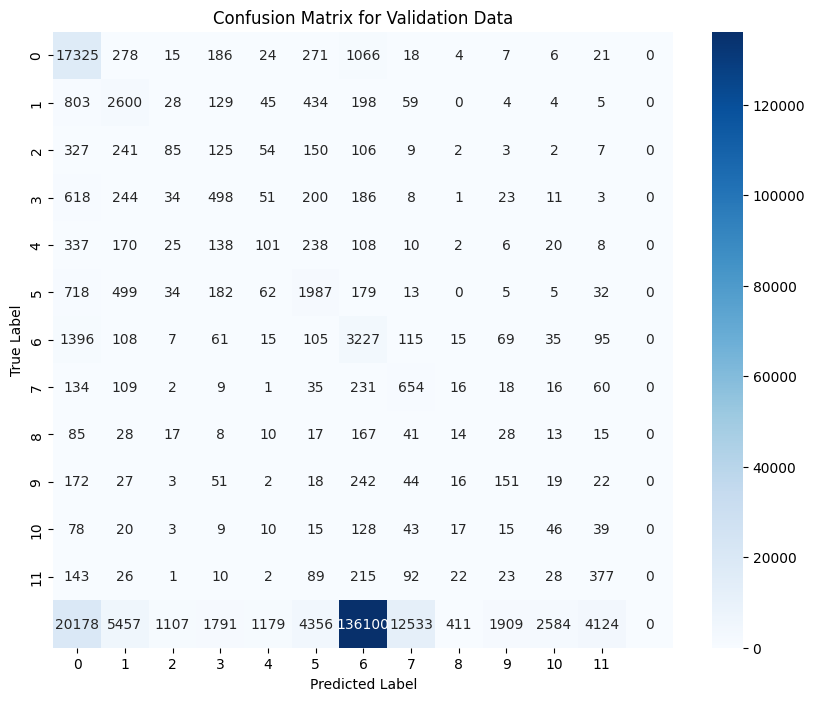

In [ ]:
# Generate predictions on the validation set
val_predictions = RNN3.predict(RNN_sequence_val)
val_predictions_classes = np.argmax(val_predictions, axis=-1)  # Predicted class for each timestep

# Flatten both predictions and true labels
val_target_flat = RNN_target_val.flatten()
val_pred_flat = val_predictions_classes.flatten()

# Filter out padding values (-1) if used
mask = val_target_flat != -1
val_target_flat = val_target_flat[mask]
val_pred_flat = val_pred_flat[mask]

#Calculate precision and recall for each class
precision = precision_score(val_target_flat, val_pred_flat, average=None)
recall = recall_score(val_target_flat, val_pred_flat, average=None)

# Print precision and recall
print("Precision for each class (action):", precision)
print("Recall for each class (action):", recall)

#Create and plot confusion matrix
conf_matrix = confusion_matrix(val_target_flat, val_pred_flat)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_actions), yticklabels=range(num_actions))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Data')
plt.show()


##d) RNNs 1-3: Previous Action Only

In [ ]:
# Step 1: Define a function to slice the last 13 elements of each board state
def slice_and_pad_board_states(board_states, max_len, slice_len=13, pad_value=-1):
    # Slice the last `slice_len` elements of each 85-element board state array
    sliced_states = [state[-slice_len:] for state in board_states]

    # If the sequence is longer than max_len, truncate it
    if len(sliced_states) > max_len:
        sliced_states = sliced_states[:max_len]

    # Pad the sequence to match `max_len` with vectors of `pad_value` if needed
    padded_seq = sliced_states + [np.full(slice_len, pad_value)] * (max_len - len(sliced_states))

    return np.array(padded_seq)

# Step 2: Apply the slicing and padding function to each row in `final_df['board_states']`
final_df['sliced_padded_sequences'] = final_df['board_states'].apply(lambda seq: slice_and_pad_board_states(seq, max_len))

# Convert to a NumPy array for RNN input
sequence_tensor = np.stack(final_df['sliced_padded_sequences'].values)
print(sequence_tensor.shape)  # Expected shape: (number of rows, max_len, 13)


(1649, 704, 13)


In [ ]:
# Splitting the data into training and validation sets
RNN_sequence_train_13, RNN_sequence_val_13, RNN_target_train_13, RNN_target_val_13 = train_test_split(
    sequence_tensor, target_tensor, test_size=0.2, random_state=42
)

print("Training sequence shape:", RNN_sequence_train.shape)
print("Validation sequence shape:", RNN_sequence_val.shape)
print("Training target shape:", RNN_target_train.shape)
print("Validation target shape:", RNN_target_val.shape)


Training sequence shape: (1319, 704, 85)
Validation sequence shape: (330, 704, 85)
Training target shape: (1319, 704)
Validation target shape: (330, 704)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###RNN1_13

In [ ]:
num_actions = 12

# Set up the LSTM model with the modified input shape (last 13 elements of board states)
RNN1_13 = Sequential([
    # Masking layer to ignore the padding (-1) in sequences
    Masking(mask_value=-1, input_shape=(None, 13)),  # Input shape now has 13 features

    # LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification/predicting tbe next action
    Dense(num_actions, activation='softmax')
])

# Define the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model with the custom optimizer and loss function
RNN1_13.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

# Train the model
RNN1_13_history = RNN1_13.fit(
    RNN_sequence_train_13,  # padded input tensor with (number of rows, max_len, 13)
    RNN_target_train_13,    # padded target tensor with (number of rows, max_len)
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 604ms/step - loss: 1.9076 - masked_accuracy: 0.4396 - val_loss: 1.4067 - val_masked_accuracy: 0.5750
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 551ms/step - loss: 1.3691 - masked_accuracy: 0.5890 - val_loss: 1.3316 - val_masked_accuracy: 0.5972
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 603ms/step - loss: 1.2898 - masked_accuracy: 0.6091 - val_loss: 1.2876 - val_masked_accuracy: 0.6069
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 535ms/step - loss: 1.2717 - masked_accuracy: 0.6088 - val_loss: 1.2385 - val_masked_accuracy: 0.6128
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 583ms/step - loss: 1.1968 - masked_accuracy: 0.6252 - val_loss: 1.1713 - val_masked_accuracy: 0.6436
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 635ms/step - loss: 1.1526 - masked_accuracy: 0.6422 - val_loss: 1.1410 - val_masked_accuracy: 0.6479
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 543ms/step - loss: 1.1354 - masked_accuracy: 0.6437 - val_loss: 1.1181 - val_masked_accuracy: 0.6554

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = RNN1_13.evaluate(RNN_sequence_val_13, RNN_target_val_13)

# Print the results
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 1.1407 - masked_accuracy: 0.6444
Validation Loss: 1.0855190753936768
Validation Accuracy: 0.6677305698394775


In [ ]:
# import numpy as np
# from sklearn.metrics import precision_score, recall_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Step 1: Generate predictions on the validation set
# val_predictions = RNN1_13.predict(RNN_sequence_val_13)
# val_predictions_classes = np.argmax(val_predictions, axis=-1)  # Predicted class for each timestep

# # Step 2: Flatten predictions and true labels
# val_target_flat = RNN_target_val.flatten()
# val_pred_flat = val_predictions_classes.flatten()

# # Step 3: Filter out padding values (-1) in both true and predicted labels
# mask = val_target_flat != -1
# val_target_flat = val_target_flat[mask]
# val_pred_flat = val_pred_flat[mask]

# # Step 4: Calculate precision and recall for each class
# precision = precision_score(val_target_flat, val_pred_flat, average=None)
# recall = recall_score(val_target_flat, val_pred_flat, average=None)

# # Print precision and recall for each action class
# print("Precision for each class (action):", precision)
# print("Recall for each class (action):", recall)

# # Step 5: Generate and plot the confusion matrix
# conf_matrix = confusion_matrix(val_target_flat, val_pred_flat)

# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=range(num_actions), yticklabels=range(num_actions))
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for Validation Data')
# plt.show()


###RNN2_13

In [ ]:
num_actions = 12
max_len = 704

# Build the LSTM model
RNN2_13 = Sequential([
    # Masking layer to ignore the padding (-1) in your sequences
    Masking(mask_value=-1, input_shape=(None, 13)),  # 85 is the number of features (dims in input tensor)

    # First LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Second LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification/predicting the next action
    Dense(num_actions, activation='softmax')
])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
# Compile the model with adam optimizer and sparse categorical crossentropy
#model2.compile(optimizer='adam', loss=masked_sparse_categorical_crossentropy, metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

RNN2_13.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
RNN2_13_history = RNN2_13.fit(
    RNN_sequence_train,  # padded input tensor with (number of rows, max_len, 13)
    RNN_target_train,    # padded target tensor with (number of rows, max_len)
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - loss: 1.7978 - masked_accuracy: 0.4653 - val_loss: 1.4186 - val_masked_accuracy: 0.5628
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 1.3752 - masked_accuracy: 0.5759 - val_loss: 1.3390 - val_masked_accuracy: 0.5870
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 1.2891 - masked_accuracy: 0.6074 - val_loss: 1.2846 - val_masked_accuracy: 0.6063
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 1.2955 - masked_accuracy: 0.5983 - val_loss: 1.2416 - val_masked_accuracy: 0.6105
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 1.2291 - masked_accuracy: 0.6099 - val_loss: 1.1642 - val_masked_accuracy: 0.6145
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 1.1309 - masked_accuracy: 0.6477 - val_loss: 1.1235 - val_masked_accuracy: 0.6568
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 1.1081 - masked_accuracy: 0.6533 - val_loss: 1.1107 - val_masked_accuracy: 0.6583
Epoch 8/50
33/33 ━━

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = RNN2_13.evaluate(RNN_sequence_val, RNN_target_val)

# Print the results
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - loss: 1.1374 - masked_accuracy: 0.6444
Validation Loss: 1.0832926034927368
Validation Accuracy: 0.6676082611083984


###RNN3_13

In [ ]:
num_actions = 12
max_len = 704

# Build the LSTM model
RNN3_13 = Sequential([
    # Masking layer to ignore the padding (-1) in sequences
    Masking(mask_value=-1, input_shape=(None, 13)),  # 85 is the number of features (dims in input tensor)

    # First LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Second LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Third LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification/predicting the next action
    Dense(num_actions, activation='softmax')
])

# Compile the model with adam optimizer and sparse categorical crossentropy
#model3.compile(optimizer='adam', loss=masked_sparse_categorical_crossentropy, metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

RNN3_13.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

In [ ]:
RNN3_13_history = RNN3_13.fit(
    RNN_sequence_train,  #padded input tensor
    RNN_target_train,    #padded target tensor
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    #shuffle=True
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 1.8457 - masked_accuracy: 0.4508 - val_loss: 1.4637 - val_masked_accuracy: 0.5491
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 1.4270 - masked_accuracy: 0.5594 - val_loss: 1.3592 - val_masked_accuracy: 0.5803
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - loss: 1.3494 - masked_accuracy: 0.5821 - val_loss: 1.2951 - val_masked_accuracy: 0.6000
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 1.2756 - masked_accuracy: 0.6023 - val_loss: 1.2675 - val_masked_accuracy: 0.6038
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - loss: 1.2198 - masked_accuracy: 0.6201 - val_loss: 1.1867 - val_masked_accuracy: 0.6437
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - loss: 1.1733 - masked_accuracy: 0.6401 - val_loss: 1.1514 - val_masked_accuracy: 0.6489
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - loss: 1.1375 - masked_accuracy: 0.6440 - val_loss: 1.1261 - val_masked_accuracy: 0.6504
Epoch 8/50
33/33 ━━━

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = RNN3_13.evaluate(RNN_sequence_val, RNN_target_val)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step - loss: 1.1450 - masked_accuracy: 0.6459
Validation Loss: 1.0873080492019653
Validation Accuracy: 0.6701014637947083


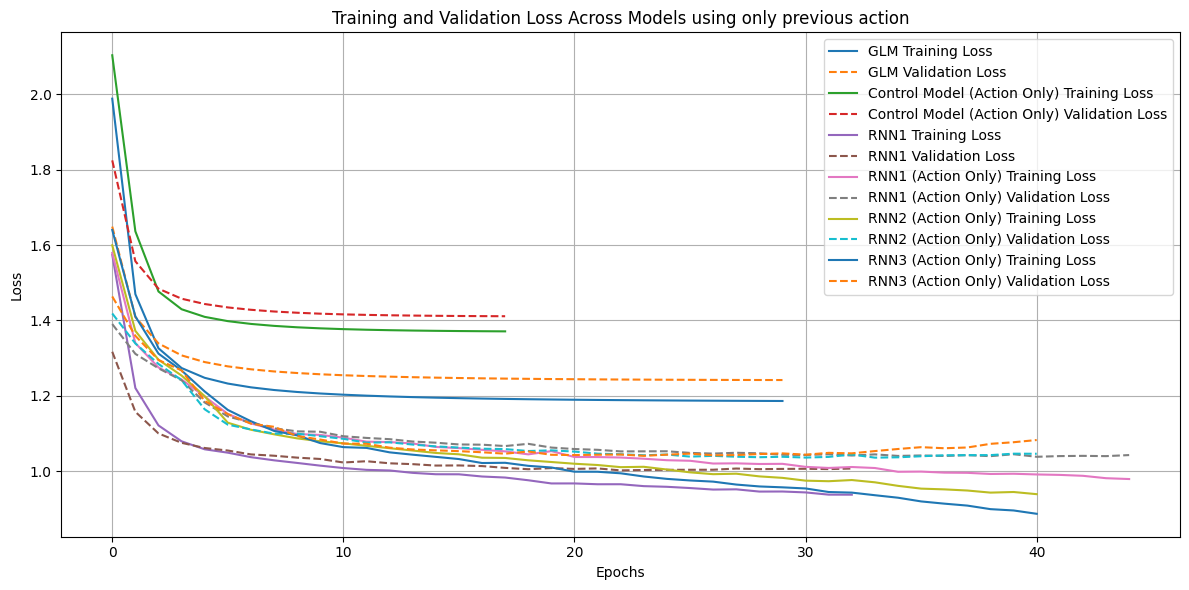

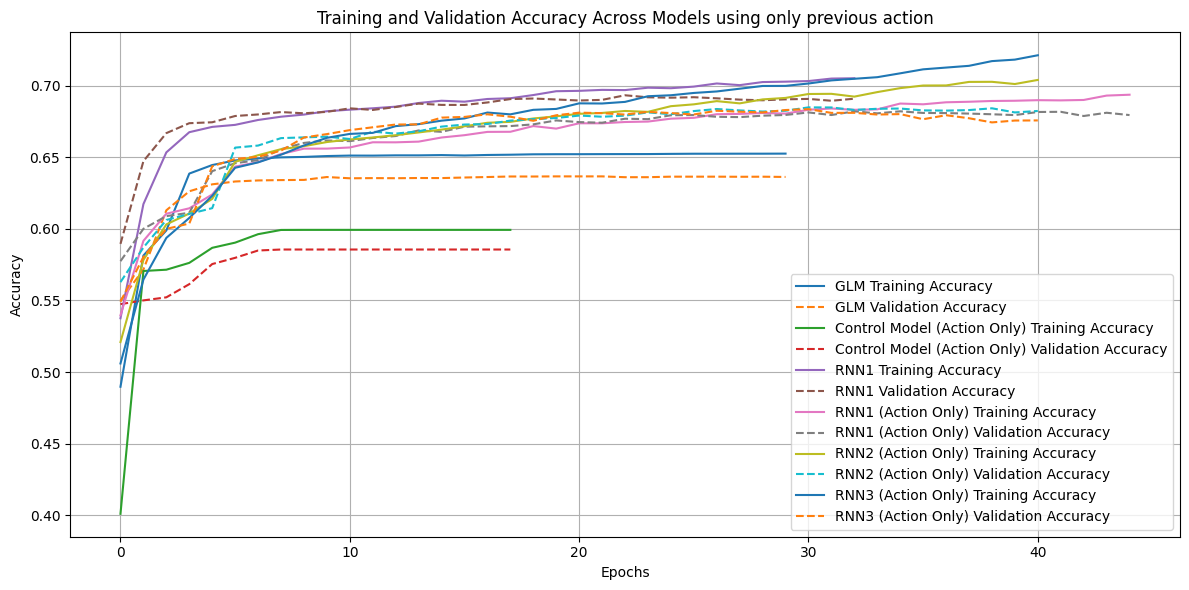

In [ ]:
# Ensure all histories are in dictionary form
histories = {
    "Control": glm_history.history,
    "Control Model (Action Only)": control1_history.history,
    "Control + HL (Action Only)": history_control3_13.history,
    "RNN1": RNN_history.history,
    "RNN1 (Action Only)": RNN1_13_history.history,
    "RNN2 (Action Only)": RNN2_13_history.history,
    "RNN3 (Action Only)": RNN3_13_history.history,
}

#Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    plt.plot(history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history['val_loss'], linestyle='--', label=f'{model_name} Validation Loss')
plt.title('Training and Validation Loss Across Models using only previous action')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    if "masked_accuracy" in history:  # For RNN models
        plt.plot(history['masked_accuracy'], label=f'{model_name} Training Accuracy')
        plt.plot(history['val_masked_accuracy'], linestyle='--', label=f'{model_name} Validation Accuracy')
    else:  # For GLM and Control Models
        plt.plot(history['accuracy'], label=f'{model_name} Training Accuracy')
        plt.plot(history['val_accuracy'], linestyle='--', label=f'{model_name} Validation Accuracy')
plt.title('Training and Validation Accuracy Across Models using only previous action')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


##e) RNNs 1-3: Boardstate only

In [ ]:
max_len = 704
# Step 1: Define a function to slice the first 72 elements of each board state
def slice_and_pad_board_states(board_states, max_len, slice_len=72, pad_value=-1):
    # Slice the first `slice_len` elements of each 85-element board state array
    sliced_states = [state[:slice_len] for state in board_states]

    # If the sequence is longer than max_len, truncate it
    if len(sliced_states) > max_len:
        sliced_states = sliced_states[:max_len]

    # Pad the sequence to match `max_len` with vectors of `pad_value` if needed
    padded_seq = sliced_states + [np.full(slice_len, pad_value)] * (max_len - len(sliced_states))

    return np.array(padded_seq)

# Step 2: Apply the slicing and padding function to each row in `final_df['board_states']`
final_df['sliced_padded_sequences'] = final_df['board_states'].apply(lambda seq: slice_and_pad_board_states(seq, max_len))

# Convert to a NumPy array for RNN input
sequence_tensor = np.stack(final_df['sliced_padded_sequences'].values)
print(sequence_tensor.shape)  # Expected shape: (number of rows, max_len, 72)


(1649, 704, 72)


In [ ]:
# Splitting the data into training and validation sets
RNN_sequence_train_72, RNN_sequence_val_72, RNN_target_train_72, RNN_target_val_72 = train_test_split(
    sequence_tensor, target_tensor, test_size=0.2, random_state=42
)

###RNN1_72

In [ ]:
# Define the padding mask value (-1 for sequences, 12 for actions)
mask_value_seq = -1  # Used for sequence masking
num_actions = 12     # Used for action classes


# Set up the LSTM model with the modified input shape (first 72 elements of game state)
RNN1_72 = Sequential([
    # Masking layer to ignore the padding (-1) in your sequences
    Masking(mask_value=mask_value_seq, input_shape=(None, 72)),  # Input shape now has 72 features

    # LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),  # Adjust units and activation as needed

    # Dense output layer with softmax activation for classification
    Dense(num_actions, activation='softmax')  # Output layer for predicting the next action
])

# Define the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model with the custom optimizer and loss function
RNN1_72.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

# Train the model
RNN_72_history = RNN1_72.fit(
    RNN_sequence_train_72,  # padded input tensor with (number of rows, max_len, 72)
    RNN_target_train_72,    # padded target tensor with (number of rows, max_len)
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 600ms/step - loss: 1.9948 - masked_accuracy: 0.4230 - val_loss: 1.4923 - val_masked_accuracy: 0.5405
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step - loss: 1.4529 - masked_accuracy: 0.5531 - val_loss: 1.3712 - val_masked_accuracy: 0.5474
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 576ms/step - loss: 1.3514 - masked_accuracy: 0.5614 - val_loss: 1.2821 - val_masked_accuracy: 0.6021
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 715ms/step - loss: 1.2713 - masked_accuracy: 0.6059 - val_loss: 1.2491 - val_masked_accuracy: 0.6171
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 586ms/step - loss: 1.2200 - masked_accuracy: 0.6166 - val_loss: 1.2244 - val_masked_accuracy: 0.6206
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 580ms/step - loss: 1.2009 - masked_accuracy: 0.6246 - val_loss: 1.2157 - val_masked_accuracy: 0.6230
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 600ms/step - loss: 1.1946 - masked_accuracy: 0.6250 - val_loss: 1.2008 - val_masked_accuracy: 0.6254

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = RNN1_72.evaluate(RNN_sequence_val, RNN_target_val)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


InvalidArgumentError: Graph execution error:

Detected at node sequential_7_1/lstm_2_1/lstm_cell_1/MatMul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-87-994e038bb843>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 433, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 82, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/lstm.py", line 570, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/lstm.py", line 565, in inner_loop

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py", line 346, in inner_loop

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/rnn.py", line 262, in rnn

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py", line 338, in step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/lstm.py", line 264, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 3445, in matmul

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 477, in matmul

Matrix size-incompatible: In[0]: [32,85], In[1]: [72,256]
	 [[{{node sequential_7_1/lstm_2_1/lstm_cell_1/MatMul}}]] [Op:__inference_one_step_on_iterator_1863904]

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision for each class (action): [0.36268481 0.17314766 0.07142857 0.11699638 0.26835443 0.19096447
 0.02065188 0.04095987 0.17391304 0.10487288 0.00912548 0.05564877
 0.        ]
Recall for each class (action): [0.89594714 0.61174286 0.09360936 0.29302078 0.09114359 0.50618945
 0.54173018 0.30817121 0.01805869 0.12907432 0.02836879 0.19357977
 0.        ]


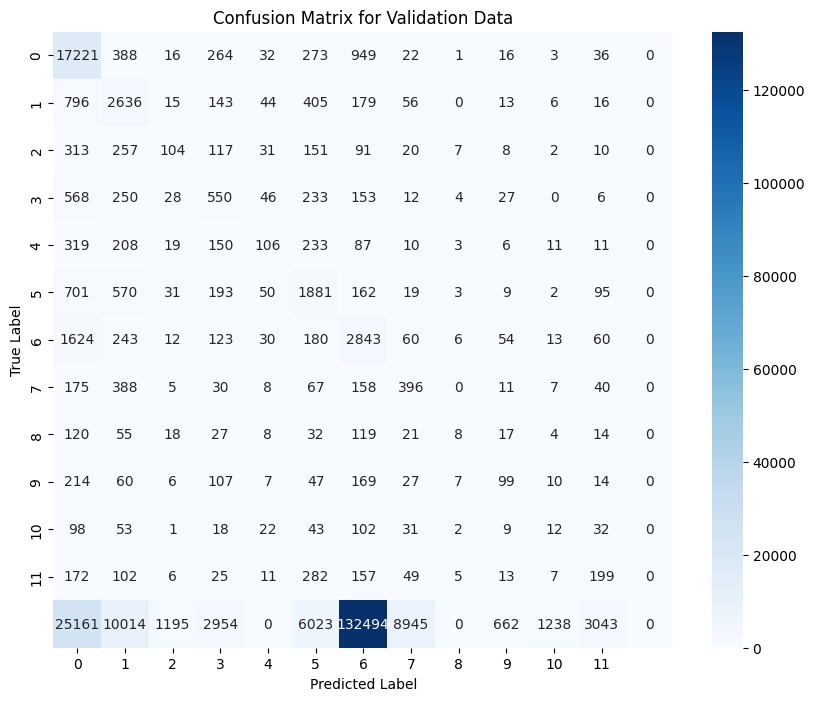

In [ ]:
# import numpy as np
# from sklearn.metrics import precision_score, recall_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Step 1: Generate predictions on the validation set
# val_predictions = RNN1_72.predict(RNN_sequence_val)
# val_predictions_classes = np.argmax(val_predictions, axis=-1)  # Predicted class for each timestep

# # Step 2: Flatten predictions and true labels
# val_target_flat = RNN_target_val.flatten()
# val_pred_flat = val_predictions_classes.flatten()

# # Step 3: Filter out padding values (-1) in both true and predicted labels
# mask = val_target_flat != -1
# val_target_flat = val_target_flat[mask]
# val_pred_flat = val_pred_flat[mask]

# # Step 4: Calculate precision and recall for each class
# precision = precision_score(val_target_flat, val_pred_flat, average=None)
# recall = recall_score(val_target_flat, val_pred_flat, average=None)

# # Print precision and recall for each action class
# print("Precision for each class (action):", precision)
# print("Recall for each class (action):", recall)

# # Step 5: Generate and plot the confusion matrix
# conf_matrix = confusion_matrix(val_target_flat, val_pred_flat)

# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=range(num_actions), yticklabels=range(num_actions))
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for Validation Data')
# plt.show()


###RNN2_72

In [ ]:
# Define the padding mask value (-1 for sequences, 12 for actions)
mask_value_seq = -1  # Used for sequence masking
num_actions = 12     # Used for action classes


# Set up the LSTM model with the modified input shape (first 72 elements of game state)
RNN2_72 = Sequential([
    # Masking layer to ignore the padding (-1) in your sequences
    Masking(mask_value=mask_value_seq, input_shape=(None, 72)),  # Input shape now has 72 features

    # LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification
    Dense(num_actions, activation='softmax')  # Output layer for predicting the next action
])

# Define the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model with the custom optimizer and loss function
RNN2_72.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

# Training the model
RNN2_72_history = RNN2_72.fit(
    RNN_sequence_train,  # padded input tensor with (number of rows, max_len, 72)
    RNN_target_train,    # padded target tensor with (number of rows, max_len)
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 1.8380 - masked_accuracy: 0.4657 - val_loss: 1.5104 - val_masked_accuracy: 0.5232
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 1.4448 - masked_accuracy: 0.5377 - val_loss: 1.3663 - val_masked_accuracy: 0.5440
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 1.3767 - masked_accuracy: 0.5600 - val_loss: 1.2707 - val_masked_accuracy: 0.5979
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 1.2735 - masked_accuracy: 0.5981 - val_loss: 1.2308 - val_masked_accuracy: 0.6164
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.2064 - masked_accuracy: 0.6207 - val_loss: 1.2280 - val_masked_accuracy: 0.6112
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.1765 - masked_accuracy: 0.6301 - val_loss: 1.1920 - val_masked_accuracy: 0.6275
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 1.1882 - masked_accuracy: 0.6224 - val_loss: 1.1741 - val_masked_accuracy: 0.6327
Epoch 8/50
33/33 ━━━

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = RNN2_72.evaluate(RNN_sequence_val, RNN_target_val)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - loss: 1.2326 - masked_accuracy: 0.6206
Validation Loss: 1.1674258708953857
Validation Accuracy: 0.6495943069458008


###RNN3_72

In [ ]:
# Define the padding mask value (-1 for sequences, 12 for actions)
mask_value_seq = -1  # Used for sequence masking
num_actions = 12     # Used for action classes


# Set up the LSTM model with the modified input shape (first 72 elements of game state)
RNN3_72 = Sequential([
    # Masking layer to ignore the padding (-1) in your sequences
    Masking(mask_value=mask_value_seq, input_shape=(None, 72)),  # Input shape now has 72 features

    # LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    LSTM(64, return_sequences=True, activation='tanh'),

    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification
    Dense(num_actions, activation='softmax')  # Output layer for predicting the next action
])

# Define the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model with the custom optimizer and loss function
RNN3_72.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

# Train the model
RNN3_72_history = RNN3_72.fit(
    RNN_sequence_train,  # padded input tensor with (number of rows, max_len, 72)
    RNN_target_train,    # padded target tensor with (number of rows, max_len)
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True2
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - loss: 1.9353 - masked_accuracy: 0.4274 - val_loss: 1.5869 - val_masked_accuracy: 0.4830
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 1.5627 - masked_accuracy: 0.5009 - val_loss: 1.5102 - val_masked_accuracy: 0.5208
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 1.4631 - masked_accuracy: 0.5251 - val_loss: 1.4034 - val_masked_accuracy: 0.5486
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 1.3942 - masked_accuracy: 0.5517 - val_loss: 1.3353 - val_masked_accuracy: 0.5813
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 1.3340 - masked_accuracy: 0.5808 - val_loss: 1.2849 - val_masked_accuracy: 0.5920
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 1.2812 - masked_accuracy: 0.5933 - val_loss: 1.2575 - val_masked_accuracy: 0.6037
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - loss: 1.2493 - masked_accuracy: 0.6039 - val_loss: 1.2083 - val_masked_accuracy: 0.6188
Epoch 8/50
33/33 ━━━

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = RNN3_72.evaluate(RNN_sequence_val, RNN_target_val)

# Print the results
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 472ms/step - loss: 1.1970 - masked_accuracy: 0.6281
Validation Loss: 1.135141372680664
Validation Accuracy: 0.655583918094635


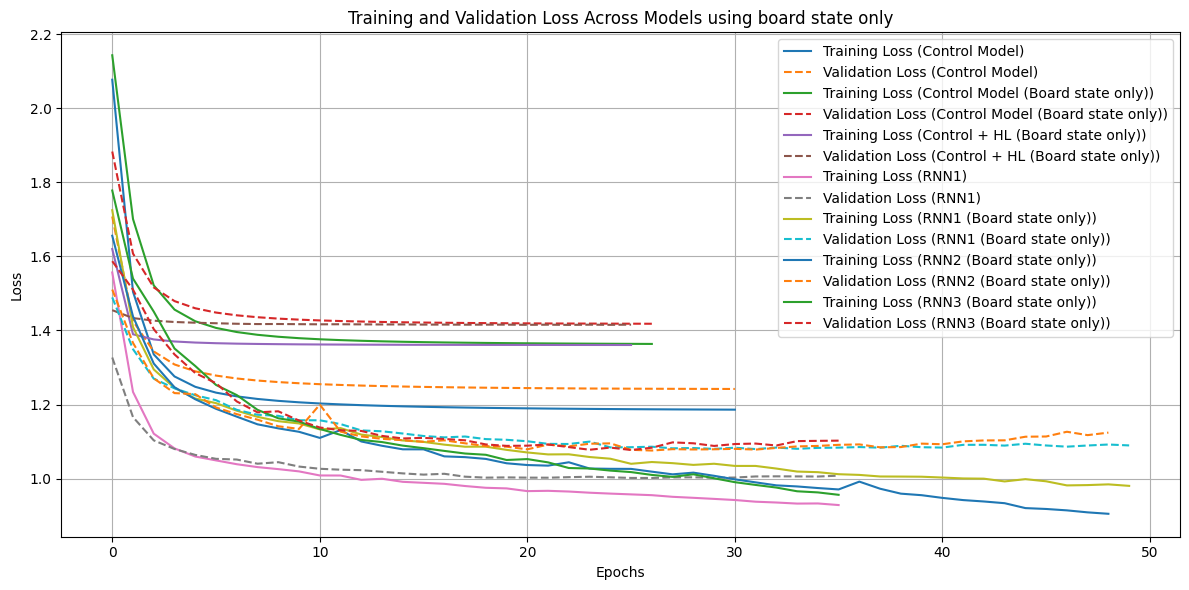

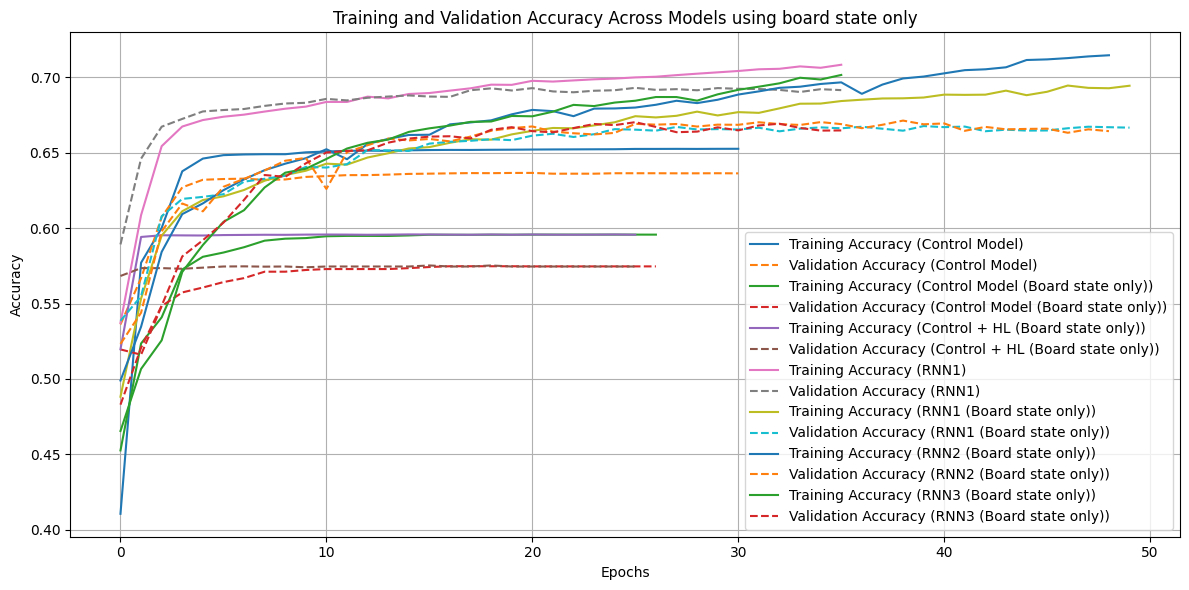

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Retrieve histories for all models
histories = {
    "Control Model": glm_history.history,
    "Control Model (Board state only)": history_control2.history,
    "Control + HL (Board state only)": history_control3_72.history,
    "RNN1": RNN_history.history,
    "RNN1 (Board state only)": RNN_72_history.history,
    "RNN2 (Board state only)": RNN2_72_history.history,
    "RNN3 (Board state only)": RNN3_72_history.history,
}

# Step 2: Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    plt.plot(history['loss'], label=f'Training Loss ({model_name})')
    plt.plot(history['val_loss'], linestyle='--', label=f'Validation Loss ({model_name})')
plt.title('Training and Validation Loss Across Models using board state only')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    if "RNN" in model_name:  # Use masked_accuracy for RNNs
        plt.plot(history['masked_accuracy'], label=f'Training Accuracy ({model_name})')
        plt.plot(history['val_masked_accuracy'], linestyle='--', label=f'Validation Accuracy ({model_name})')
    else:  # Use standard accuracy for other models
        plt.plot(history['accuracy'], label=f'Training Accuracy ({model_name})')
        plt.plot(history['val_accuracy'], linestyle='--', label=f'Validation Accuracy ({model_name})')
plt.title('Training and Validation Accuracy Across Models using board state only')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


#3) Model Comparison

## a) 1-3 trained on gamestate

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


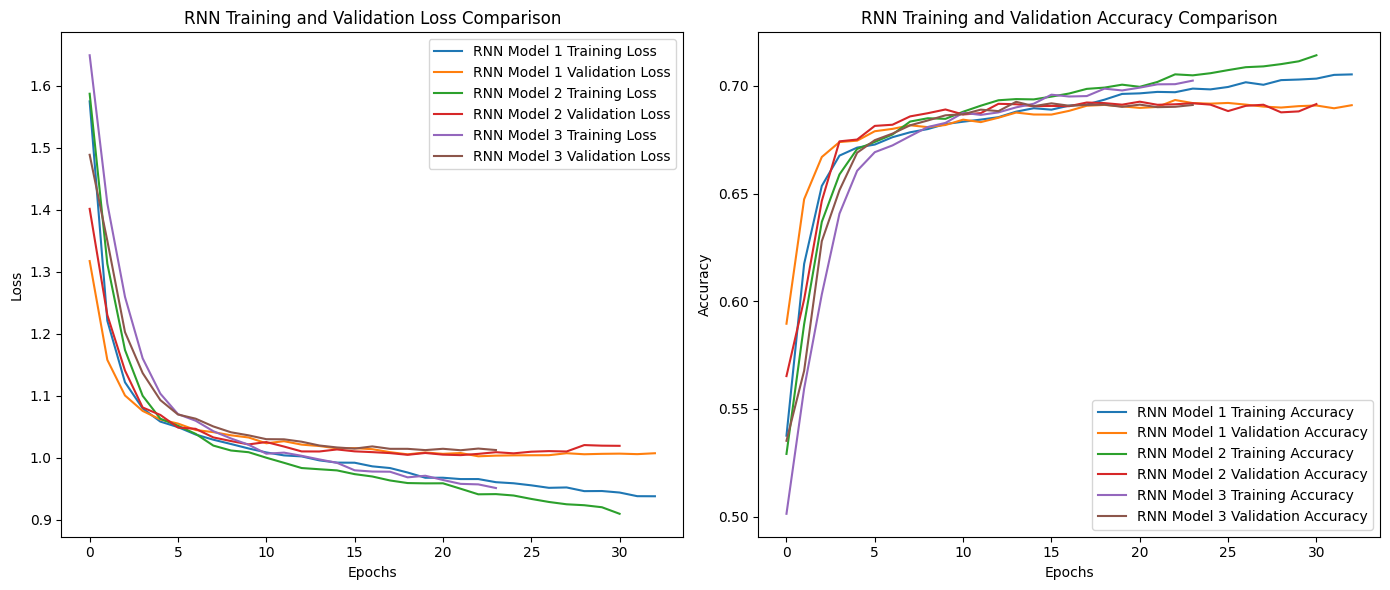

In [ ]:
import matplotlib.pyplot as plt

# Ensure all histories are in dictionary form
RNN1_history_dict = RNN1_history if isinstance(RNN1_history, dict) else RNN1_history.history
RNN2_history_dict = RNN2_history if isinstance(RNN2_history, dict) else RNN2_history.history
RNN3_history_dict = RNN3_history if isinstance(RNN3_history, dict) else RNN3_history.history

# Plotting Losses and Accuracies for RNN1, RNN2, RNN3
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
if 'loss' in RNN1_history_dict:
    plt.plot(RNN1_history_dict['loss'], label='RNN Model 1 Training Loss')
    plt.plot(RNN1_history_dict['val_loss'], label='RNN Model 1 Validation Loss')
if 'loss' in RNN2_history_dict:
    plt.plot(RNN2_history_dict['loss'], label='RNN Model 2 Training Loss')
    plt.plot(RNN2_history_dict['val_loss'], label='RNN Model 2 Validation Loss')
if 'loss' in RNN3_history_dict:
    plt.plot(RNN3_history_dict['loss'], label='RNN Model 3 Training Loss')
    plt.plot(RNN3_history_dict['val_loss'], label='RNN Model 3 Validation Loss')
plt.title('RNN Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
if 'masked_accuracy' in RNN1_history_dict:
    plt.plot(RNN1_history_dict['masked_accuracy'], label='RNN Model 1 Training Accuracy')
    plt.plot(RNN1_history_dict['val_masked_accuracy'], label='RNN Model 1 Validation Accuracy')
if 'masked_accuracy' in RNN2_history_dict:
    plt.plot(RNN2_history_dict['masked_accuracy'], label='RNN Model 2 Training Accuracy')
    plt.plot(RNN2_history_dict['val_masked_accuracy'], label='RNN Model 2 Validation Accuracy')
if 'masked_accuracy' in RNN3_history_dict:
    plt.plot(RNN3_history_dict['masked_accuracy'], label='RNN Model 3 Training Accuracy')
    plt.plot(RNN3_history_dict['val_masked_accuracy'], label='RNN Model 3 Validation Accuracy')
plt.title('RNN Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


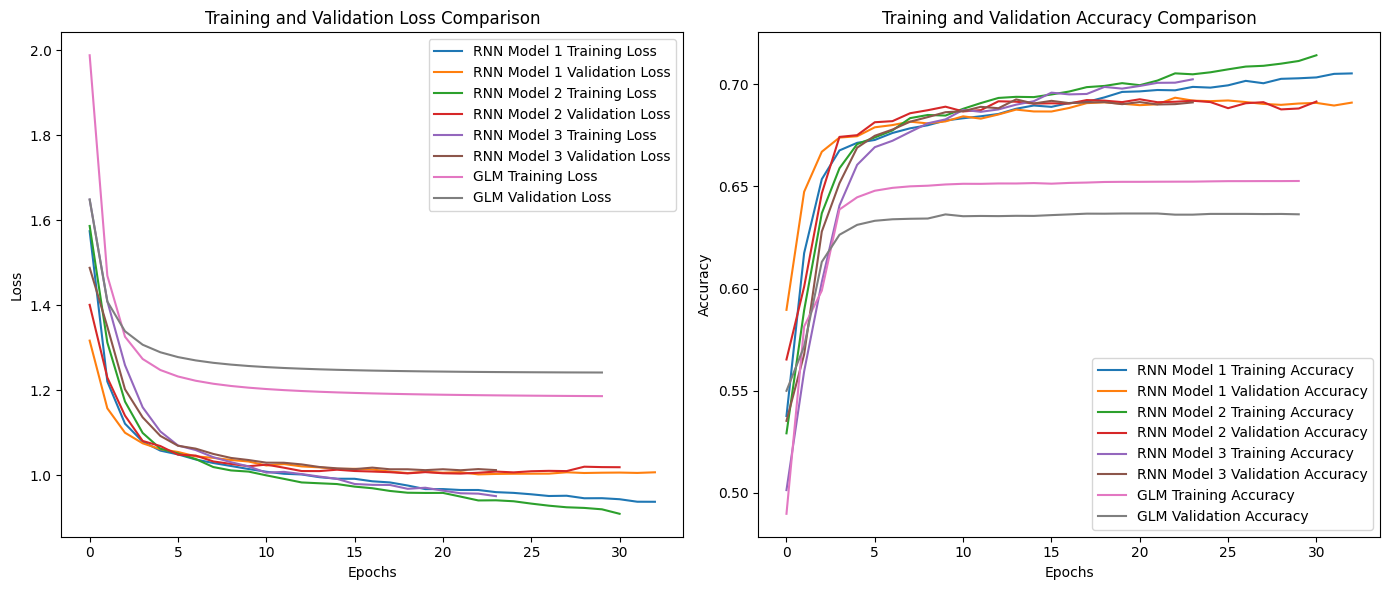

In [ ]:
# Convert all histories to dictionary format
RNN1_history_dict = RNN1_history if isinstance(RNN1_history, dict) else RNN1_history.history
RNN2_history_dict = RNN2_history if isinstance(RNN2_history, dict) else RNN2_history.history
RNN3_history_dict = RNN3_history if isinstance(RNN3_history, dict) else RNN3_history.history
GLM_history_dict = glm_history.history

# Plotting Losses and Accuracies for RNN1, RNN2, RNN3, and GLM

plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
if 'loss' in RNN1_history_dict:
    plt.plot(RNN1_history_dict['loss'], label='RNN Model 1 Training Loss')
    plt.plot(RNN1_history_dict['val_loss'], label='RNN Model 1 Validation Loss')
if 'loss' in RNN2_history_dict:
    plt.plot(RNN2_history_dict['loss'], label='RNN Model 2 Training Loss')
    plt.plot(RNN2_history_dict['val_loss'], label='RNN Model 2 Validation Loss')
if 'loss' in RNN3_history_dict:
    plt.plot(RNN3_history_dict['loss'], label='RNN Model 3 Training Loss')
    plt.plot(RNN3_history_dict['val_loss'], label='RNN Model 3 Validation Loss')
if 'loss' in GLM_history_dict:
    plt.plot(GLM_history_dict['loss'], label='GLM Training Loss')
    plt.plot(GLM_history_dict['val_loss'], label='GLM Validation Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
if 'masked_accuracy' in RNN1_history_dict:
    plt.plot(RNN1_history_dict['masked_accuracy'], label='RNN Model 1 Training Accuracy')
    plt.plot(RNN1_history_dict['val_masked_accuracy'], label='RNN Model 1 Validation Accuracy')
if 'masked_accuracy' in RNN2_history_dict:
    plt.plot(RNN2_history_dict['masked_accuracy'], label='RNN Model 2 Training Accuracy')
    plt.plot(RNN2_history_dict['val_masked_accuracy'], label='RNN Model 2 Validation Accuracy')
if 'masked_accuracy' in RNN3_history_dict:
    plt.plot(RNN3_history_dict['masked_accuracy'], label='RNN Model 3 Training Accuracy')
    plt.plot(RNN3_history_dict['val_masked_accuracy'], label='RNN Model 3 Validation Accuracy')
if 'accuracy' in GLM_history_dict:
    plt.plot(GLM_history_dict['accuracy'], label='GLM Training Accuracy')
    plt.plot(GLM_history_dict['val_accuracy'], label='GLM Validation Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

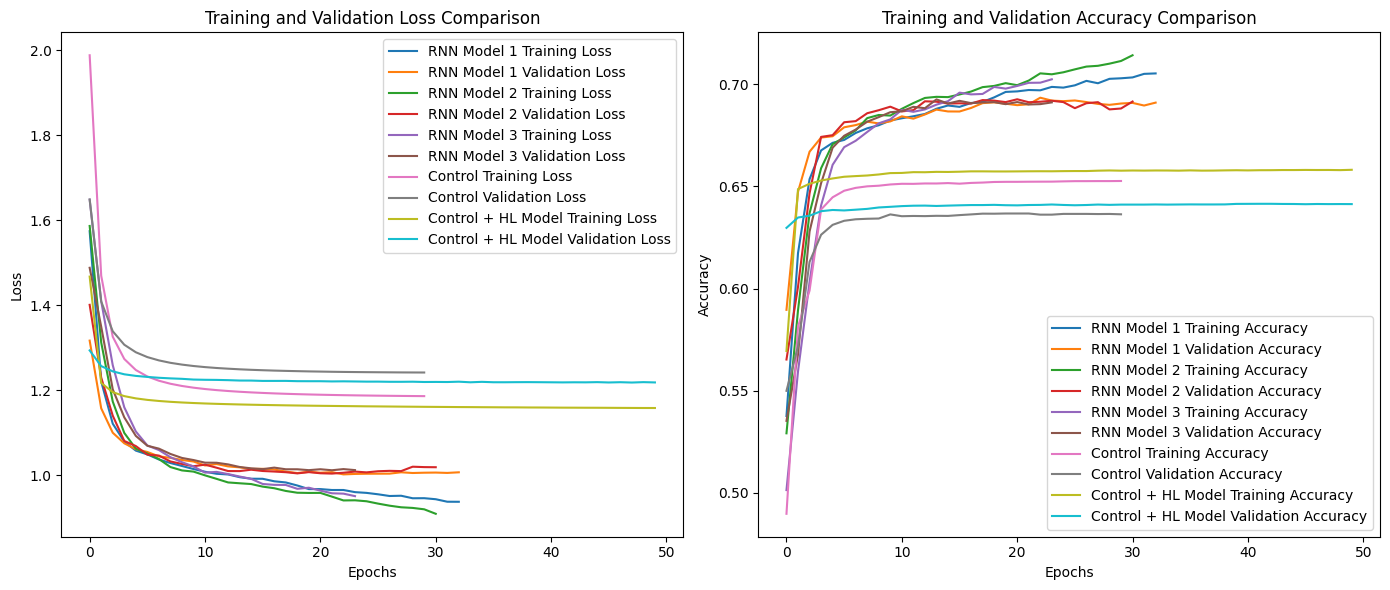

In [ ]:
# Convert all histories to dictionary format
RNN1_history_dict = RNN1_history if isinstance(RNN1_history, dict) else RNN1_history.history
RNN2_history_dict = RNN2_history if isinstance(RNN2_history, dict) else RNN2_history.history
RNN3_history_dict = RNN3_history if isinstance(RNN3_history, dict) else RNN3_history.history
GLM_history_dict = glm_history.history
Control3_history_dict = history_control3.history  # Add the dense model's history

# Plotting Losses and Accuracies for RNN1, RNN2, RNN3, GLM, and Control Model with Dense Layer
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
if 'loss' in RNN1_history_dict:
    plt.plot(RNN1_history_dict['loss'], label='RNN Model 1 Training Loss')
    plt.plot(RNN1_history_dict['val_loss'], label='RNN Model 1 Validation Loss')
if 'loss' in RNN2_history_dict:
    plt.plot(RNN2_history_dict['loss'], label='RNN Model 2 Training Loss')
    plt.plot(RNN2_history_dict['val_loss'], label='RNN Model 2 Validation Loss')
if 'loss' in RNN3_history_dict:
    plt.plot(RNN3_history_dict['loss'], label='RNN Model 3 Training Loss')
    plt.plot(RNN3_history_dict['val_loss'], label='RNN Model 3 Validation Loss')
if 'loss' in GLM_history_dict:
    plt.plot(GLM_history_dict['loss'], label='Control Training Loss')
    plt.plot(GLM_history_dict['val_loss'], label='Control Validation Loss')
if 'loss' in Control3_history_dict:
    plt.plot(Control3_history_dict['loss'], label='Control + HL Model Training Loss')
    plt.plot(Control3_history_dict['val_loss'], label='Control + HL Model Validation Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
if 'masked_accuracy' in RNN1_history_dict:
    plt.plot(RNN1_history_dict['masked_accuracy'], label='RNN Model 1 Training Accuracy')
    plt.plot(RNN1_history_dict['val_masked_accuracy'], label='RNN Model 1 Validation Accuracy')
if 'masked_accuracy' in RNN2_history_dict:
    plt.plot(RNN2_history_dict['masked_accuracy'], label='RNN Model 2 Training Accuracy')
    plt.plot(RNN2_history_dict['val_masked_accuracy'], label='RNN Model 2 Validation Accuracy')
if 'masked_accuracy' in RNN3_history_dict:
    plt.plot(RNN3_history_dict['masked_accuracy'], label='RNN Model 3 Training Accuracy')
    plt.plot(RNN3_history_dict['val_masked_accuracy'], label='RNN Model 3 Validation Accuracy')
if 'accuracy' in GLM_history_dict:
    plt.plot(GLM_history_dict['accuracy'], label='Control Training Accuracy')
    plt.plot(GLM_history_dict['val_accuracy'], label='Control Validation Accuracy')
if 'accuracy' in Control3_history_dict:
    plt.plot(Control3_history_dict['accuracy'], label='Control + HL Model Training Accuracy')
    plt.plot(Control3_history_dict['val_accuracy'], label='Control + HL Model Validation Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


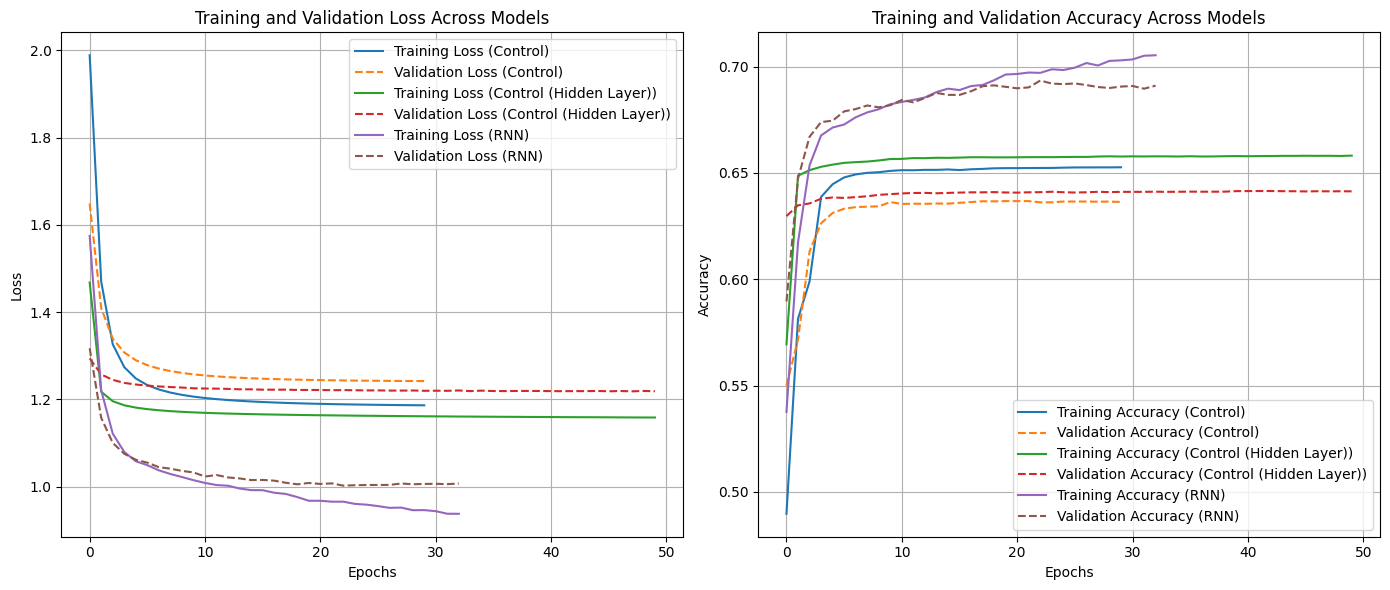

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Retrieve histories for all models
histories = {
    "Control": glm_history.history,
    "Control (Hidden Layer)": history_control3.history,
    "RNN": RNN_history.history,
}

# Step 2: Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Step 3: Plot Training and Validation Loss
for model_name, history in histories.items():
    axes[0].plot(history['loss'], label=f'Training Loss ({model_name})')
    axes[0].plot(history['val_loss'], linestyle='--', label=f'Validation Loss ({model_name})')
axes[0].set_title('Training and Validation Loss Across Models')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend(fontsize=10)
axes[0].grid(True)

# Step 4: Plot Training and Validation Accuracy
for model_name, history in histories.items():
    if model_name == "RNN":
        # Use masked_accuracy for RNN
        axes[1].plot(history['masked_accuracy'], label=f'Training Accuracy ({model_name})')
        axes[1].plot(history['val_masked_accuracy'], linestyle='--', label=f'Validation Accuracy ({model_name})')
    else:
        # Use standard accuracy for other models
        axes[1].plot(history['accuracy'], label=f'Training Accuracy ({model_name})')
        axes[1].plot(history['val_accuracy'], linestyle='--', label=f'Validation Accuracy ({model_name})')
axes[1].set_title('Training and Validation Accuracy Across Models')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend(fontsize=10)
axes[1].grid(True)

# Step 5: Adjust layout and display
plt.tight_layout()
plt.show()


##b) 1-3 trained on previous action only

In [ ]:
# Ensure all histories are in dictionary form
histories = {
    "Control": glm_history.history,
    "Control Model (Action Only)": control1_history.history,
    "Control + HL (Action Only)": history_control3_13.history,
    "RNN1": RNN_history.history,
    "RNN1 (Action Only)": RNN1_13_history.history,
    "RNN2 (Action Only)": RNN2_13_history.history,
    "RNN3 (Action Only)": RNN3_13_history.history,
}

#Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    plt.plot(history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history['val_loss'], linestyle='--', label=f'{model_name} Validation Loss')
plt.title('Training and Validation Loss Across Models using only previous action')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    if "masked_accuracy" in history:  # For RNN models
        plt.plot(history['masked_accuracy'], label=f'{model_name} Training Accuracy')
        plt.plot(history['val_masked_accuracy'], linestyle='--', label=f'{model_name} Validation Accuracy')
    else:  # For GLM and Control Models
        plt.plot(history['accuracy'], label=f'{model_name} Training Accuracy')
        plt.plot(history['val_accuracy'], linestyle='--', label=f'{model_name} Validation Accuracy')
plt.title('Training and Validation Accuracy Across Models using only previous action')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


##c) 1-3 trained on board state only

In [ ]:
# Step 1: Retrieve histories for all models
histories = {
    "Control Model": glm_history.history,
    "Control Model (Board state only)": history_control2.history,
    "Control + HL (Board state only)": history_control3_72.history,
    "RNN1": RNN_history.history,
    "RNN1 (Board state only)": RNN_72_history.history,
    "RNN2 (Board state only)": RNN2_72_history.history,
    "RNN3 (Board state only)": RNN3_72_history.history,
}

# Step 2: Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    plt.plot(history['loss'], label=f'Training Loss ({model_name})')
    plt.plot(history['val_loss'], linestyle='--', label=f'Validation Loss ({model_name})')
plt.title('Training and Validation Loss Across Models using board state only')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    if "RNN" in model_name:  # Use masked_accuracy for RNNs
        plt.plot(history['masked_accuracy'], label=f'Training Accuracy ({model_name})')
        plt.plot(history['val_masked_accuracy'], linestyle='--', label=f'Validation Accuracy ({model_name})')
    else:  # Use standard accuracy for other models
        plt.plot(history['accuracy'], label=f'Training Accuracy ({model_name})')
        plt.plot(history['val_accuracy'], linestyle='--', label=f'Validation Accuracy ({model_name})')
plt.title('Training and Validation Accuracy Across Models using board state only')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


#4) Sequence Tracking

In [ ]:
from collections import Counter
from collections import defaultdict

##a) for GLM

finding the most common action sequence

In [ ]:
# Convert the lists to tuples (lists are unhashable and cant be counted directly)
final_df['action_sequences_tuple'] = final_df['action_sequences'].apply(tuple)

# Count how many times each unique action sequences occurs
sequence_counts = Counter(final_df['action_sequences_tuple'])

# Find the most common action sequence
most_common_sequence, count = sequence_counts.most_common(1)[0]

print("Most Common Action Sequence:")
print(most_common_sequence)
print(f"Count: {count}")

Most Common Action Sequence:
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0)
Count: 38


###i) Accuracy as a function of Sequence Position

1271/1271 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


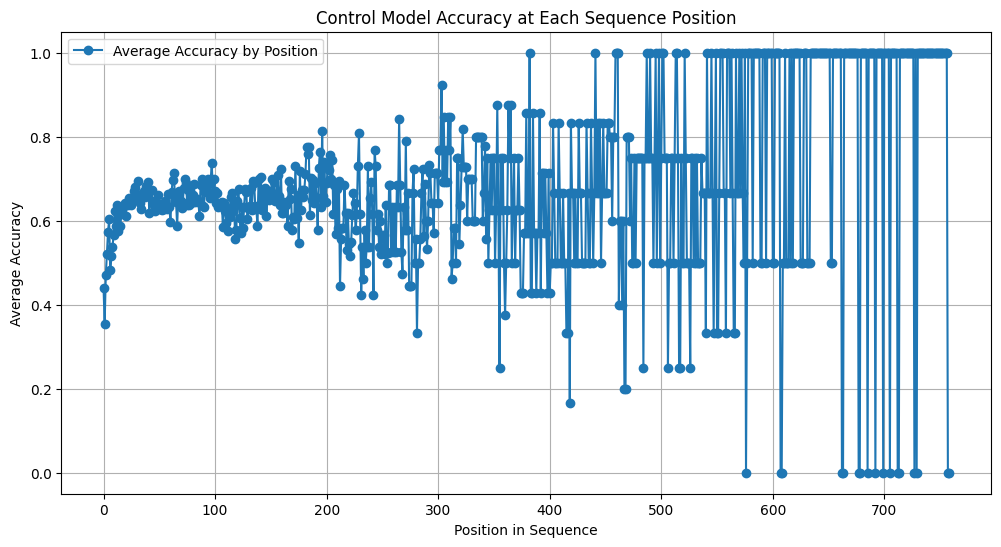

In [ ]:
from collections import defaultdict

#compute accuracy by position
predictions1 = glm_model.predict(Cont_X_val, batch_size=32) #predicts the probabilities of each row for the validation data
predicted_classes1 = np.argmax(predictions1, axis=1) #picks the action with the highest probability for each row, giving the predicted action

# Compare predictions to true values
correct_predictions1 = (predicted_classes1 == Cont_y_val).astype(int)

# Group by position and compute average accuracy
position_accuracies1 = defaultdict(list)

for position, is_correct in zip(positions_val, correct_predictions1):
    position_accuracies1[position].append(is_correct)

# Calculate average accuracy for each position
avg_accuracy_by_position1 = {pos: np.mean(accs) for pos, accs in position_accuracies1.items()}

#plot
positions_sorted1 = sorted(avg_accuracy_by_position1.keys())
accuracies_sorted1 = [avg_accuracy_by_position1[pos] for pos in positions_sorted1]

plt.figure(figsize=(12, 6))
plt.plot(positions_sorted1, accuracies_sorted1, marker='o', label='Average Accuracy by Position')
plt.xlabel('Position in Sequence')
plt.ylabel('Average Accuracy')
plt.title('Control Model Accuracy at Each Sequence Position')
plt.grid(True)
plt.legend()
plt.show()

####Log scale version of accuracy at sequence position

1271/1271 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


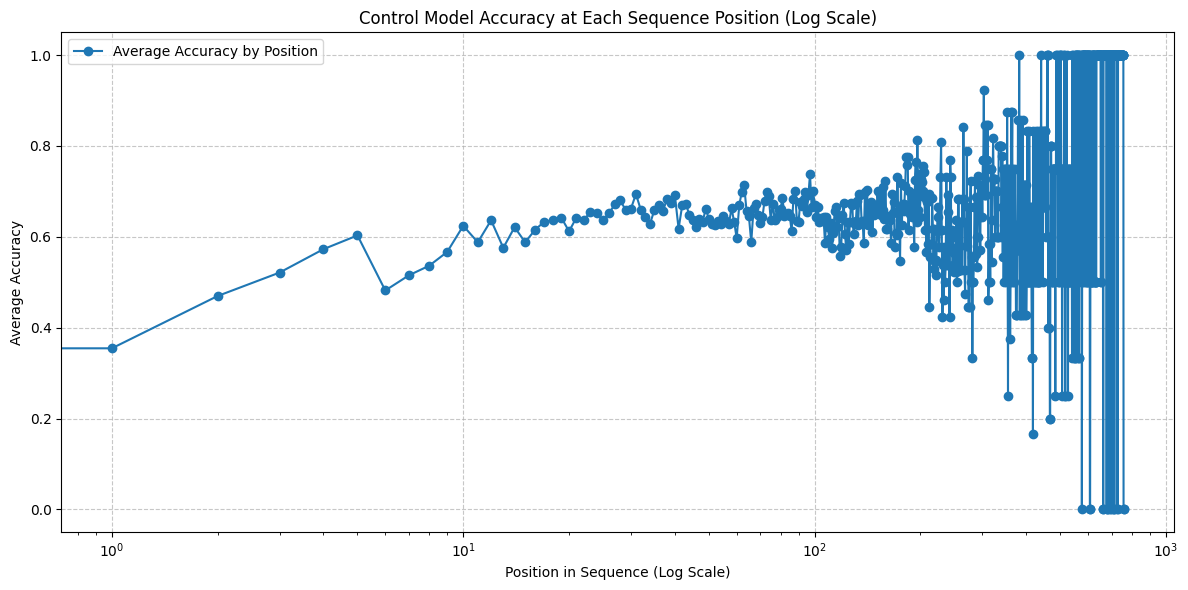

In [ ]:
#compute accuracy by position
predictions1 = glm_model.predict(Cont_X_val, batch_size=32) #predicts the probabilities of each row for the validation data
predicted_classes1 = np.argmax(predictions1, axis=1) #picks the action with the highest probability for each row, giving the predicted action

# Compare predictions to true values
correct_predictions1 = (predicted_classes1 == Cont_y_val).astype(int)

# Group by position and compute average accuracy
position_accuracies1 = defaultdict(list)

for position, is_correct in zip(positions_val, correct_predictions1):
    position_accuracies1[position].append(is_correct)

# Calculate average accuracy for each position
avg_accuracy_by_position1 = {pos: np.mean(accs) for pos, accs in position_accuracies1.items()}

positions_sorted1 = sorted(avg_accuracy_by_position1.keys())
accuracies_sorted1 = [avg_accuracy_by_position1[pos] for pos in positions_sorted1]

# Plot the results with logarithmic x-axis
plt.figure(figsize=(12, 6))
plt.plot(positions_sorted1, accuracies_sorted1, marker='o', label='Average Accuracy by Position')
plt.xscale("log")  # Set x-axis to logarithmic scale
plt.xlabel('Position in Sequence (Log Scale)')
plt.ylabel('Average Accuracy')
plt.title('Control Model Accuracy at Each Sequence Position (Log Scale)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


#### Accuracy at first 20 sequence positions

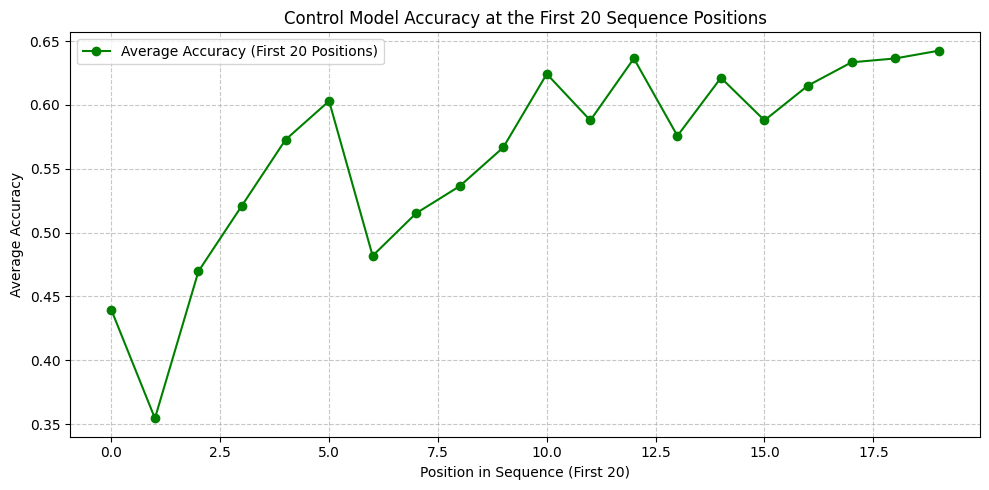

In [ ]:
#Focusing on the first 20 positions
first_20_positions = [pos for pos in positions_sorted1 if pos < 20]
first_20_accuracies = [avg_accuracy_by_position1[pos] for pos in first_20_positions]

#plotting
plt.plot(first_20_positions, first_20_accuracies, marker='o', color='green', label='Average Accuracy (First 20 Positions)')
plt.xlabel('Position in Sequence (First 20)')
plt.ylabel('Average Accuracy')
plt.title('Control Model Accuracy at the First 20 Sequence Positions')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

####accuracy by binned sequence positions

Positions with NaN values: [704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721
 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739
 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757
 758]
Total NaN values: 55


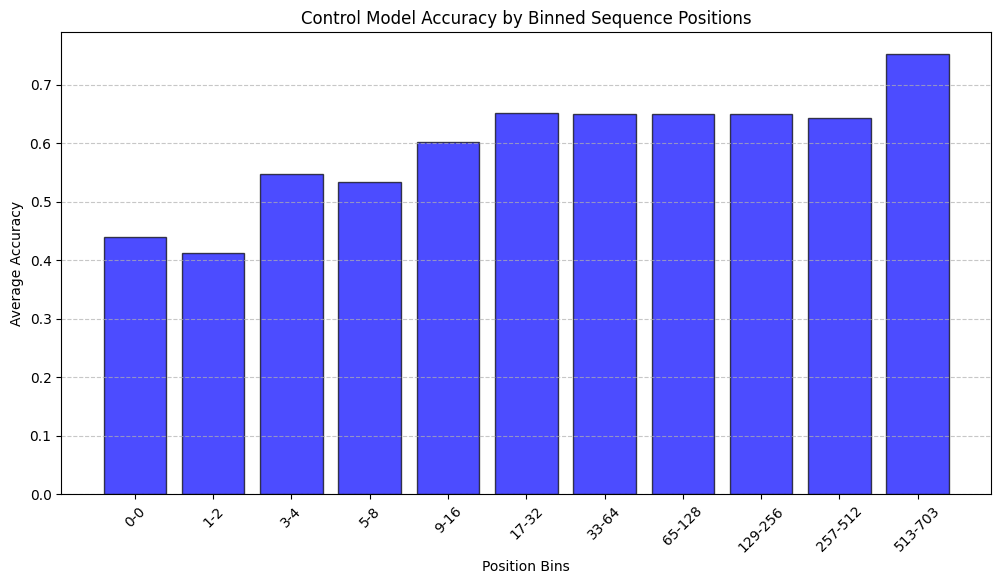

In [ ]:
# Step 1: Define new bins and labels
bins = [0, 1, 3, 5, 9, 17, 33, 65, 129, 257, 513, 704]  # Explicit bin edges
bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]  # Custom labels for bins

# Step 2: Group positions by bins
position_bins1 = pd.cut(positions_val, bins=bins, labels=bin_labels, right=False)

# Check for NaN values in bins
nan_positions1 = positions_val[pd.isnull(position_bins1)]
print(f"Positions with NaN values: {nan_positions1}")
print(f"Total NaN values: {len(nan_positions1)}")

# Initialize a dictionary to hold accuracies for each bin
bin_accuracies1 = defaultdict(list)

# Group accuracies into bins
for pos, is_correct, bin_label in zip(positions_val, correct_predictions1, position_bins1):
    if pd.notnull(bin_label):  # Ensure bin label is not NaN
        bin_accuracies1[bin_label].append(is_correct)

# Step 3: Calculate average accuracy for each bin
avg_accuracy_by_bin1 = {bin_label: np.mean(accs) for bin_label, accs in bin_accuracies1.items()}

# Ensure all bins are represented, even if empty
accuracies_sorted_bar1 = [avg_accuracy_by_bin1.get(bin_label, 0) for bin_label in bin_labels]

# Step 4: Plot the results
plt.figure(figsize=(12, 6))
plt.bar(bin_labels, accuracies_sorted_bar1, color='blue', alpha=0.7, edgecolor='black')
plt.xticks(rotation=45)
plt.xlabel('Position Bins')
plt.ylabel('Average Accuracy')
plt.title('Control Model Accuracy by Binned Sequence Positions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


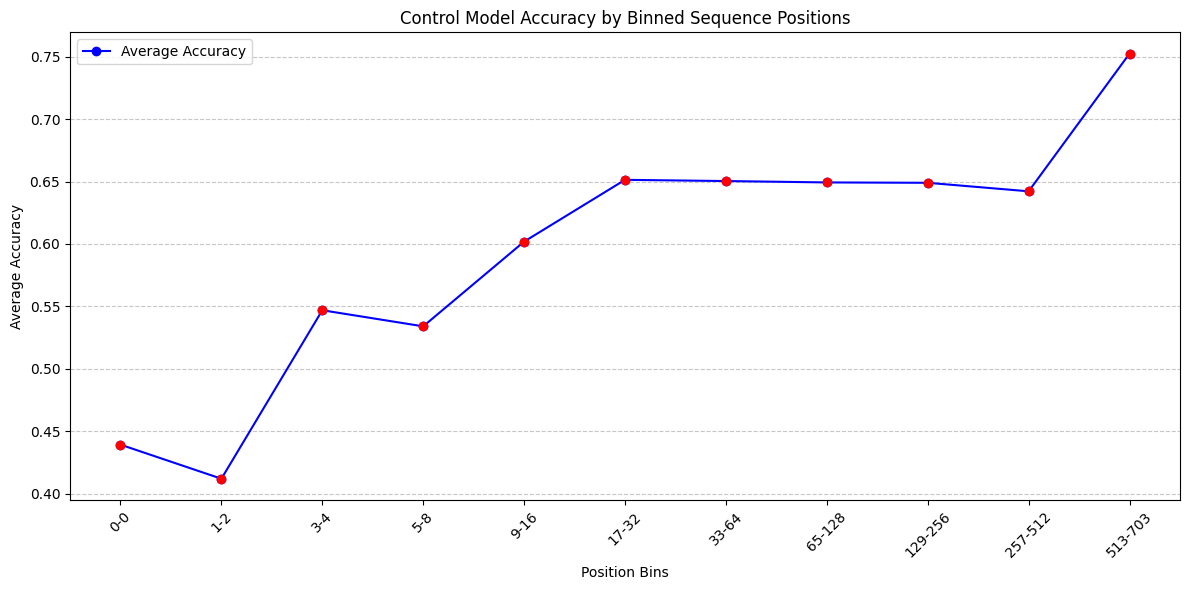

In [ ]:
# Step 4: Plot the results as a line plot
plt.figure(figsize=(12, 6))

# Create a line plot with markers for each bin
plt.plot(bin_labels, accuracies_sorted_bar1, marker='o', color='blue', label='Average Accuracy')

# Optional: Add scatter points for better emphasis
plt.scatter(bin_labels, accuracies_sorted_bar1, color='red', zorder=5)

# Formatting the plot
plt.xticks(rotation=45)
plt.xlabel('Position Bins')
plt.ylabel('Average Accuracy')
plt.title('Control Model Accuracy by Binned Sequence Positions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()


###ii) Accuracy as a function of reversed sequence position

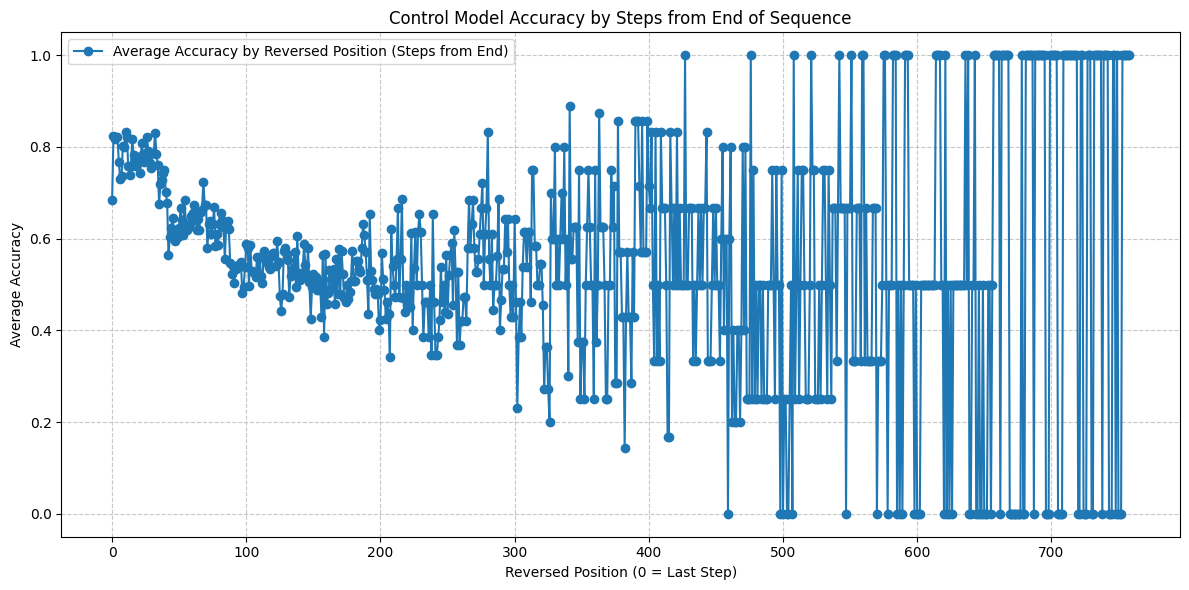

In [ ]:
# Group accuracies by reversed positions
reversed_position_accuracies = defaultdict(list)

# Group accuracies into bins by reversed positions
for position, is_correct in zip(reversed_positions_val, correct_predictions1):
    reversed_position_accuracies[position].append(is_correct)

# Calculate average accuracy for each reversed position
avg_accuracy_by_reversed_position = {
    pos: np.mean(accs) for pos, accs in reversed_position_accuracies.items()
}

# Sort the reversed positions in ascending order
positions_sorted_reversed = sorted(avg_accuracy_by_reversed_position.keys())
accuracies_sorted_reversed = [
    avg_accuracy_by_reversed_position[pos] for pos in positions_sorted_reversed
]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(
    positions_sorted_reversed,
    accuracies_sorted_reversed,
    marker="o",
    label="Average Accuracy by Reversed Position (Steps from End)",
)
plt.xlabel("Reversed Position (0 = Last Step)")
plt.ylabel("Average Accuracy")
plt.title("Control Model Accuracy by Steps from End of Sequence")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


####Log scale version of accuracy at reversed sequence position

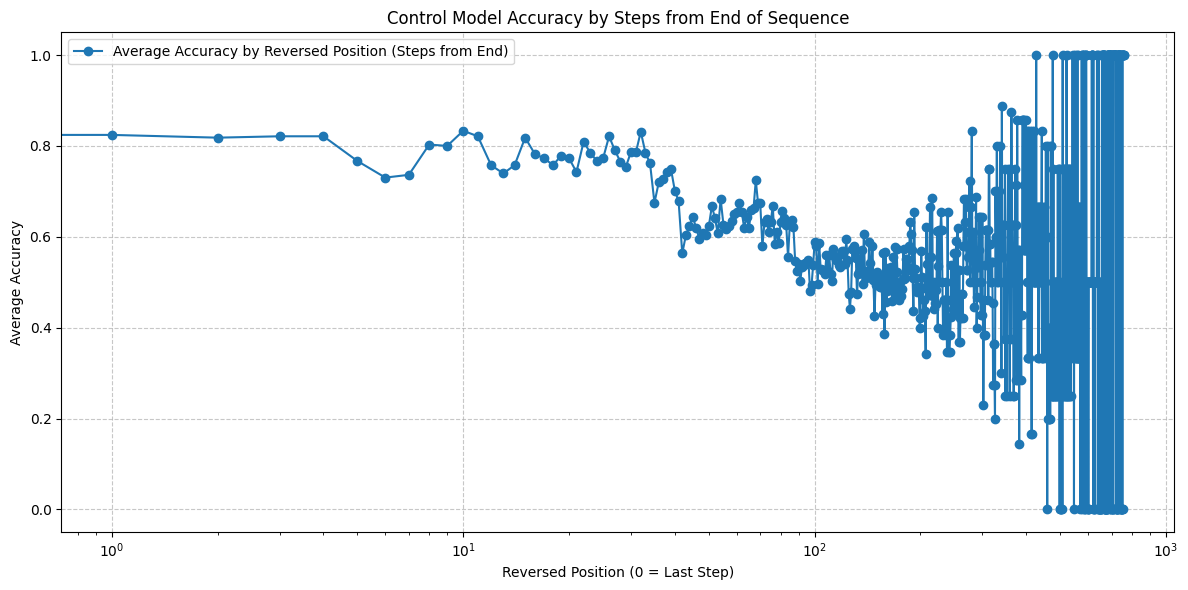

In [ ]:
# Group accuracies by reversed positions
reversed_position_accuracies = defaultdict(list)

# Group accuracies into bins by reversed positions
for position, is_correct in zip(reversed_positions_val, correct_predictions1):
    reversed_position_accuracies[position].append(is_correct)

# Calculate average accuracy for each reversed position
avg_accuracy_by_reversed_position = {
    pos: np.mean(accs) for pos, accs in reversed_position_accuracies.items()
}

# Sort the reversed positions in ascending order
positions_sorted_reversed = sorted(avg_accuracy_by_reversed_position.keys())
accuracies_sorted_reversed = [
    avg_accuracy_by_reversed_position[pos] for pos in positions_sorted_reversed
]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(
    positions_sorted_reversed,
    accuracies_sorted_reversed,
    marker="o",
    label="Average Accuracy by Reversed Position (Steps from End)",
)
plt.xlabel("Reversed Position (0 = Last Step)")
plt.ylabel("Average Accuracy")
plt.title("Control Model Accuracy by Steps from End of Sequence")
plt.xscale("log")  # Set x-axis to logarithmic scale
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


####Accuracy by binned reverse sequence position

Reversed positions with NaN values: [758 757 756 755 754 753 752 751 750 749 748 747 746 745 744 743 742 741
 740 739 738 737 736 735 734 733 732 731 730 729 728 727 726 725 724 723
 722 721 720 719 718 717 716 715 714 713 712 711 710 709 708 707 706 705
 704]
Total NaN values: 55


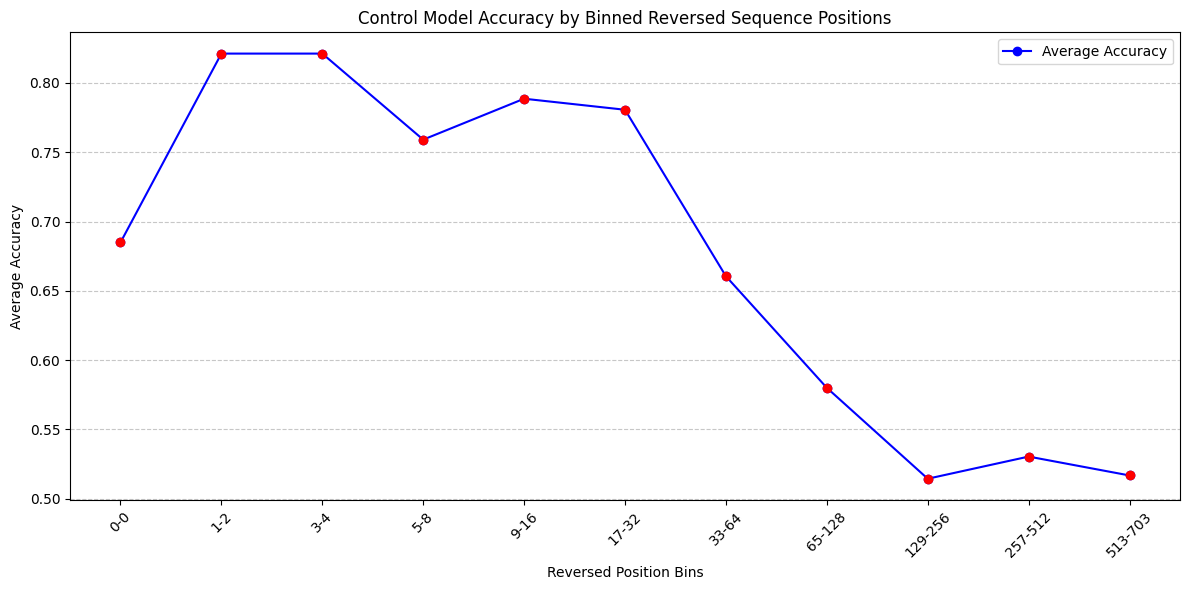

In [ ]:

#Define new bins and labels
bins_reversed = [0, 1, 3, 5, 9, 17, 33, 65, 129, 257, 513, 704]  # Explicit bin edges!
bin_labels_reversed = [f"{bins_reversed[i]}-{bins_reversed[i+1]-1}" for i in range(len(bins_reversed) - 1)]  # Custom labels for bins

#Group reversed positions into bins
reversed_position_bins = pd.cut(reversed_positions_val, bins=bins_reversed, labels=bin_labels_reversed, right=False)

# Check for NaN values in bins
nan_positions_reversed = reversed_positions_val[pd.isnull(reversed_position_bins)]
print(f"Reversed positions with NaN values: {nan_positions_reversed}")
print(f"Total NaN values: {len(nan_positions_reversed)}")

# Initialize a dictionary to hold accuracies for each bin
bin_accuracies_reversed = defaultdict(list)

# Group accuracies into bins
for pos, is_correct, bin_label in zip(reversed_positions_val, correct_predictions1, reversed_position_bins):
    if pd.notnull(bin_label):  # make sure bin label is not NaN
        bin_accuracies_reversed[bin_label].append(is_correct)

#Calculate average accuracy for each bin
avg_accuracy_by_bin_reversed = {bin_label: np.mean(accs) for bin_label, accs in bin_accuracies_reversed.items()}

# Ensure all bins are represented, even if empty
accuracies_sorted_bar_reversed = [avg_accuracy_by_bin_reversed.get(bin_label, 0) for bin_label in bin_labels_reversed]

# Step 4: Plot the results as a line plot
plt.figure(figsize=(12, 6))

# Create a line plot with markers for each bin
plt.plot(bin_labels_reversed, accuracies_sorted_bar_reversed, marker='o', color='blue', label='Average Accuracy')

# Add scatter points for better emphasis
plt.scatter(bin_labels_reversed, accuracies_sorted_bar_reversed, color='red', zorder=5)

plt.xticks(rotation=45)
plt.xlabel('Reversed Position Bins')
plt.ylabel('Average Accuracy')
plt.title('Control Model Accuracy by Binned Reversed Sequence Positions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()


##b) for nonlinear control (dense network with 1 hidden layer)

###i) Accuracy as a function of Sequence Position  

In [ ]:
# Get model predictions
predictions3 = control_model3.predict(Cont_X_val, batch_size=32)  # Predict probabilities
predicted_classes3 = np.argmax(predictions3, axis=1)  # Convert to predicted class labels

# Compare predictions to true values
correct_predictions3 = (predicted_classes3 == Cont_y_val).astype(int)

#padding value (if applicable)
pad_value = 12

# Group accuracies by position
position_accuracies3 = defaultdict(list)
for position, is_correct in zip(positions_val, correct_predictions3):
    position_accuracies3[position].append(is_correct)

# Calculate average accuracy for each position
avg_accuracy_by_position3 = {pos: np.mean(accs) for pos, accs in position_accuracies3.items()}

# Sort positions and accuracies for plotting
positions_sorted3 = sorted(avg_accuracy_by_position3.keys())
accuracies_sorted3 = [avg_accuracy_by_position3[pos] for pos in positions_sorted3]

# Plot accuracy by position
plt.figure(figsize=(12, 6))
plt.plot(positions_sorted3, accuracies_sorted3, marker='o', label='Average Accuracy by Position')
plt.xlabel('Position in Sequence')
plt.ylabel('Average Accuracy')
plt.title('Control Model 3 Accuracy at Each Sequence Position')
plt.grid(True)
plt.legend()
plt.show()

#### Accuracy by Binned Sequence Position

In [ ]:
#Define new bins and labels
bins = [0, 2, 5, 9, 17, 33, 65, 129, 257, 513, 704]  # Explicit bin edges
bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]  # Custom labels for bins

#Group positions by bins
position_bins3 = pd.cut(positions_val, bins=bins, labels=bin_labels, right=False)

# Check for NaN values in bins
nan_positions3 = positions_val[pd.isnull(position_bins3)]
print(f"Positions with NaN values: {nan_positions3}")
print(f"Total NaN values: {len(nan_positions3)}")

# Initialize a dictionary to hold accuracies for each bin
bin_accuracies3 = defaultdict(list)

# Group accuracies into bins
for pos, is_correct, bin_label in zip(positions_val, correct_predictions3, position_bins3):
    if pd.notnull(bin_label):  # Ensure bin label is not NaN
        bin_accuracies3[bin_label].append(is_correct)

# Calculate average accuracy for each bin
avg_accuracy_by_bin3 = {bin_label: np.mean(accs) for bin_label, accs in bin_accuracies3.items()}

# Ensure all bins are represented (even if empty)
accuracies_sorted_bar3 = [avg_accuracy_by_bin3.get(bin_label, 0) for bin_label in bin_labels]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(bin_labels, accuracies_sorted_bar3, color='blue', alpha=0.7, edgecolor='black')
plt.xticks(rotation=45)
plt.xlabel('Position Bins')
plt.ylabel('Average Accuracy')
plt.title('Control Model Accuracy by Binned Sequence Positions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###ii) Accuracy as a Function of Reversed Sequence Position

In [ ]:
# Group accuracies by reversed positions
reversed_position_accuracies3 = defaultdict(list)
for position, is_correct in zip(reversed_positions_val, correct_predictions3):
    reversed_position_accuracies3[position].append(is_correct)

# Calculate average accuracy for each reversed position
avg_accuracy_by_reversed_position3 = {
    pos: np.mean(accs) for pos, accs in reversed_position_accuracies3.items()
}

# Sort reversed positions and accuracies for plotting
positions_sorted_reversed3 = sorted(avg_accuracy_by_reversed_position3.keys())
accuracies_sorted_reversed3 = [
    avg_accuracy_by_reversed_position3[pos] for pos in positions_sorted_reversed3
]

# Plot accuracy by reversed position (log scale for x-axis)
plt.figure(figsize=(12, 6))
plt.plot(
    positions_sorted_reversed3,
    accuracies_sorted_reversed3,
    marker="o",
    label="Average Accuracy by Reversed Position (Control Model 3)",
)
plt.xlabel("Reversed Position (0 = Last Step)")
plt.ylabel("Average Accuracy")
plt.title("Control Model 3 Accuracy by Steps from End of Sequence")
plt.xscale("log")  # Set x-axis to logarithmic scale
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


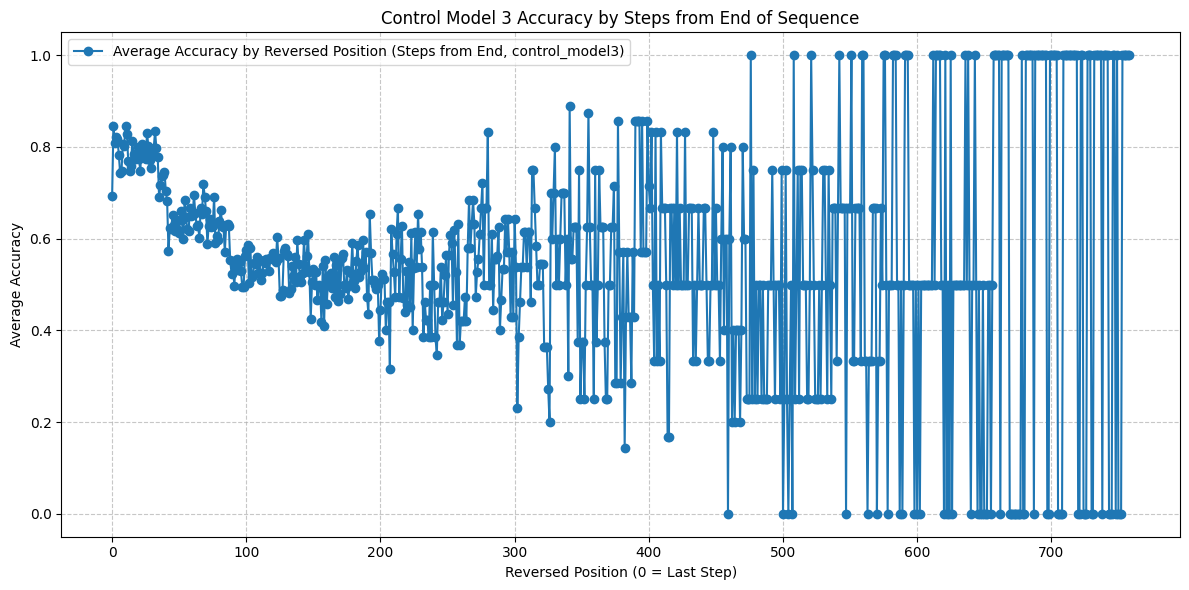

Reversed positions with NaN values: [758 757 756 755 754 753 752 751 750 749 748 747 746 745 744 743 742 741
 740 739 738 737 736 735 734 733 732 731 730 729 728 727 726 725 724 723
 722 721 720 719 718 717 716 715 714 713 712 711 710 709 708 707 706 705
 704]
Total NaN values: 55


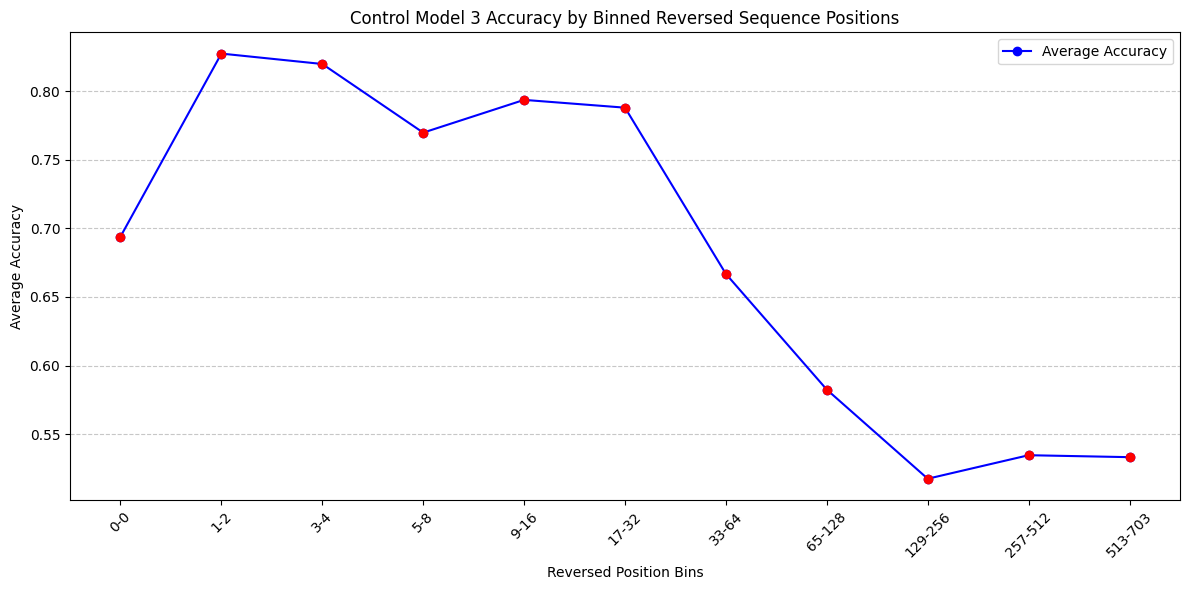

In [ ]:
#Predict for the validation set
# Predict probabilities for validation data
predictions3 = control_model3.predict(Cont_X_val, batch_size=32)

# Get predicted classes (action with the highest probability)
predicted_classes3 = np.argmax(predictions3, axis=1)

# Compare predictions to true values
correct_predictions3 = (predicted_classes3 == Cont_y_val).astype(int)

#Group accuracies by reversed positions
reversed_position_accuracies3 = defaultdict(list)

# Group accuracies into bins by reversed positions
for position, is_correct in zip(reversed_positions_val, correct_predictions3):
    reversed_position_accuracies3[position].append(is_correct)

# Calculate average accuracy for each reversed position
avg_accuracy_by_reversed_position3 = {
    pos: np.mean(accs) for pos, accs in reversed_position_accuracies3.items()
}

# Sort the reversed positions in ascending order
positions_sorted_reversed3 = sorted(avg_accuracy_by_reversed_position3.keys())
accuracies_sorted_reversed3 = [
    avg_accuracy_by_reversed_position3[pos] for pos in positions_sorted_reversed3
]

# Plot accuracy by reversed position
plt.figure(figsize=(12, 6))
plt.plot(
    positions_sorted_reversed3,
    accuracies_sorted_reversed3,
    marker="o",
    label="Average Accuracy by Reversed Position (Steps from End, control_model3)",
)
plt.xlabel("Reversed Position (0 = Last Step)")
plt.ylabel("Average Accuracy")
plt.title("Control Model 3 Accuracy by Steps from End of Sequence")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()



#Define bins for reversed positions
bins_reversed = [0, 1, 3, 5, 9, 17, 33, 65, 129, 257, 513, 704]  # Explicit bin edges
bin_labels_reversed = [f"{bins_reversed[i]}-{bins_reversed[i+1]-1}" for i in range(len(bins_reversed) - 1)]  # Custom labels

# Group reversed positions into bins
reversed_position_bins3 = pd.cut(reversed_positions_val, bins=bins_reversed, labels=bin_labels_reversed, right=False)

# Check for NaN values in bins
nan_positions_reversed3 = reversed_positions_val[pd.isnull(reversed_position_bins3)]
print(f"Reversed positions with NaN values: {nan_positions_reversed3}")
print(f"Total NaN values: {len(nan_positions_reversed3)}")

#Calculate accuracy for each bin
bin_accuracies_reversed3 = defaultdict(list)

# Group accuracies into bins
for pos, is_correct, bin_label in zip(reversed_positions_val, correct_predictions3, reversed_position_bins3):
    if pd.notnull(bin_label):  # Ensure bin label is valid
        bin_accuracies_reversed3[bin_label].append(is_correct)

# Calculate average accuracy for each bin
avg_accuracy_by_bin_reversed3 = {bin_label: np.mean(accs) for bin_label, accs in bin_accuracies_reversed3.items()}

# Ensure all bins are represented (even if empty)
accuracies_sorted_bar_reversed3 = [avg_accuracy_by_bin_reversed3.get(bin_label, 0) for bin_label in bin_labels_reversed]

#Plot binned accuracy by reversed position
plt.figure(figsize=(12, 6))

# Create a line plot with markers for each bin
plt.plot(bin_labels_reversed, accuracies_sorted_bar_reversed3, marker='o', color='blue', label='Average Accuracy')

# Add scatter points for better emphasis
plt.scatter(bin_labels_reversed, accuracies_sorted_bar_reversed3, color='red', zorder=5)

# Formatting
plt.xticks(rotation=45)
plt.xlabel('Reversed Position Bins')
plt.ylabel('Average Accuracy')
plt.title('Control Model 3 Accuracy by Binned Reversed Sequence Positions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Plot
plt.show()


##c) for RNN

###i) Accuracy as a function of Sequence Position

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


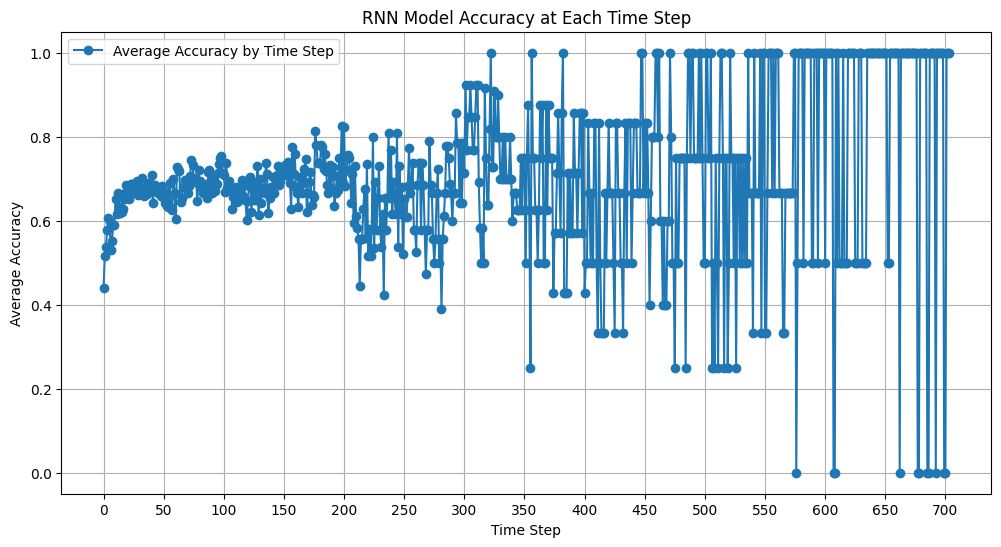

In [ ]:
# Get model predictions
y_pred_proba = RNN1.predict(RNN_sequence_val)  # Predictions in probability format
y_pred = np.argmax(y_pred_proba, axis=-1)  # Convert to predicted class labels

# Convert true labels to array
y_true = np.array(RNN_target_val)  # Shape: (num_sequences, max_sequence_length)

# Defined previously as 12
pad_value = 12

# Create a mask to ignore padding in targets
mask = y_true != pad_value  # Shape: (num_sequences, max_sequence_length)

# Calculate element-wise correctness for predictions
correct_predictions2 = (y_true == y_pred).astype(np.float32)  # Shape: (num_sequences, max_sequence_length)

# Apply the mask to exclude padded elements
correct_predictions2 *= mask

# Calculate the number of valid sequences at each time step (exclude padding)
valid_counts = np.sum(mask, axis=0)  # Shape: (max_sequence_length,)

# Calculate average accuracy at each time step
time_step_accuracies = np.sum(correct_predictions2, axis=0) / (valid_counts + np.finfo(float).eps)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(time_step_accuracies)), time_step_accuracies, marker='o', label='Average Accuracy by Time Step')
plt.xlabel('Time Step')
plt.ylabel('Average Accuracy')
plt.title('RNN Model Accuracy at Each Time Step')
plt.xticks(np.arange(0, len(time_step_accuracies), step=50))
plt.grid(True)
plt.legend()
plt.show()

#### Log Scale Version of Accuracy as a function of Sequence Position  

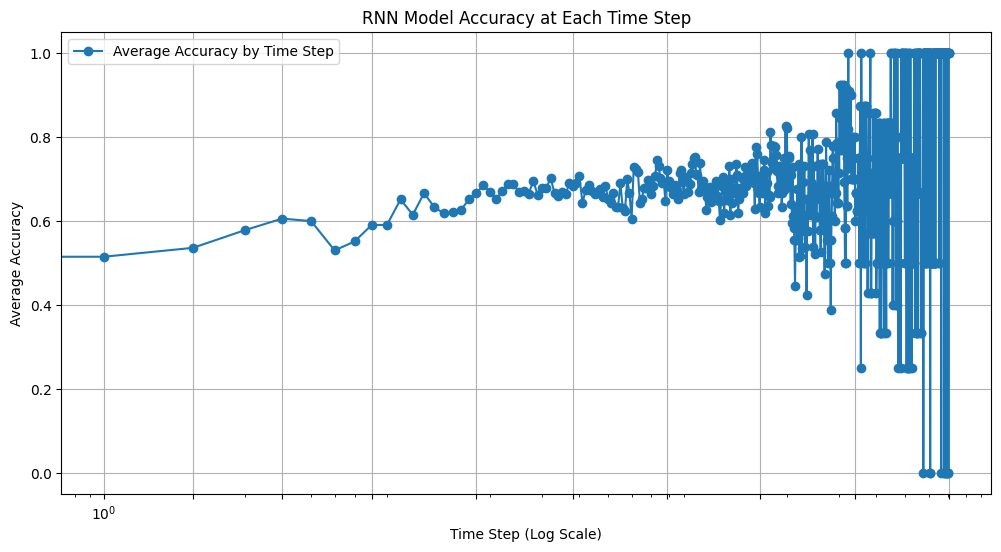

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(time_step_accuracies)), time_step_accuracies, marker='o', label='Average Accuracy by Time Step')
plt.xlabel('Time Step (Log Scale)')
plt.ylabel('Average Accuracy')
plt.title('RNN Model Accuracy at Each Time Step')
plt.xscale('log')  # Apply logarithmic scale to the x-axis
plt.xticks(np.logspace(0, np.log10(len(time_step_accuracies)), num=10, dtype=int))  # Logarithmic ticks
plt.grid(True)
plt.legend()
plt.show()

####Accuracy by Sequence Length

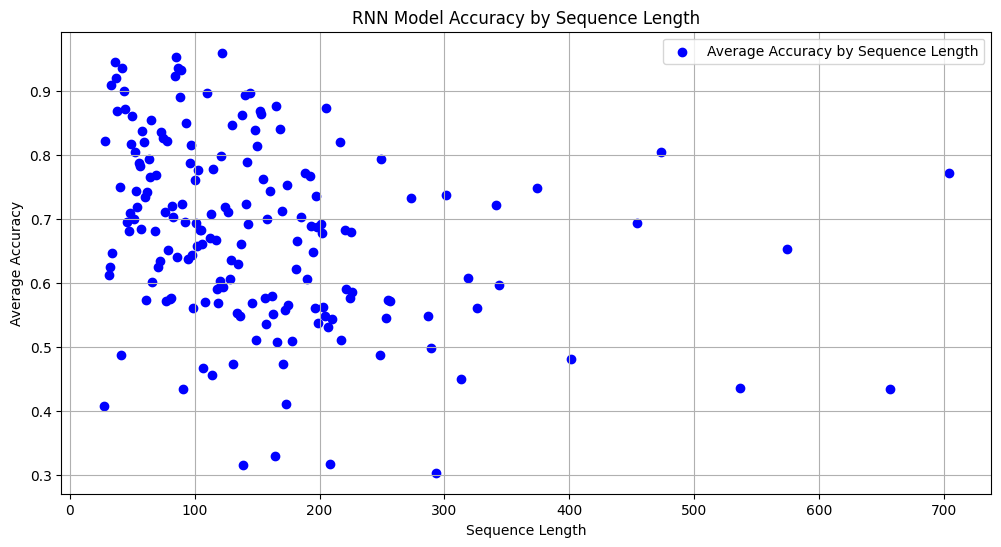

In [ ]:
# Calculate sequence lengths (number of non-padded steps per sequence)
sequence_lengths = np.sum(mask, axis=1)  # Shape: (num_sequences,)

# Calculate total correct predictions per sequence
correct_per_sequence = np.sum(correct_predictions2, axis=1)  # Shape: (num_sequences,)

# Calculate accuracy for each sequence
sequence_accuracies = correct_per_sequence / (sequence_lengths + np.finfo(float).eps)  # Shape: (num_sequences,)

# Group sequences by their lengths and compute average accuracy
accuracy_by_length = defaultdict(list)

for length, accuracy in zip(sequence_lengths, sequence_accuracies):
    accuracy_by_length[length].append(accuracy)

# Calculate average accuracy for each length
avg_accuracy_by_length = {length: np.mean(accs) for length, accs in accuracy_by_length.items()}

# Sort lengths and corresponding accuracies for plotting
lengths_sorted2 = sorted(avg_accuracy_by_length.keys())
accuracies_sorted2 = [avg_accuracy_by_length[length] for length in lengths_sorted2]

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(lengths_sorted2, accuracies_sorted2, color='blue', label='Average Accuracy by Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Average Accuracy')
plt.title('RNN Model Accuracy by Sequence Length')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Slice to include only the first 20 positions
time_step_accuracies_first_20 = time_step_accuracies[:20]

# Plot the results for the first 20 positions
plt.figure(figsize=(12, 6))
plt.plot(range(len(time_step_accuracies_first_20)), time_step_accuracies_first_20, marker='o', label='Average Accuracy by Time Step (First 20)')
plt.xticks(range(21))  # Show ticks explicitly from 0 to 20
plt.xlabel('Time Step (First 20)')
plt.ylabel('Average Accuracy')
plt.title('RNN Model Accuracy at First 20 Time Steps')
plt.grid(True)
plt.legend()
plt.show()


####Accuracy as a Function of Binned Sequence Position

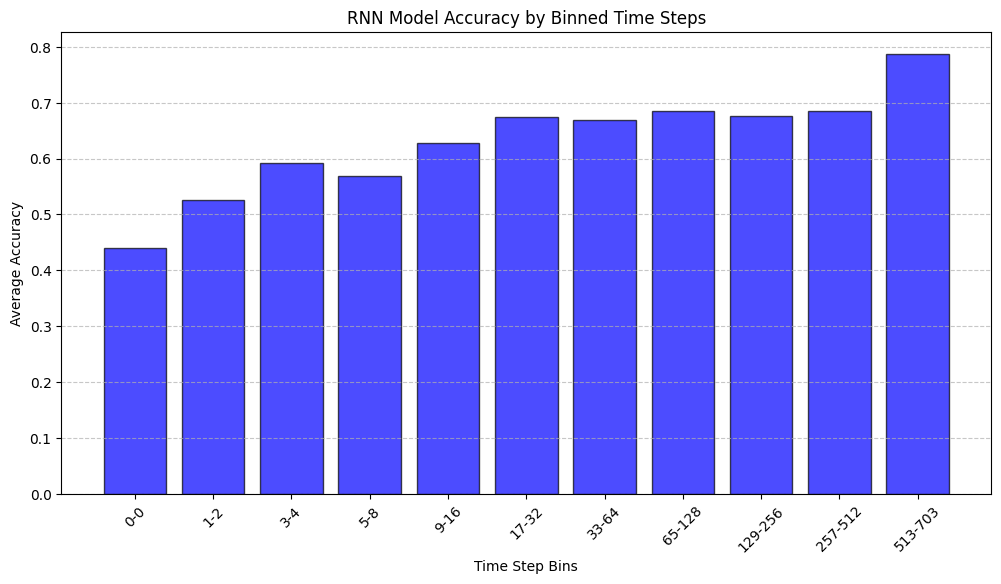

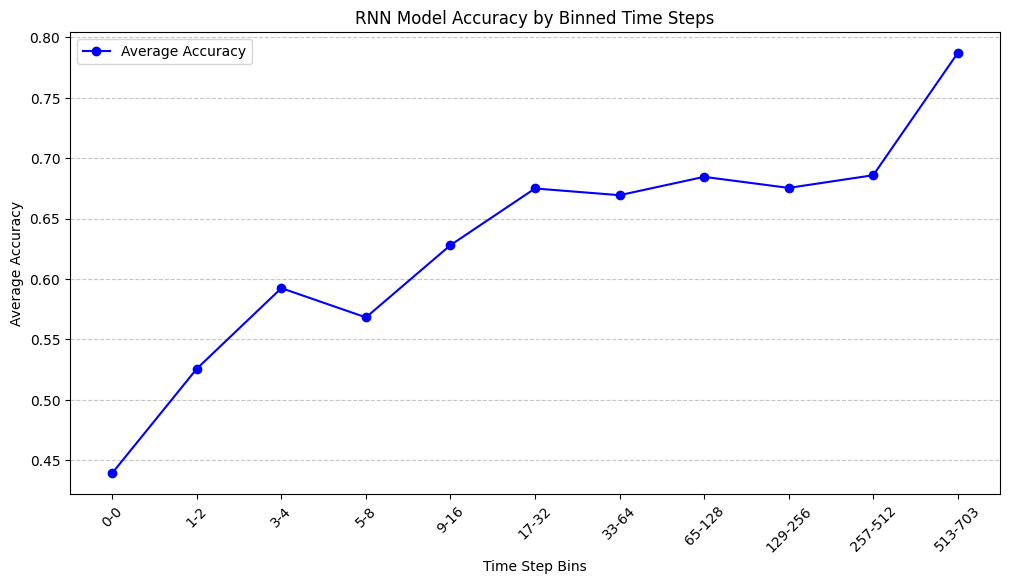

In [ ]:
#Define explicit bins and labels
bins2 = [0, 1, 3, 5, 9, 17, 33, 65, 129, 257, 513, 704]  # Explicit bin edges
bin_labels2 = [f"{bins2[i]}-{bins2[i+1]-1}" for i in range(len(bins2) - 1)]  # Bin labels

#Group time steps into bins
time_step_bins2 = pd.cut(range(len(time_step_accuracies)), bins=bins2, labels=bin_labels2, right=False)

# Initialize a dictionary to hold accuracies for each bin
bin_accuracies2 = defaultdict(list)

# Group accuracies into bins
for step, accuracy, bin_label in zip(range(len(time_step_accuracies)), time_step_accuracies, time_step_bins2):
    if pd.notnull(bin_label):  # Ensure bin label is not NaN
        bin_accuracies2[bin_label].append(accuracy)

#Calculate average accuracy for each bin
avg_accuracy_by_bin2 = {bin_label: np.mean(accs) for bin_label, accs in bin_accuracies2.items()}

# Extract sorted bins and their average accuracies
bins_sorted2 = [bin_label for bin_label in bin_labels2 if bin_label in avg_accuracy_by_bin2]
accuracies_sorted2 = [avg_accuracy_by_bin2[bin_label] for bin_label in bins_sorted2]

#Plot the results
plt.figure(figsize=(12, 6))
plt.bar(bins_sorted2, accuracies_sorted2, color='blue', alpha=0.7, edgecolor='black')
plt.xticks(rotation=45)
plt.xlabel('Time Step Bins')
plt.ylabel('Average Accuracy')
plt.title('RNN Model Accuracy by Binned Time Steps')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Plot the results as a line plot
plt.figure(figsize=(12, 6))
plt.plot(bins_sorted2, accuracies_sorted2, marker='o', linestyle='-', color='blue', label='Average Accuracy')
plt.xticks(rotation=45)
plt.xlabel('Time Step Bins')
plt.ylabel('Average Accuracy')
plt.title('RNN Model Accuracy by Binned Time Steps')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

####Accuracy as a function of Sequence Position (Players with ≥100 Actions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


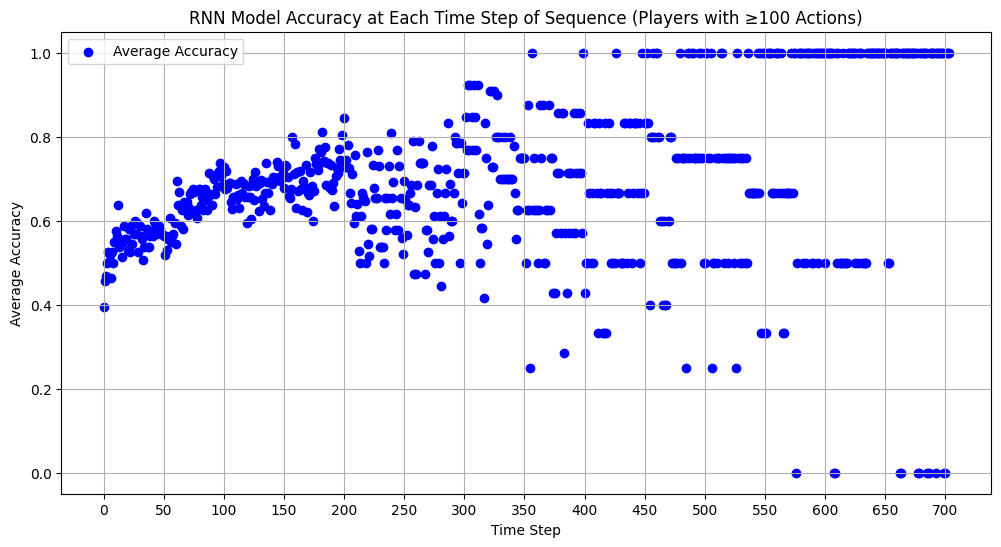

In [ ]:
# Get model predictions
y_pred_proba = RNN1.predict(RNN_sequence_val)  # Predictions in probability format
y_pred = np.argmax(y_pred_proba, axis=-1)  # Convert to predicted class labels

# Convert true labels to array
y_true = np.array(RNN_target_val)  # Shape: (num_sequences, max_sequence_length)

# Define the padding value
pad_value = 12

# Create a mask to ignore padding in targets
mask = y_true != pad_value  # Shape: (num_sequences, max_sequence_length)

# Calculate sequence lengths for each player
sequence_lengths = np.sum(mask, axis=1)  # Shape: (num_sequences,)

# Filter players with at least 100 actions
valid_players_mask = sequence_lengths >= 100
filtered_y_true = y_true[valid_players_mask]
filtered_y_pred = y_pred[valid_players_mask]
filtered_mask = mask[valid_players_mask]

# Recalculate correctness for filtered players
filtered_correct_predictions = (filtered_y_true == filtered_y_pred).astype(np.float32)  # Shape: (filtered_num_sequences, max_sequence_length)
filtered_correct_predictions *= filtered_mask

# Calculate the number of valid sequences at each time step (exclude padding)
valid_counts = np.sum(filtered_mask, axis=0)  # Shape: (max_sequence_length,)

# Calculate average accuracy at each time step
time_step_accuracies = np.sum(filtered_correct_predictions, axis=0) / (valid_counts + np.finfo(float).eps)


# Scatter plot for filtered players
plt.figure(figsize=(12, 6))
plt.scatter(range(len(time_step_accuracies)), time_step_accuracies, c='blue', label='Average Accuracy')
plt.xlabel('Time Step')
plt.ylabel('Average Accuracy')
plt.title('RNN Model Accuracy at Each Time Step of Sequence (Players with ≥100 Actions)')
plt.xticks(np.arange(0, len(time_step_accuracies), step=50))
plt.grid(True)
plt.legend()
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


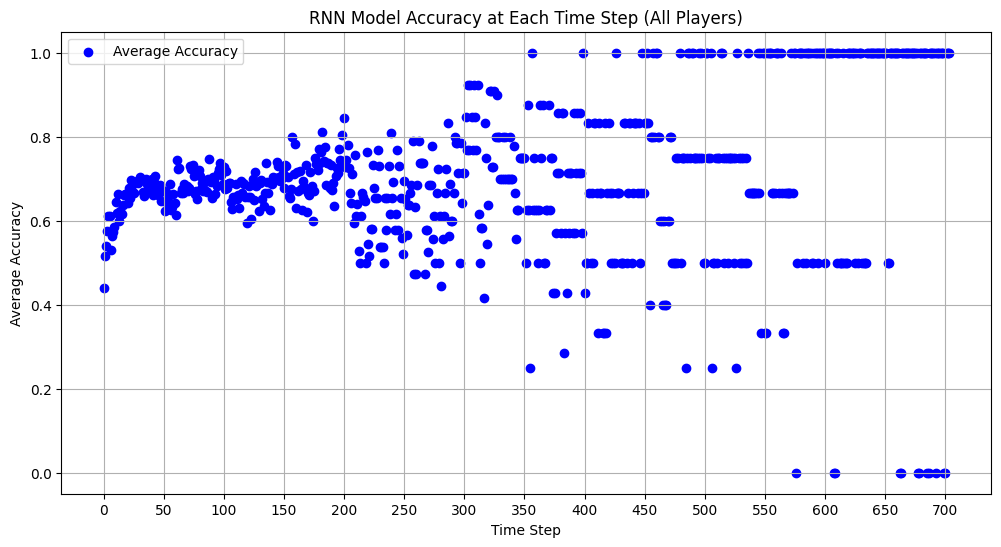

In [ ]:
# Get model predictions
y_pred_proba = RNN1.predict(RNN_sequence_val)  # Predictions in probability format
y_pred = np.argmax(y_pred_proba, axis=-1)  # Convert to predicted class labels

# Convert true labels to array
y_true = np.array(RNN_target_val)  # Shape: (num_sequences, max_sequence_length)

# Define the padding value
pad_value = 12

# Create a mask to ignore padding in targets
mask = y_true != pad_value  # Shape: (num_sequences, max_sequence_length)

# Calculate element-wise correctness for predictions
correct_predictions = (y_true == y_pred).astype(np.float32)  # Shape: (num_sequences, max_sequence_length)

# Apply the mask to exclude padded elements
correct_predictions *= mask

# Calculate the number of valid sequences at each time step (exclude padding)
valid_counts = np.sum(mask, axis=0)  # Shape: (max_sequence_length,)

# Calculate average accuracy at each time step
time_step_accuracies = np.sum(correct_predictions, axis=0) / (valid_counts + np.finfo(float).eps)

# Scatter plot for all players
plt.figure(figsize=(12, 6))
plt.scatter(range(len(time_step_accuracies)), time_step_accuracies, c='blue', label='Average Accuracy')
plt.xlabel('Time Step')
plt.ylabel('Average Accuracy')
plt.title('RNN Model Accuracy at Each Time Step (All Players)')
plt.xticks(np.arange(0, len(time_step_accuracies), step=50))
plt.grid(True)
plt.legend()
plt.show()


###ii) Accuracy as a function of Reversed Sequence Position

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


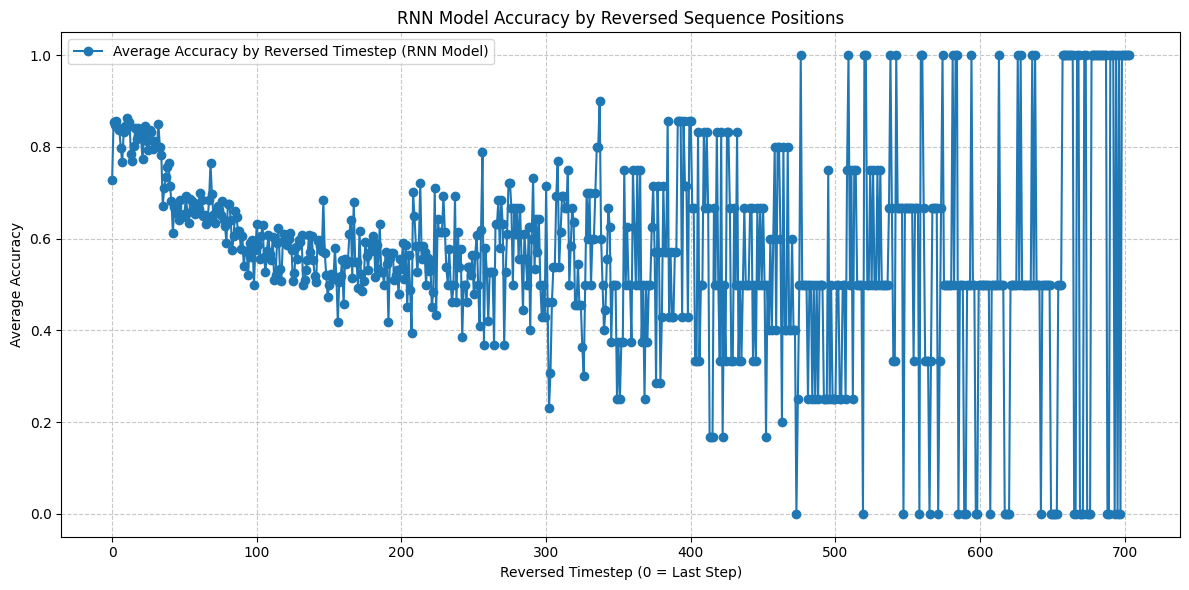

In [ ]:
# Get model predictions
y_pred_proba = RNN1.predict(RNN_sequence_val)  # Predictions in probability format
y_pred = np.argmax(y_pred_proba, axis=-1)  # Convert to predicted class labels

# Convert true labels to array
y_true = np.array(RNN_target_val)  # Shape: (num_sequences, max_sequence_length)

# Define the padding value
pad_value = 12

# Create a mask to ignore padding in targets
mask = y_true != pad_value  # Shape: (num_sequences, max_sequence_length)

# Calculate element-wise correctness for predictions
correct_predictions2 = (y_true == y_pred).astype(np.float32)  # Shape: (num_sequences, max_sequence_length)

# Apply the mask to exclude padded elements
correct_predictions2 *= mask

# Determine the actual lengths of each sequence (exclude padded values)
sequence_lengths = np.sum(mask, axis=1)  # Shape: (num_sequences,)

# Initialize arrays for reversed positions and flattened correctness
reversed_positions = []
correct_predictions_flat = []

# Calculate reversed positions and collect valid correctness
for seq_len, correct_seq in zip(sequence_lengths, correct_predictions2):
    valid_correct = correct_seq[:seq_len]  # Exclude padded values
    correct_predictions_flat.extend(valid_correct)
    reversed_positions.extend(reversed(range(seq_len)))  # Reverse positions based on valid lengths

# Initialize a dictionary to hold accuracies by reversed timestep
reversed_position_accuracies = defaultdict(list)

# Group accuracies by reversed positions
for position, is_correct in zip(reversed_positions, correct_predictions_flat):
    reversed_position_accuracies[position].append(is_correct)

# Calculate average accuracy for each reversed position
avg_accuracy_by_reversed_position = {
    pos: np.mean(accs) for pos, accs in reversed_position_accuracies.items()
}

# Sort the reversed positions in ascending order
positions_sorted_reversed = sorted(avg_accuracy_by_reversed_position.keys())
accuracies_sorted_reversed = [
    avg_accuracy_by_reversed_position[pos] for pos in positions_sorted_reversed
]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(
    positions_sorted_reversed,
    accuracies_sorted_reversed,
    marker="o",
    label="Average Accuracy by Reversed Timestep (RNN Model)",
)
plt.xlabel("Reversed Timestep (0 = Last Step)")
plt.ylabel("Average Accuracy")
plt.title("RNN Model Accuracy by Reversed Sequence Positions")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


####Log Scale Version of Accuracy as a function of Reversed Sequence Position

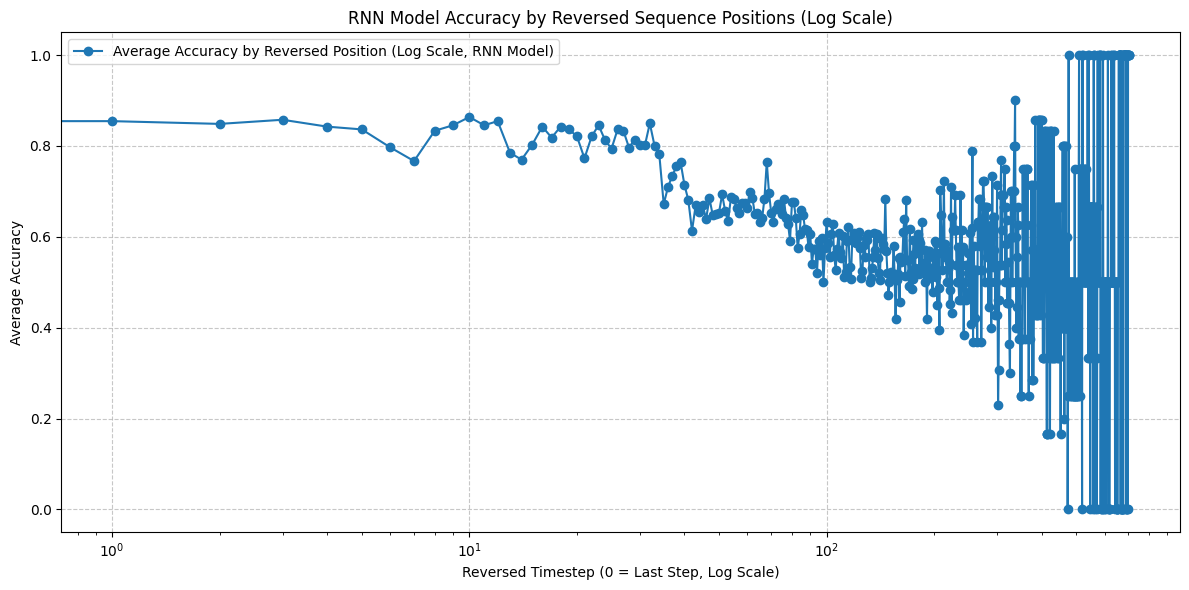

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Plot the results with a logarithmic x-axis
plt.figure(figsize=(12, 6))
plt.plot(
    positions_sorted_reversed,
    accuracies_sorted_reversed,
    marker="o",
    label="Average Accuracy by Reversed Position (Log Scale, RNN Model)",
)
plt.xscale("log")  # Set x-axis to logarithmic scale
plt.xlabel("Reversed Timestep (0 = Last Step, Log Scale)")
plt.ylabel("Average Accuracy")
plt.title("RNN Model Accuracy by Reversed Sequence Positions (Log Scale)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


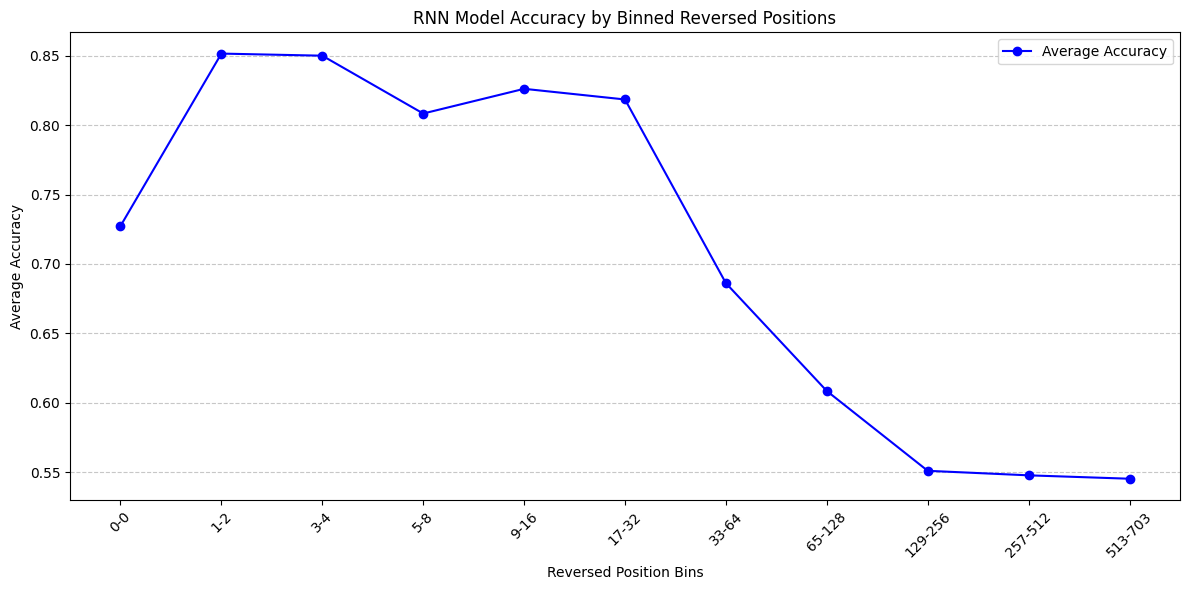

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Step 1: Define explicit bins and labels for reversed positions
bins_reversed2 = [0, 1, 3, 5, 9, 17, 33, 65, 129, 257, 513, 704]  # Explicit bin edges
bin_labels_reversed2 = [f"{bins_reversed2[i]}-{bins_reversed2[i+1]-1}" for i in range(len(bins_reversed2) - 1)]  # Bin labels

# Step 2: Group reversed positions into bins
reversed_position_bins2 = pd.cut(reversed_positions, bins=bins_reversed2, labels=bin_labels_reversed2, right=False)

# Initialize a dictionary to hold accuracies for each bin
bin_accuracies_reversed2 = defaultdict(list)

# Group accuracies into bins
for position, is_correct, bin_label in zip(reversed_positions, correct_predictions_flat, reversed_position_bins2):
    if pd.notnull(bin_label):  # Ensure bin label is not NaN
        bin_accuracies_reversed2[bin_label].append(is_correct)

# Step 3: Calculate average accuracy for each bin
avg_accuracy_by_bin_reversed2 = {bin_label: np.mean(accs) for bin_label, accs in bin_accuracies_reversed2.items()}

# Extract sorted bins and their average accuracies
bins_sorted_reversed2 = [bin_label for bin_label in bin_labels_reversed2 if bin_label in avg_accuracy_by_bin_reversed2]
accuracies_sorted_reversed2 = [avg_accuracy_by_bin_reversed2[bin_label] for bin_label in bins_sorted_reversed2]

# Step 4: Plot the results as a line plot
plt.figure(figsize=(12, 6))
plt.plot(bins_sorted_reversed2, accuracies_sorted_reversed2, marker='o', linestyle='-', color='blue', label='Average Accuracy')
plt.xticks(rotation=45)
plt.xlabel('Reversed Position Bins')
plt.ylabel('Average Accuracy')
plt.title('RNN Model Accuracy by Binned Reversed Positions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


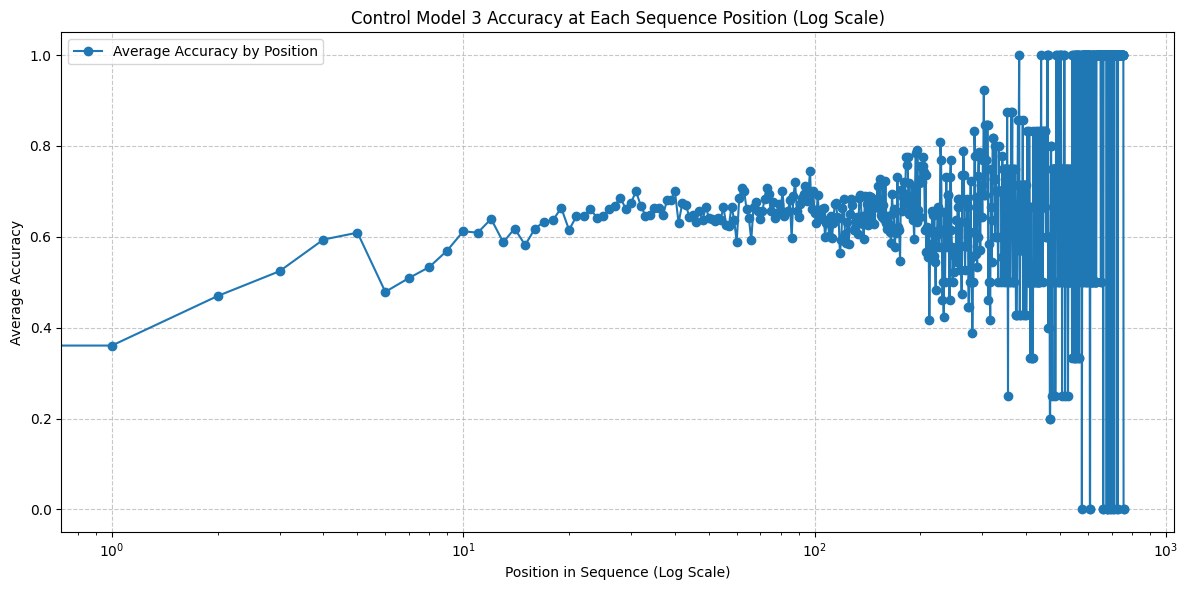

Positions with NaN values: [704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721
 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739
 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757
 758]
Total NaN values: 55


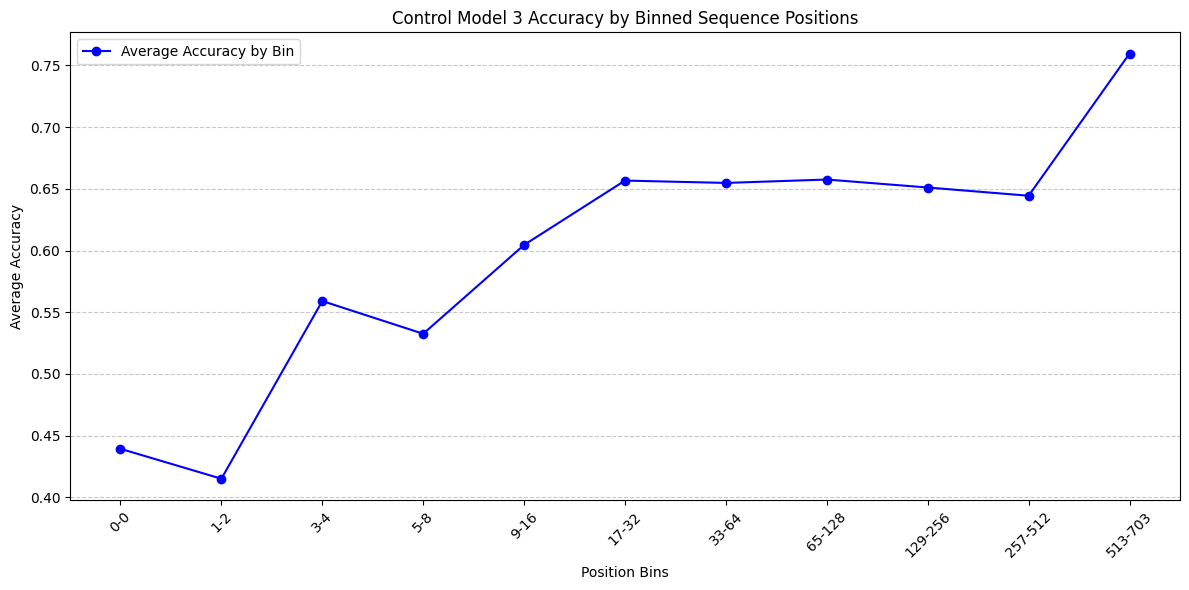

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Compute accuracy by position for control_model3
# Predict probabilities for validation data
predictions3 = control_model3.predict(Cont_X_val, batch_size=32)

# Get predicted classes (action with the highest probability)
predicted_classes3 = np.argmax(predictions3, axis=1)

# Compare predictions to true values
correct_predictions3 = (predicted_classes3 == Cont_y_val).astype(int)

# Step 2: Group by position and compute average accuracy
position_accuracies3 = defaultdict(list)

for position, is_correct in zip(positions_val, correct_predictions3):
    position_accuracies3[position].append(is_correct)

# Calculate average accuracy for each position
avg_accuracy_by_position3 = {pos: np.mean(accs) for pos, accs in position_accuracies3.items()}

# Sort positions for plotting
positions_sorted3 = sorted(avg_accuracy_by_position3.keys())
accuracies_sorted3 = [avg_accuracy_by_position3[pos] for pos in positions_sorted3]

# Step 3: Plot accuracy by position
plt.figure(figsize=(12, 6))
plt.plot(positions_sorted3, accuracies_sorted3, marker='o', label='Average Accuracy by Position')
plt.xscale("log")  # Logarithmic x-axis
plt.xlabel('Position in Sequence (Log Scale)')
plt.ylabel('Average Accuracy')
plt.title('Control Model 3 Accuracy at Each Sequence Position (Log Scale)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Step 4: Define new bins and labels for grouped analysis
bins = [0, 1, 3, 5, 9, 17, 33, 65, 129, 257, 513, 704]  # Explicit bin edges
bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]  # Custom bin labels

# Group positions into bins
position_bins3 = pd.cut(positions_val, bins=bins, labels=bin_labels, right=False)

# Check for NaN values in bins
nan_positions3 = positions_val[pd.isnull(position_bins3)]
print(f"Positions with NaN values: {nan_positions3}")
print(f"Total NaN values: {len(nan_positions3)}")

# Initialize a dictionary to hold accuracies for each bin
bin_accuracies3 = defaultdict(list)

# Group accuracies into bins
for pos, is_correct, bin_label in zip(positions_val, correct_predictions3, position_bins3):
    if pd.notnull(bin_label):  # Ensure bin label is valid
        bin_accuracies3[bin_label].append(is_correct)

# Step 5: Calculate average accuracy for each bin
avg_accuracy_by_bin3 = {bin_label: np.mean(accs) for bin_label, accs in bin_accuracies3.items()}

# Ensure all bins are represented, even if empty
accuracies_sorted_bar3 = [avg_accuracy_by_bin3.get(bin_label, 0) for bin_label in bin_labels]
# Step 6: Line plot of average accuracy by bin
plt.figure(figsize=(12, 6))
plt.plot(bin_labels, accuracies_sorted_bar3, marker='o', linestyle='-', color='blue', label='Average Accuracy by Bin')
plt.xlabel('Position Bins')
plt.ylabel('Average Accuracy')
plt.title('Control Model 3 Accuracy by Binned Sequence Positions')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()



##e) Sequence Tracking Comparison

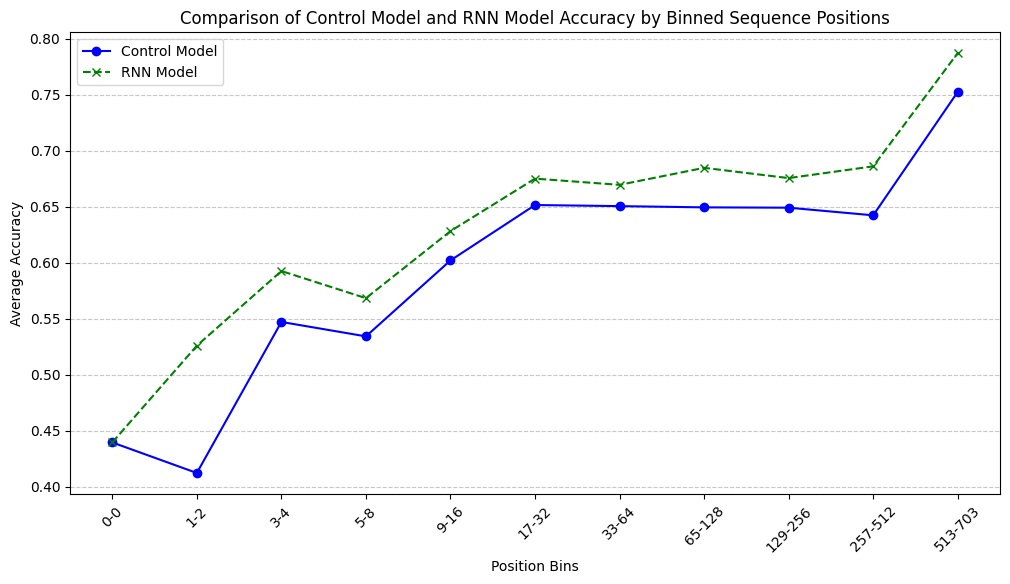

In [ ]:
#Define explicit bins and labels
bins = [0, 1, 3, 5, 9, 17, 33, 65, 129, 257, 513, 704]
bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]

#Compute binned averages for Control Model
position_bins1 = pd.cut(positions_val, bins=bins, labels=bin_labels, right=False)
bin_accuracies1 = defaultdict(list)
for pos, is_correct, bin_label in zip(positions_val, correct_predictions1, position_bins1):
    if pd.notnull(bin_label):
        bin_accuracies1[bin_label].append(is_correct)
avg_accuracy_by_bin1 = {bin_label: np.mean(accs) for bin_label, accs in bin_accuracies1.items()}
accuracies_sorted1 = [avg_accuracy_by_bin1.get(bin_label, 0) for bin_label in bin_labels]

# Compute binned averages for RNN Model
time_step_bins2 = pd.cut(range(len(time_step_accuracies)), bins=bins, labels=bin_labels, right=False)
bin_accuracies2 = defaultdict(list)
for step, accuracy, bin_label in zip(range(len(time_step_accuracies)), time_step_accuracies, time_step_bins2):
    if pd.notnull(bin_label):
        bin_accuracies2[bin_label].append(accuracy)
avg_accuracy_by_bin2 = {bin_label: np.mean(accs) for bin_label, accs in bin_accuracies2.items()}
accuracies_sorted2 = [avg_accuracy_by_bin2.get(bin_label, 0) for bin_label in bin_labels]

# Plot both results on the same figure
plt.figure(figsize=(12, 6))

# Plot for Control Model
plt.plot(bin_labels, accuracies_sorted1, marker='o', linestyle='-', color='blue', label='Control Model')

# Plot for RNN Model
plt.plot(bin_labels, accuracies_sorted2, marker='x', linestyle='--', color='green', label='RNN Model')

plt.xticks(rotation=45)
plt.xlabel('Position Bins')
plt.ylabel('Average Accuracy')
plt.title('Comparison of Control Model and RNN Model Accuracy by Binned Sequence Positions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


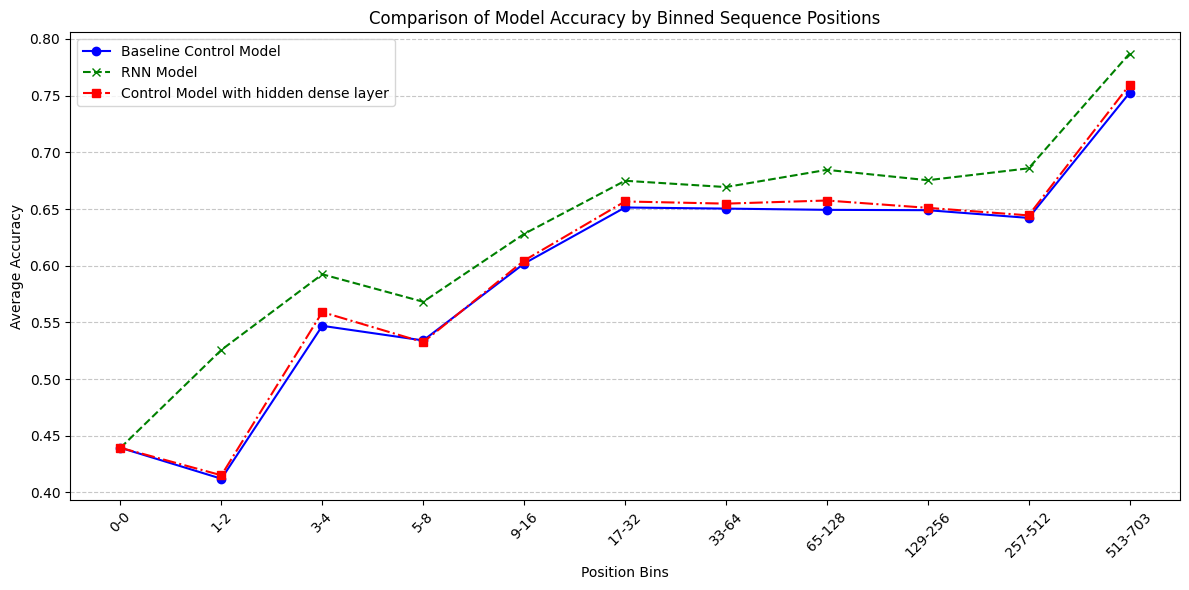

In [ ]:
# Define explicit bins and labels
bins = [0, 1, 3, 5, 9, 17, 33, 65, 129, 257, 513, 704]
bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]

# Compute binned averages for Control Model (GLM)
position_bins1 = pd.cut(positions_val, bins=bins, labels=bin_labels, right=False)
bin_accuracies1 = defaultdict(list)
for pos, is_correct, bin_label in zip(positions_val, correct_predictions1, position_bins1):
    if pd.notnull(bin_label):
        bin_accuracies1[bin_label].append(is_correct)
avg_accuracy_by_bin1 = {bin_label: np.mean(accs) for bin_label, accs in bin_accuracies1.items()}
accuracies_sorted1 = [avg_accuracy_by_bin1.get(bin_label, 0) for bin_label in bin_labels]

# Compute binned averages for RNN Model
time_step_bins2 = pd.cut(range(len(time_step_accuracies)), bins=bins, labels=bin_labels, right=False)
bin_accuracies2 = defaultdict(list)
for step, accuracy, bin_label in zip(range(len(time_step_accuracies)), time_step_accuracies, time_step_bins2):
    if pd.notnull(bin_label):
        bin_accuracies2[bin_label].append(accuracy)
avg_accuracy_by_bin2 = {bin_label: np.mean(accs) for bin_label, accs in bin_accuracies2.items()}
accuracies_sorted2 = [avg_accuracy_by_bin2.get(bin_label, 0) for bin_label in bin_labels]

# Compute binned averages for control_model3
position_bins3 = pd.cut(positions_val, bins=bins, labels=bin_labels, right=False)
bin_accuracies3 = defaultdict(list)
for pos, is_correct, bin_label in zip(positions_val, correct_predictions3, position_bins3):
    if pd.notnull(bin_label):
        bin_accuracies3[bin_label].append(is_correct)
avg_accuracy_by_bin3 = {bin_label: np.mean(accs) for bin_label, accs in bin_accuracies3.items()}
accuracies_sorted3 = [avg_accuracy_by_bin3.get(bin_label, 0) for bin_label in bin_labels]


#Plot all three results on the same figure
plt.figure(figsize=(12, 6))

# Plot for Control Model (GLM)
plt.plot(bin_labels, accuracies_sorted1, marker='o', linestyle='-', color='blue', label='Baseline Control Model')

# Plot for RNN Model
plt.plot(bin_labels, accuracies_sorted2, marker='x', linestyle='--', color='green', label='RNN Model')

# Plot for Control Model 3
plt.plot(bin_labels, accuracies_sorted3, marker='s', linestyle='-.', color='red', label='Control Model with hidden dense layer')

plt.xticks(rotation=45)
plt.xlabel('Position Bins')
plt.ylabel('Average Accuracy')
plt.title('Comparison of Model Accuracy by Binned Sequence Positions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


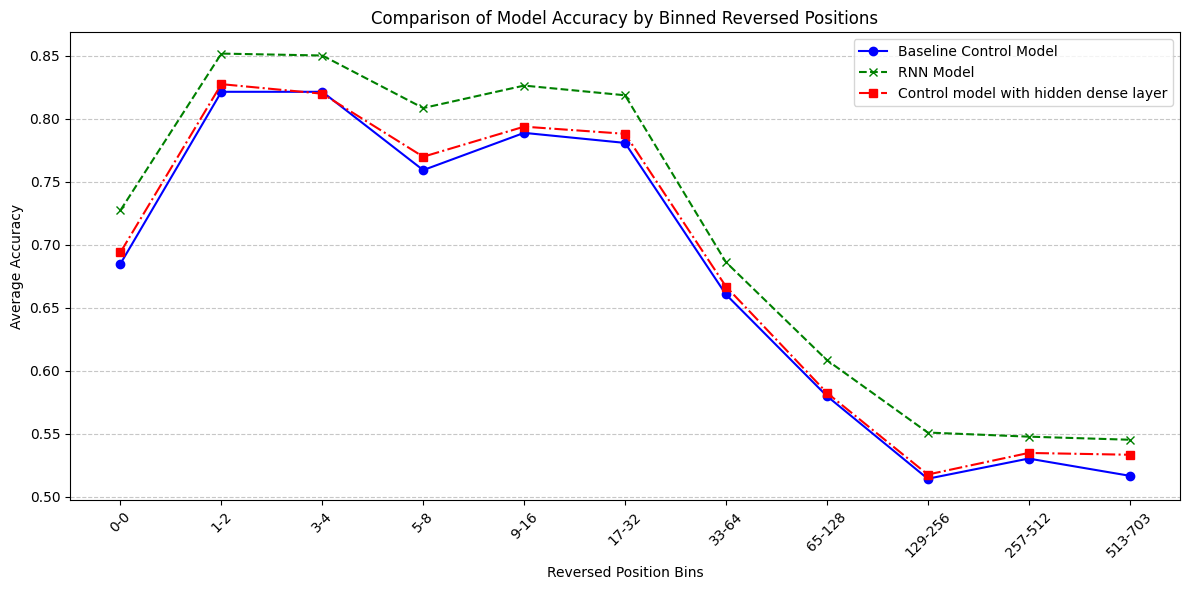

In [ ]:
# Plot all three results on the same figure
plt.figure(figsize=(12, 6))

# Plot for Control Model (GLM)
plt.plot(bin_labels_reversed, accuracies_sorted_bar_reversed, marker='o', linestyle='-', color='blue', label='Baseline Control Model')

# Plot for RNN Model
plt.plot(bin_labels_reversed, accuracies_sorted_reversed2, marker='x', linestyle='--', color='green', label='RNN Model')

# Plot for Control Model 3
plt.plot(bin_labels_reversed, accuracies_sorted_bar_reversed3, marker='s', linestyle='-.', color='red', label='Control model with hidden dense layer')

# Formatting
plt.xticks(rotation=45)
plt.xlabel('Reversed Position Bins')
plt.ylabel('Average Accuracy')
plt.title('Comparison of Model Accuracy by Binned Reversed Positions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()


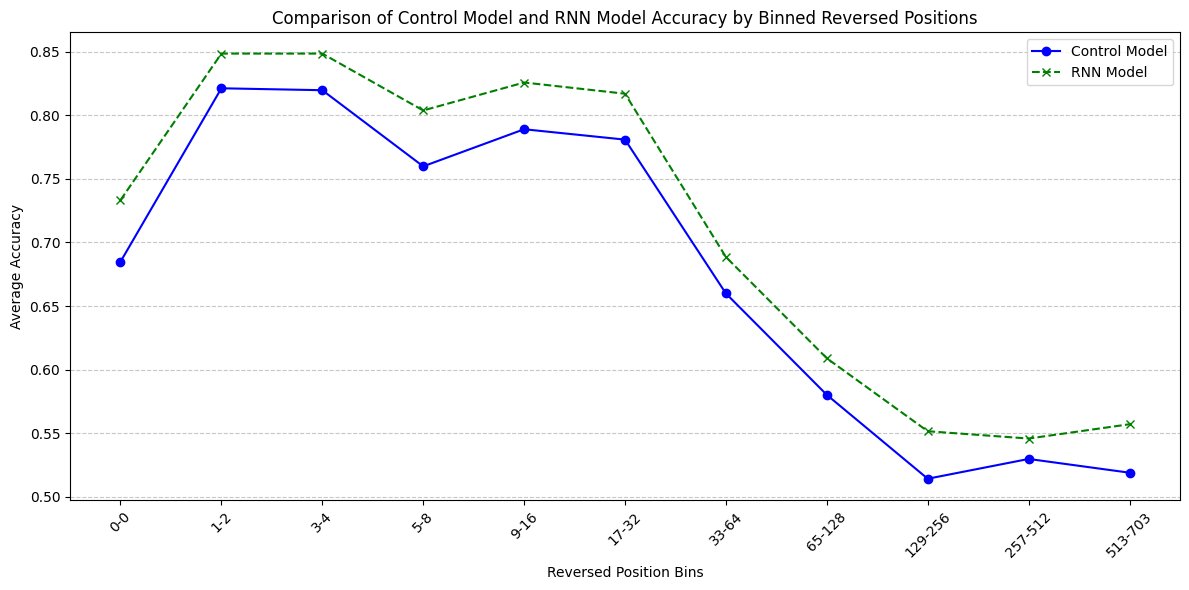

In [ ]:
# Plot both results on the same figure
plt.figure(figsize=(12, 6))

# Plot for Control Model
plt.plot(bin_labels_reversed, accuracies_sorted_bar_reversed, marker='o', linestyle='-', color='blue', label='Control Model')

# Plot for RNN Model
plt.plot(bins_sorted_reversed2, accuracies_sorted_reversed2, marker='x', linestyle='--', color='green', label='RNN Model')

# Formatting
plt.xticks(rotation=45)
plt.xlabel('Reversed Position Bins')
plt.ylabel('Average Accuracy')
plt.title('Comparison of Control Model and RNN Model Accuracy by Binned Reversed Positions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()
